In [10]:
import pandas as pd
import read_msalign

a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/ABBA100_ms2.msalign")

pairs = []
for spec in a_spec_list:
    pairs.append(frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)))

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessA[pair] = spec.header.spec_scan

a_spec_dict = {}
for spec in a_spec_list:
    a_spec_dict[str(spec.header.spec_scan)] = spec

for pair in pairs:
    spec = a_spec_dict[str(accessA[pair])]
    title = int(spec.header.title) % 100000
    spec.header.title = str(spec.header.spec_scan % 100000)
    spec.header.spec_scan = title
    spec.header.spec_id = title
    pre_mz_list = spec.header.pre_mz_list
    pre_charge_list = spec.header.pre_charge_list
    pre_mass_list = spec.header.pre_mass_list
    pre_inte_list = spec.header.pre_inte_list
    pre_id_list = spec.header.pre_id_list

    pre_mz_list[0], pre_mz_list[1] = pre_mz_list[1], pre_mz_list[0]
    pre_charge_list[0], pre_charge_list[1] = pre_charge_list[1], pre_charge_list[0]
    pre_mass_list[0], pre_mass_list[1] = pre_mass_list[1], pre_mass_list[0]
    pre_inte_list[0], pre_inte_list[1] = pre_inte_list[1], pre_inte_list[0]
    pre_id_list[0], pre_id_list[1] = pre_id_list[1], pre_id_list[0]

    spec.header.pre_mz_list = pre_mz_list
    spec.header.pre_charge_list = pre_charge_list
    spec.header.pre_mass_list = pre_mass_list
    spec.header.pre_inte_list = pre_inte_list
    spec.header.pre_id_list = pre_id_list

output_spec_list = read_msalign.sortScans(a_spec_list)

read_msalign.write_spec_file("fixed_ms2.msalign", output_spec_list)


In [29]:
import pandas as pd
import read_msalign

a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/A_ms2.msalign")

result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result.tsv", delimiter="\t")

pairs = []
for spec in a_spec_list:
    pairs.append(frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)))

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessA[pair] = spec.header.spec_scan

fulltable = result.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])

import json
import random

random.seed(0)

fulllist = fulltable.get_group(("A", "B", "B", "A"))["Pair"].to_list()

dir = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_html/toppic_prsm_cutoff/data_js/prsms/prsm"

reference = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

a_spec_dict = {}
for spec in a_spec_list:
    a_spec_dict[int(spec.header.spec_scan)] = spec

percentage = 1.0

outputList = []

for pair in fulllist:
    spec = a_spec_dict[accessA[eval(pair)]]
    curr_peak_list = spec.peak_list
    currecscore = 1
    for idx in range(0, len(curr_peak_list)):
        if currecscore >= curr_peak_list[idx].ecscore:
            currecscore = curr_peak_list[idx].ecscore
        else:
            break
    a_peaks = curr_peak_list[0:idx]
    b_peaks = curr_peak_list[idx:]
    if (len(a_spec_list) == len(curr_peak_list)):
        print("wtf something is wrong and scan is " + spec.header.spec_scan)

    prsmID = reference[reference["Scan(s)"] == int(spec.header.title)].iloc[0]["Prsm ID"]
    b_matched = []
    b_non_matched = []
    with open(dir + str(prsmID) + ".js") as file:
        file.readline()
        toppic = json.loads(file.read())
        b_peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
        for idx in range(0, len(b_peak_list)):
            if "matched_ions" in b_peak_list[idx]:
                b_matched.append(idx)
            else:
                b_non_matched.append(idx)

    b_random_idx = sorted(random.sample(b_matched, int(len(b_matched) * (1 - percentage))) + random.sample(b_non_matched, int(len(b_non_matched) * (1 - percentage))))

    for idx in b_random_idx:
        a_peaks.append(b_peaks[idx])

    spec.peak_list = a_peaks

    outputList.append(spec)

read_msalign.write_spec_file("ABBA" + str(int(percentage*100)) + "_ms2.msalign", a_spec_list)

1906
128


<Axes: >

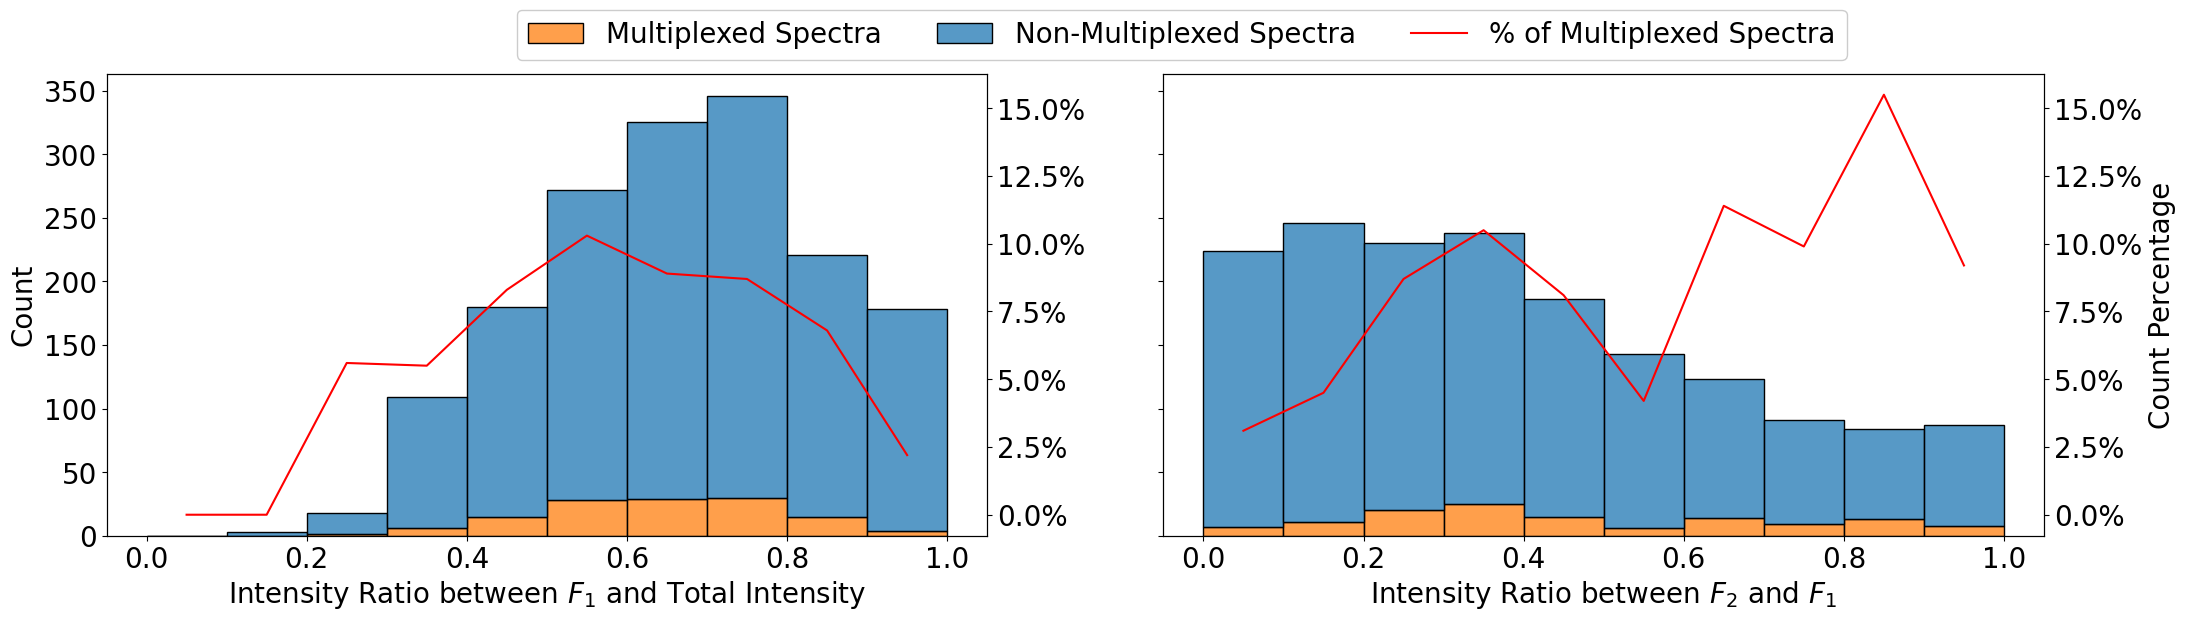

In [18]:
import read_msalign
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2.msalign")

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Multiplex/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

temp = r1.merge(r2, how="outer", on=["Scan(s)"])
print(temp.shape[0])
merge = r1.merge(r2, how="inner", on=["Scan(s)"])
print(merge.shape[0])

fig, (ax0, ax2) = plt.subplots(1, 2, figsize=(25, 6), sharex=True, sharey=True)

r1scanlist = r1["Scan(s)"].tolist()
r2scanlist = r2["Scan(s)"].tolist()
mergescanlist = merge["Scan(s)"].tolist()
#or len(spec.header.pre_inte_list) == 1 or float(spec.header.pre_inte_list[1]) == float(0)
intensity_percent = []
merged_percent = []
for spec in spec_list:
    if spec.header.pre_inte_list[0] == '' or float(spec.header.pre_inte_list[0]) == float(0) or len(spec.header.pre_inte_list) == 1 or float(spec.header.pre_inte_list[1]) == float(0):
        continue
    if not ((spec.header.spec_scan in r1scanlist or spec.header.spec_scan in r2scanlist)):
        continue
    total = sum(map(float, spec.header.pre_inte_list))
    if spec.header.spec_scan in mergescanlist:
        merged_percent.append(float(spec.header.pre_inte_list[1]) / float(spec.header.pre_inte_list[0]))
    else:
        intensity_percent.append(float(spec.header.pre_inte_list[1]) / float(spec.header.pre_inte_list[0]) )

df = pd.DataFrame(columns=["Intensity Ratio between $F_2$ and $F_1$", "Type of Spectra"])
for num in intensity_percent:
    df.loc[len(df)] = [num, "Spectra with at least 2 Features"]

for num in merged_percent:
    df.loc[len(df)] = [num, "Multiplexed Spectra"]

plt.rcParams.update({'font.size': 20})

ax1 = ax0.twinx()
ax3 = ax2.twinx()

# share the secondary axes
ax1.sharey(ax3)
sns.histplot(data=df, x="Intensity Ratio between $F_2$ and $F_1$", hue="Type of Spectra", multiple="stack", stat="count", binwidth=0.1, binrange=(0, 1), label="435", legend=False, ax=ax2)

labels = [int(v) if v else 0 for v in ax2.containers[0].datavalues]
labelsnon = [int(v) if v else 0 for v in ax2.containers[1].datavalues]
total = [sum(x) for x in zip(labels, labelsnon)]
result = [round((x / y) * 100, 1) if not y == 0 else 0 for x,y in zip(labels, total)]

sns.lineplot(x=[x / 100.0 + 0.05 for x in range(0, 100, 10)], y=result, ax=ax3, color="red", label="% of Multiplexed Spectra", legend=False)

ax3.yaxis.set_major_formatter(mtick.PercentFormatter())

ax3.set_ylabel("Count Percentage")


handles1, labels1 = ax2.get_legend_handles_labels()
handles2, labels2 = ax3.get_legend_handles_labels()
labels1 = ["Multiplexed Spectra", "Non-Multiplexed Spectra"]
ax2.legend(handles1+handles2, 
           [text for text in labels1+labels2], 
           loc='lower left', fancybox=True, framealpha=1, bbox_to_anchor=(-0.75, 1), ncol = 3)


intensity_percent = []
merged_percent = []
for spec in spec_list:
    if spec.header.pre_inte_list[0] == '' or float(spec.header.pre_inte_list[0]) == float(0) or len(spec.header.pre_inte_list) == 1 or float(spec.header.pre_inte_list[1]) == float(0):
        continue
    if not ((spec.header.spec_scan in r1scanlist or spec.header.spec_scan in r2scanlist)):
        continue
    total = sum(map(float, spec.header.pre_inte_list))
    if spec.header.spec_scan in mergescanlist:
        merged_percent.append(float(spec.header.pre_inte_list[0]) / total)
    else:
        intensity_percent.append(float(spec.header.pre_inte_list[0]) / total )

df = pd.DataFrame(columns=["Intensity Ratio between $F_1$ and Total Intensity", "Type of Spectra"])
for num in intensity_percent:
    df.loc[len(df)] = [num, "Spectra with at least 2 Features"]

for num in merged_percent:
    df.loc[len(df)] = [num, "Multiplexed Spectra"]

sns.histplot(data=df, x="Intensity Ratio between $F_1$ and Total Intensity", hue="Type of Spectra", multiple="stack", stat="count", binwidth=0.1, binrange=(0, 1), label="435", legend=False, ax=ax0)

labels = [int(v) if v else 0 for v in ax0.containers[0].datavalues]
labelsnon = [int(v) if v else 0 for v in ax0.containers[1].datavalues]
total = [sum(x) for x in zip(labels, labelsnon)]
result = [round((x / y) * 100, 1) if not y == 0 else 0 for x,y in zip(labels, total)]

sns.lineplot(x=[x / 100.0 + 0.05 for x in range(0, 100, 10)], y=result, ax=ax1, color="red", label="% of Multiplexed", legend=False)

In [21]:
import pandas as pd

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation4/FDR_No_Limit/remove_ions_new/Result.tsv", delimiter="\t", index_col=0)

df.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"]).count()

Pair  A+B_1 peaks  A+B_1 E-value  A+B_2 peaks  \
A+B_1 A+B_2 B+A_1 B+A_2                                                  
-     B     B     -         2            2              2            2   
                  A        11           11             11           11   
                  C         1            1              1            1   
A     -     -     A         3            3              3            3   
            A     A         7            7              7            7   
            B     A         2            2              2            2   
            C     A         1            1              1            1   
      B     -     A         2            2              2            2   
            A     -         8            8              8            8   
                  A        86           86             86           86   
                  C         3            3              3            3   
            B     -         2            2              2            2   
                  A      1036         1036           1036         1036   
            C     A         3            3              3            3   
      C     -     A         1            1              1            1   
            A     A         1            1              1            1   
B     -     B     -         2            2              2            2   
                  A         6            6              6            6   
                  C         1            1              1            1   
      A     B     A         2            2              2            2   
      B     B     -         9            9              9            9   
                  A       120          120            120          120   
                  C         4            4              4            4   
      C     B     A         4            4              4            4   
C     B     B     A         4            4              4            4   
                  C         2            2              2            2   

                         A+B_2 E-value  B+A_1 peaks  B+A_1 E-value  \
A+B_1 A+B_2 B+A_1 B+A_2                                              
-     B     B     -                  2            2              2   
                  A                 11           11             11   
                  C                  1            1              1   
A     -     -     A                  3            3              3   
            A     A                  7            7              7   
            B     A                  2            2              2   
            C     A                  1            1              1   
      B     -     A                  2            2              2   
            A     -                  8            8              8   
                  A                 86           86             86   
                  C                  3            3              3   
            B     -                  2            2              2   
                  A               1036         1036           1036   
            C     A                  3            3              3   
      C     -     A                  1            1              1   
            A     A                  1            1              1   
B     -     B     -                  2            2              2   
                  A                  6            6              6   
                  C                  1            1              1   
      A     B     A                  2            2              2   
      B     B     -                  9            9              9   
                  A                120          120            120   
                  C                  4            4              4   
      C     B     A                  4            4              4   
C     B     B     A                  4            4              4   
                  C                  2            2           

In [119]:
import pandas as pd
import csv
import copy

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result_1Peaks.tsv", delimiter="\t")

with open("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result_1Peaks.tsv") as f:
    prsmspeaks = [{k: v for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True, delimiter="\t")]
    
prsmsvalue = copy.deepcopy(prsmspeaks)

prsmcombined = copy.deepcopy(prsmspeaks)

In [109]:
#P1 and P2
query = df[(df["A+B_1"] == "B") & (df["A+B_2"] == "B") & (df["B+A_1"] == "B") & (df["B+A_2"] == "A")]

query["#matched peaks"] = query["A+B_1 peaks"] >= query["A+B_2 peaks"]

query["E-value"] = query["A+B_1 E-value"] <= query["A+B_2 E-value"]

query["Difference"] = ~(query["#matched peaks"] == query["E-value"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Difference"]].shape[0])

21 60
17 64
12


/tmp/ipykernel_33159/3165887939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["A+B_1 peaks"] >= query["A+B_2 peaks"]
/tmp/ipykernel_33159/3165887939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["A+B_1 E-value"] <= query["A+B_2 E-value"]
/tmp/ipykernel_33159/3165887939.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [110]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_2"] = "-"
    prsmspeaks[idx]["A+B_2 peaks"] = 0
    prsmspeaks[idx]["A+B_2 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_1"] = "-"
    prsmspeaks[idx]["A+B_1 peaks"] = 0
    prsmspeaks[idx]["A+B_1 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_2"] = "-"
    prsmsvalue[idx]["A+B_2 peaks"] = 0
    prsmsvalue[idx]["A+B_2 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_1"] = "-"
    prsmsvalue[idx]["A+B_1 peaks"] = 0
    prsmsvalue[idx]["A+B_1 E-value"] = 1

In [105]:
#P3 and P4
query = df[(df["A+B_1"] == "A") & (df["A+B_2"] == "B") & (df["B+A_1"] == "A") & (df["B+A_2"] == "A")]

query["#matched peaks"] = query["B+A_1 peaks"] >= query["B+A_2 peaks"]

query["E-value"] = query["B+A_1 E-value"] <= query["B+A_2 E-value"]

query["Difference"] = ~(query["#matched peaks"] == query["E-value"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Difference"]].shape[0])

26 58
22 62
10


/tmp/ipykernel_33159/2239245553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["B+A_1 peaks"] >= query["B+A_2 peaks"]
/tmp/ipykernel_33159/2239245553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["B+A_1 E-value"] <= query["B+A_2 E-value"]
/tmp/ipykernel_33159/2239245553.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [106]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_2"] = "-"
    prsmspeaks[idx]["B+A_2 peaks"] = 0
    prsmspeaks[idx]["B+A_2 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_1"] = "-"
    prsmspeaks[idx]["B+A_1 peaks"] = 0
    prsmspeaks[idx]["B+A_1 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_2"] = "-"
    prsmsvalue[idx]["B+A_2 peaks"] = 0
    prsmsvalue[idx]["B+A_2 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_1"] = "-"
    prsmsvalue[idx]["B+A_1 peaks"] = 0
    prsmsvalue[idx]["B+A_1 E-value"] = 1

In [126]:
#P1 and P4
query = df[(df["A+B_1"] == "B") & (df["A+B_2"] == "-") & (df["B+A_1"] == "B") & (df["B+A_2"] == "A")]

query["#matched peaks"] = query["A+B_1 peaks"] >= query["B+A_2 peaks"]

query["E-value"] = query["A+B_1 E-value"] <= query["B+A_2 E-value"]

query["Combined"] = (query["A+B_1 peaks"] + query["A+B_2 peaks"]) >= (query["B+A_1 peaks"] + query["B+A_2 peaks"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Combined"]].shape[0], query[~query["Combined"]].shape[0])

40 0
35 5
0 40


/tmp/ipykernel_33159/1887306537.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["A+B_1 peaks"] >= query["B+A_2 peaks"]
/tmp/ipykernel_33159/1887306537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["A+B_1 E-value"] <= query["B+A_2 E-value"]
/tmp/ipykernel_33159/1887306537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [127]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_2"] = "-"
    prsmspeaks[idx]["B+A_2 peaks"] = 0
    prsmspeaks[idx]["B+A_2 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_1"] = "-"
    prsmspeaks[idx]["A+B_1 peaks"] = 0
    prsmspeaks[idx]["A+B_1 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_2"] = "-"
    prsmsvalue[idx]["B+A_2 peaks"] = 0
    prsmsvalue[idx]["B+A_2 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_1"] = "-"
    prsmsvalue[idx]["A+B_1 peaks"] = 0
    prsmsvalue[idx]["A+B_1 E-value"] = 1

In [134]:
#P2 and P3
query = df[(df["A+B_1"] == "A") & (df["A+B_2"] == "B") & (df["B+A_1"] == "A") & (df["B+A_2"] == "-")]

query["#matched peaks"] = query["A+B_2 peaks"] >= query["B+A_1 peaks"]

query["E-value"] = query["A+B_2 E-value"] <= query["B+A_1 E-value"]

query["Combined"] = (query["A+B_1 peaks"] + query["A+B_2 peaks"]) >= (query["B+A_1 peaks"] + query["B+A_2 peaks"])

print(query[query["#matched peaks"]].shape[0], query[~query["#matched peaks"]].shape[0])

print(query[query["E-value"]].shape[0], query[~query["E-value"]].shape[0])

print(query[query["Combined"]].shape[0], query[~query["Combined"]].shape[0])

1 58
9 50
59 0


/tmp/ipykernel_33159/827121865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["#matched peaks"] = query["A+B_2 peaks"] >= query["B+A_1 peaks"]
/tmp/ipykernel_33159/827121865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query["E-value"] = query["A+B_2 E-value"] <= query["B+A_1 E-value"]
/tmp/ipykernel_33159/827121865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [135]:
for idx in query[query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["B+A_1"] = "-"
    prsmspeaks[idx]["B+A_1 peaks"] = 0
    prsmspeaks[idx]["B+A_1 E-value"] = 1

for idx in query[~query["#matched peaks"]].index.tolist():
    prsmspeaks[idx]["A+B_2"] = "-"
    prsmspeaks[idx]["A+B_2 peaks"] = 0
    prsmspeaks[idx]["A+B_2 E-value"] = 1

for idx in query[query["E-value"]].index.tolist():
    prsmsvalue[idx]["B+A_1"] = "-"
    prsmsvalue[idx]["B+A_1 peaks"] = 0
    prsmsvalue[idx]["B+A_1 E-value"] = 1

for idx in query[~query["E-value"]].index.tolist():
    prsmsvalue[idx]["A+B_2"] = "-"
    prsmsvalue[idx]["A+B_2 peaks"] = 0
    prsmsvalue[idx]["A+B_2 E-value"] = 1

In [136]:
outputdf_peaks = pd.DataFrame(prsmspeaks)
outputdf_values = pd.DataFrame(prsmsvalue)
outputdf_combined = pd.DataFrame(prsmcombined)

outputdf_peaks.to_csv("Result_1Peaks_2Peaks.tsv", sep="\t")
outputdf_values.to_csv("Result_1Peaks_2Value.tsv", sep="\t")
outputdf_combined.to_csv("Result_1Peaks_2Combined.tsv", sep="\t")

In [129]:
import pandas as pd
import read_msalign

intputfileA = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/ABBA_ms2_toppic_prsm_single.tsv"
intputfileAB = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/AB_ms2_toppic_prsm_single.tsv"
intputfileB = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/B_ms2_toppic_prsm.tsv"
intputfileBA = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/BA_ms2_toppic_prsm.tsv"


a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/A_ms2.msalign")

b_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/B_ms2.msalign")

result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/Result.tsv", delimiter="\t")

pairs = []
for spec in a_spec_list:
    pairs.append(frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)))

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessA[pair] = spec.header.spec_scan

accessB = {}
for pair in pairs:
    for spec in b_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == pair:
            accessB[pair] = spec.header.spec_scan

fulltable = result.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])

fulllist = fulltable.get_group(("A", "B", "B", "A"))["Pair"].to_list()

a_scans = []
for pair in fulllist:
    a_scans.append(accessA[eval(pair)])

b_scans = []
for pair in fulllist:
    b_scans.append(accessB[eval(pair)])


file = pd.read_csv(intputfileA, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(a_scans)]
outputfile.to_csv(intputfileA, sep="\t")

file = pd.read_csv(intputfileAB, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(a_scans)]
outputfile.to_csv(intputfileAB, sep="\t")

file = pd.read_csv(intputfileB, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(b_scans)]
outputfile.to_csv(intputfileB, sep="\t")

file = pd.read_csv(intputfileBA, delimiter="\t")

outputfile = file[file["Scan(s)"].isin(b_scans)]
outputfile.to_csv(intputfileBA, sep="\t")

<Figure size 1000x600 with 0 Axes>

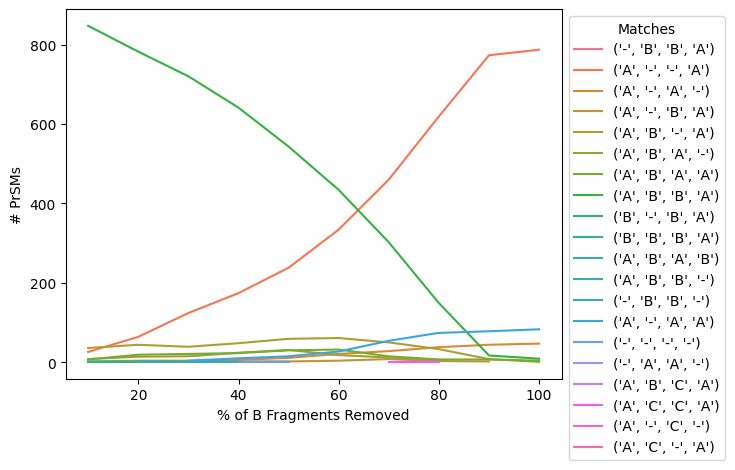

<Figure size 1000x600 with 0 Axes>

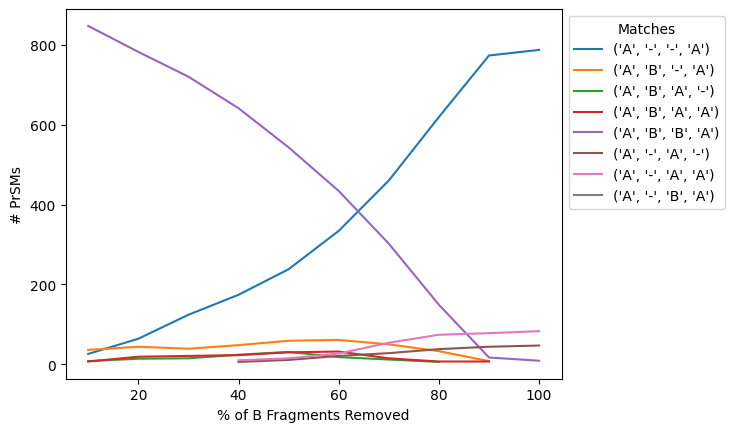

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates


r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/10%/Result.tsv", delimiter="\t")
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/20%/Result.tsv", delimiter="\t")
r3 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/30%/Result.tsv", delimiter="\t")
r4 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/40%/Result.tsv", delimiter="\t")
r5 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/50%/Result.tsv", delimiter="\t")
r6 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/60%/Result.tsv", delimiter="\t")
r7 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/70%/Result.tsv", delimiter="\t")
r8 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/80%/Result.tsv", delimiter="\t")
r9 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/90%/Result.tsv", delimiter="\t")
r10 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation3/noisetest/ABBA/100%/Result.tsv", delimiter="\t")

df = pd.DataFrame(columns=["Matches", "% of B Fragments Removed", "# PrSMs"])

r1 = r1.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r1.groups.keys():
    df.loc[len(df)] = [key,10,len(r1.get_group(key))]

r2 = r2.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r2.groups.keys():
    df.loc[len(df)] = [key,20,len(r2.get_group(key))]

r3 = r3.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r3.groups.keys():
    df.loc[len(df)] = [key,30,len(r3.get_group(key))]

r4 = r4.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r4.groups.keys():
    df.loc[len(df)] = [key,40,len(r4.get_group(key))]

r5 = r5.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r5.groups.keys():
    df.loc[len(df)] = [key,50,len(r5.get_group(key))]

r6 = r6.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r6.groups.keys():
    df.loc[len(df)] = [key,60,len(r6.get_group(key))]

r7 = r7.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r7.groups.keys():
    df.loc[len(df)] = [key,70,len(r7.get_group(key))]

r8 = r8.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r8.groups.keys():
    df.loc[len(df)] = [key,80,len(r8.get_group(key))]

r9 = r9.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r9.groups.keys():
    df.loc[len(df)] = [key,90,len(r9.get_group(key))]

r10 = r10.groupby(by=["A+B_1", "A+B_2", "B+A_1", "B+A_2"])
for key in r10.groups.keys():
    df.loc[len(df)] = [key,100,len(r10.get_group(key))]

new_df = df[df['# PrSMs'] >= 5]


plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=df, x="% of B Fragments Removed", y="# PrSMs", hue="Matches")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="% of B Fragments Removed", y="# PrSMs", hue="Matches")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [161]:
r1 = []
r1a = []
r1b = []

r1g0 = []
r1ag0 = []
r1bg0 = []

r1g1 = []
r1ag1 = []
r1bg1 = []

r1g2 = []
r1ag2 = []
r1bg2 = []

r1g3 = []
r1ag3 = []
r1bg3 = []

r2 = []
r2a = []
r2b = []

r2g0 = []
r2ag0 = []
r2bg0 = []

r2g1 = []
r2ag1 = []
r2bg1 = []

r2g2 = []
r2ag2 = []
r2bg2 = []

r2g3 = []
r2ag3 = []
r2bg3 = []

g0size = 0
g1size = 0
g2size = 0
g3size = 0

In [63]:
import sys
import pandas as pd
import read_msalign

verifier = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)

dir = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/"

result = pd.read_csv(dir + "resolved_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)

spec_list = read_msalign.read_spec_file(dir + "resolved_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in result.iterrows():
    result.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"])].header.title)

verifiedResult = pd.merge(result,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications"]], left_on='Scan(s)', right_on="Scan(s)", how='left', suffixes=("", "_True"))

joined = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_Other"))

joined["Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_True"])

joined["Verified_ProteinOther"] = (joined["Protein accession"] == joined["Protein accession_Other"])

joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01

joined["Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_True"]) < joined["proteoform_ppm"])

joined["Verified_ProteoformOther"] = (joined["Verified_ProteinOther"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_Other"]) < joined["proteoform_ppm"])


joined["Group"] = ""

joined.loc[(joined["#unexpected modifications_True"] == 0) & (joined["#unexpected modifications_Other"] == 0), "Group"] = 0
joined.loc[(joined["#unexpected modifications_True"] == 0) & (joined["#unexpected modifications_Other"] == 1), "Group"] = 1
joined.loc[(joined["#unexpected modifications_True"] == 1) & (joined["#unexpected modifications_Other"] == 0), "Group"] = 2
joined.loc[(joined["#unexpected modifications_True"] == 1) & (joined["#unexpected modifications_Other"] == 1), "Group"] = 3

# r1.append(len(finalResult))
# r1a.append(finalResult[finalResult["Verified_ProteinCorrect"] == True].shape[0] / len(finalResult) * 100)
# r1b.append(finalResult[finalResult["Verified_ProteinOther"] == True].shape[0] / len(finalResult) * 100)

# g0 = finalResult[finalResult["Group"] == 0]
# g1 = finalResult[finalResult["Group"] == 1]
# g2 = finalResult[finalResult["Group"] == 2]
# g3 = finalResult[finalResult["Group"] == 3]

# r1g0.append(len(g0))
# r1ag0.append(g0[g0["Verified_ProteinCorrect"] == True].shape[0] / len(g0) * 100)
# r1bg0.append(g0[g0["Verified_ProteinOther"] == True].shape[0] / len(g0) * 100)

# r1g1.append(len(g1))
# r1ag1.append(g1[g1["Verified_ProteinCorrect"] == True].shape[0] / len(g1) * 100)
# r1bg1.append(g1[g1["Verified_ProteinOther"] == True].shape[0] / len(g1) * 100)

# r1g2.append(len(g2))
# r1ag2.append(g2[g2["Verified_ProteinCorrect"] == True].shape[0] / len(g2) * 100)
# r1bg2.append(g2[g2["Verified_ProteinOther"] == True].shape[0] / len(g2) * 100)

# r1g3.append(len(g3))
# r1ag3.append(g3[g3["Verified_ProteinCorrect"] == True].shape[0] / len(g3) * 100)
# r1bg3.append(g3[g3["Verified_ProteinOther"] == True].shape[0] / len(g3) * 100)

# r2.append(len(finalResult[finalResult["Verified_ProteinCorrect"] == True]))
# r2a.append(finalResult[finalResult["Verified_ProteinCorrect"] == True].shape[0] /  * 100)
# r2b.append(finalResult[finalResult["Verified_ProteinOther"] == True].shape[0] / len(finalResult) * 100)

g0 = joined[joined["Group"] == 0]
g1 = joined[joined["Group"] == 1]
g2 = joined[joined["Group"] == 2]
g3 = joined[joined["Group"] == 3]

# g0size = len(g0)
# g1size = len(g1)
# g2size = len(g2)
# g3size = len(g3)

r2g0.append(g0[g0["Verified_ProteinCorrect"] == True].shape[0])
r2ag0.append(g0[g0["Verified_ProteinCorrect"] == True].shape[0] / g0size * 100)
r2bg0.append(g0[g0["Verified_ProteinOther"] == True].shape[0] / g0size * 100)

r2g1.append(g1[g1["Verified_ProteinCorrect"] == True].shape[0])
r2ag1.append(g1[g1["Verified_ProteinCorrect"] == True].shape[0] / g1size * 100)
r2bg1.append(g1[g1["Verified_ProteinOther"] == True].shape[0] / g1size * 100)

r2g2.append(g2[g2["Verified_ProteinCorrect"] == True].shape[0])
r2ag2.append(g2[g2["Verified_ProteinCorrect"] == True].shape[0] / g2size * 100)
r2bg2.append(g2[g2["Verified_ProteinOther"] == True].shape[0] / g2size * 100)

r2g3.append(g3[g3["Verified_ProteinCorrect"] == True].shape[0])
r2ag3.append(g3[g3["Verified_ProteinCorrect"] == True].shape[0] / g3size * 100)
r2bg3.append(g3[g3["Verified_ProteinOther"] == True].shape[0] / g3size * 100)

In [2]:
class EquivalenceObject:
    def __init__(self, string, number):
        self.string = string
        self.number = number

    def __eq__(self, other):
        return self.string == other.string

    def is_within_threshold(self, other, threshold):
        return abs(self.number - other.number) < threshold

class EquivalenceClass:
    def __init__(self, objects=None):
        self.objects = objects or []

    def add(self, obj):
        self.objects.append(obj)

    def union(self, other, threshold):
        union_set = EquivalenceClass(self.objects[:])
        for obj in other.objects:
            if not any(e_obj.is_within_threshold(obj, threshold) for e_obj in self.objects if e_obj == obj):
                union_set.add(obj)
        return union_set

    def subtraction(self, other, threshold):
        sub_set = EquivalenceClass()
        for obj in self.objects:
            if not any(e_obj.is_within_threshold(obj, threshold) for e_obj in other.objects if e_obj == obj):
                sub_set.add(obj)
        return sub_set

    def intersection(self, other, threshold):
        intersect_set = EquivalenceClass()
        for obj in self.objects:
            if any(e_obj.is_within_threshold(obj, threshold) for e_obj in other.objects if e_obj == obj):
                intersect_set.add(obj)
        return intersect_set
    
with open("/home/daniel/Desktop/r1proteoform.txt", 'r') as file:
    r1proteoform = file.read().splitlines()

with open("/home/daniel/Desktop/r1mass.txt", 'r') as file:
    r1mass = file.read().splitlines()

with open("/home/daniel/Desktop/r2proteoform.txt", 'r') as file:
    r2proteoform = file.read().splitlines()

with open("/home/daniel/Desktop/r2mass.txt", 'r') as file:
    r2mass = file.read().splitlines()

# with open("/home/daniel/Desktop/r3proteoform.txt", 'r') as file:
#     r3proteoform = file.read().splitlines()

# with open("/home/daniel/Desktop/r3mass.txt", 'r') as file:
#     r3mass = file.read().splitlines()

set1 = []
set2 = []
# set3 = []
for idx in range(0, len(r1proteoform)):
    set1.append(EquivalenceObject(r1proteoform[idx], float(r1mass[idx])))

for idx in range(0, len(r2proteoform)):
    set2.append(EquivalenceObject(r2proteoform[idx], float(r2mass[idx])))

# for idx in range(0, len(r3proteoform)):
#     set3.append(EquivalenceObject(r3proteoform[idx], float(r3mass[idx])))

class1 = EquivalenceClass(set1)
class2 = EquivalenceClass(set2)
# class3 = EquivalenceClass(set3)

intersect_12 = class1.intersection(class2, 1)

left = class1.subtraction(intersect_12, 1)
right = class2.subtraction(intersect_12, 1)

# intersect_123 = class1.intersection(class2, 1).intersection(class3, 1)
# intersect_12 = class1.intersection(class2, 1)
# intersect_23 = class2.intersection(class3, 1)
# intersect_13 = class1.intersection(class3, 1)
# subtraction_12 = intersect_12.subtraction(intersect_123, 1)
# subtraction_13 = intersect_13.subtraction(intersect_123, 1)
# subtraction_23 = intersect_23.subtraction(intersect_123, 1)

# left1 = class1.subtraction(intersect_123, 1).subtraction(subtraction_12, 1).subtraction(subtraction_13, 1)
# left2 = class2.subtraction(intersect_123, 1).subtraction(subtraction_12, 1).subtraction(subtraction_23, 1)
# left3 = class3.subtraction(intersect_123, 1).subtraction(subtraction_13, 1).subtraction(subtraction_23, 1)

# # Printing results
# print("Intersection Result:")
# print(len(intersect_123.objects))

# print("\nSubtraction 12 Result:")
# print(len(subtraction_12.objects))

# print("\nSubtraction 23 Result:")
# print(len(subtraction_23.objects))

# print("\nSubtraction 13 Result:")
# print(len(subtraction_13.objects))

# print("\nLeft 1 is :")
# print(len(left1.objects))

# print("\nLeft 1 is :")
# print(len(left2.objects))

# print("\nLeft 1 is :")
# print(len(left3.objects))

print("\nIntersect is :")
print(len(intersect_12.objects))

print("\nLeft is :")
print(len(left.objects))

print("\nRight is :")
print(len(right.objects))


Intersect is :
57

Left is :
8

Right is :
87


In [48]:
import pandas as pd

alpha = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/MSDeplex/resolved1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)
beta = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/MSDeplex/resolved2_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

result = alpha.merge(beta, how="inner", on="Scan(s)")

print(len(result))

proteinlist = result["Protein accession_y"].tolist()

masslist = result["Proteoform mass_y"].tolist()

multiplexset = []
for idx in range(0, len(proteinlist)):
    multiplexset.append(EquivalenceObject(proteinlist[idx], float(masslist[idx])))

multiplexclass = EquivalenceClass(multiplexset)

uniqueproteoforms = multiplexclass.intersection(class3, 1)

print(len(uniqueproteoforms.objects))

print(len(uniqueproteoforms.subtraction(class1, 1).objects))

556
268
166


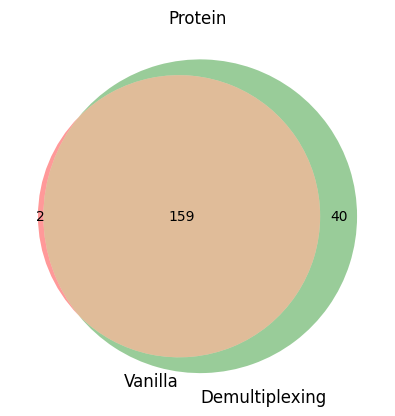

In [18]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import itertools

venn2(subsets=(2, 40, 159), set_labels=("Vanilla", "Demultiplexing"))
# venn3(subsets = (0, 0, 13, 162, 0, 11, 100), set_labels = ('TopPIC v1.7.4', 'Old Method (2 Rounds)', "New Method (4 Rounds)"))
plt.title("Protein")

plt.savefig("Protein.png", dpi=300)


In [23]:
import pandas as pd


vanilla = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/SW480/Experiment3/Experiment_3_SW480_04_01_ms2_toppic_proteoform_single.tsv", sep="\t", skiprows=26)
demultiplexing = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/SW480/Experiment3/Experiment_3_SW480_04_01_MSDeplex/Proteoform.csv", sep="\t")


# vanilla.drop_duplicates(subset="Protein accession", inplace=True)
# demultiplexing.drop_duplicates(subset="Protein accession", inplace=True)

# newProtein = demultiplexing[~demultiplexing["Protein accession"].isin(vanilla["Protein accession"])]
vanilla[vanilla["Protein accession"] == "sp|P14866|HNRPL_HUMAN"]
# newProtein.to_csv("NewProtein.csv", sep="\t")

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


newproteins = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/SW480/CRC_SW480_SEC1_RPLC1_MSDeplex/NewProtein.csv", sep="\t")

totalresult = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/SW480/CRC_SW480_SEC1_RPLC1_MSDeplex/Result_resolved.tsv", sep="\t")

newproteins["Round"] = 0

newproteins.loc[0:15, "Round"] = 1

newproteins.loc[15:, "Round"] = 2

df = newproteins.merge(totalresult, how="left", left_on="Scan(s)", right_on="Scan")

df[(df["Round"] == 2) & (df["choice"] == "A") & (df["Protein accession"] == df["A+B_2"]) & (df["A+B_2 E-value"] < 0.1)]

# evalues = []
# for idx, row in df.iterrows():
#     if (row["Round"] == 1) and (row["choice"] == "A"):
#         evalues.append((row["E-value"], row["A+B_1 E-value"]))
#     elif (row["Round"] == 2) and (row["choice"] == "A"):
#         evalues.append((row["E-value"], row["A+B_2 E-value"]))
#     elif (row["Round"] == 1) and (row["choice"] == "B"):
#         evalues.append((row["E-value"], row["B+A_1 E-value"]))
#     elif (row["Round"] == 2) and (row["choice"] == "B"):
#         evalues.append((row["E-value"], row["B+A_1 E-value"]))

# print(evalues)

# x, y = zip(*evalues)

# max_val = max(max(x), max(y))
# min_val = min(min(x), min(y))
# plt.xlim(min_val, max_val)
# plt.ylim(min_val, max_val)

# plt.xscale('log')
# plt.yscale('log')
    
# # Create a scatter plot
# plt.scatter(x, y)

# plt.axhline(y=0.01, color='r', linestyle='-', label='y=0.01')
# plt.axvline(x=0.01, color='r', linestyle='-', label='x=0.01')

# # Adding titles and labels
# plt.title('E-values of the New Proteins')
# plt.xlabel('After Recalculations')
# plt.ylabel('Before Recalculations')
    
#     # Show the plot
# plt.show()

,Unnamed: 0_x,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,...,A+B_2 E-value,B+A_1,B+A_1_mass,B+A_1 peaks,B+A_1 E-value,B+A_2,B+A_2_mass,B+A_2 peaks,B+A_2 E-value,choice
38,129,/home/daniel/Desktop/datafiles/RealData/SW480/...,121,2705,HCD,2705,2321.32,48,16,10563.52988,...,0.035638,-,0.000000,0,1.000000e+00,sp|P05114|HMGN1_HUMAN,10536.55208,10,1.562275e+00,A
45,139,/home/daniel/Desktop/datafiles/RealData/SW480/...,146,3691,HCD,3691,3150.80,27,3,1854.96930,...,0.000783,sp|P05089|ARGI1_HUMAN,1854.968706,10,7.852941e-04,sp|P05114|HMGN1_HUMAN,10521.55277,13,7.954800e-09,A
48,143,/home/daniel/Desktop/datafiles/RealData/SW480/...,153,4126,HCD,4126,3533.11,36,17,10618.48835,...,0.009342,sp|P05114|HMGN1_HUMAN,10619.560700,18,9.226446e-07,sp|A3KN83|SBNO1_HUMAN,10602.56035,5,6.001209e+01,A
50,147,/home/daniel/Desktop/datafiles/RealData/SW480/...,163,4271,HCD,4271,3650.97,37,3,2427.14631,...,0.000127,sp|O60830|TI17B_HUMAN,2427.149524,10,1.547266e-04,sp|P05114|HMGN1_HUMAN,10521.55277,8,4.232200e-05,A


In [2]:
import read_msalign

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/MSDeplex/A_ms2.msalign")

for spec in spec_list:
    if len(spec.header.pre_mz_list) == 1:
        print(spec.header.spec_scan)

In [2]:
import read_msalign

refernencealign = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2.msalign")

referenceDict = {}
for spec in refernencealign:
    referenceDict[str(spec.header.spec_scan)] = spec



spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/noisetest/dataset2/0/20231215_ecoli_400ng_daniel_1_ms2.msalign")

maxdiff = 0
for spec in spec_list:
    basescan = str(spec.header.spec_scan)
    noisescan = str(spec.header.title)
    massdiff = float(referenceDict[basescan].header.pre_mass_list[0]) - float(referenceDict[noisescan].header.pre_mass_list[0])
    if massdiff > maxdiff:
        maxdiff = massdiff

print(maxdiff)

15936.211970000002


In [4]:
import read_msalign

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Multiplex/A_ms2.msalign")

print(len(spec_list))

10320


In [28]:
import pandas as pd

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Multiplex/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)

result = r1.merge(r2, how="outer", on="Scan(s)")

# result[result["Protein accession_x"] != result["Protein accession_y"]]
result


,Data file name_x,Prsm ID_x,Spectrum ID_x,Fragmentation_x,Scan(s),Retention time_x,#peaks_x,Charge_x,Precursor mass_x,Adjusted precursor mass_x,...,#unexpected modifications_y,unexpected modifications_y,#variable PTMs_y,variable PTMs_y,MIScore_y,#matched peaks_y,#matched fragment ions_y,E-value_y,Spectrum-level Q-value_y,Proteoform-level Q-value_y
0,/home/daniel/Desktop/datafiles/RealData/ecoli/...,0.0,1453.0,HCD,1698,1314.73,20.0,2.0,1486.77280,1486.762736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/home/daniel/Desktop/datafiles/RealData/ecoli/...,1.0,1481.0,HCD,1730,1338.75,22.0,3.0,2469.98007,2469.960070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/home/daniel/Desktop/datafiles/RealData/ecoli/...,2.0,1483.0,HCD,1733,1341.64,16.0,3.0,2599.02363,2600.075980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/home/daniel/Desktop/datafiles/RealData/ecoli/...,3.0,1501.0,HCD,1754,1357.88,13.0,3.0,2523.13205,2523.114989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/home/daniel/Desktop/datafiles/RealData/ecoli/...,4.0,1513.0,HCD,1768,1369.05,27.0,5.0,3621.94079,3621.915790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,NaN,NaN,NaN,NaN,9378,NaN,NaN,NaN,NaN,NaN,...,1.0,-10.0014:[21-31],0.0,NaN,-,16.0,13.0,0.005334,-,-
1921,NaN,NaN,NaN,NaN,9398,NaN,NaN,NaN,NaN,NaN,...,1.0,-10.0364:[22-31],0.0,NaN,-,12.0,12.0,0.001999,-,-
1922,NaN,NaN,NaN,NaN,9632,NaN,NaN,NaN,NaN,NaN,...,1.0,+15.9990:[4-7],0.0,NaN,-,14.0,13.0,0.000001,-,-
1923,NaN,NaN,NaN,NaN,11617,NaN,NaN,NaN,NaN,NaN,...,1.0,-1.9936:[87],0.0,NaN,-,9.0,9.0,0.001536,-,-


In [67]:
r2bg3

[0.0,
 0.0,
 0.0,
 0.0,
 0.7633587786259541,
 1.5267175572519083,
 3.816793893129771,
 4.580152671755725,
 5.343511450381679,
 6.870229007633588,
 9.923664122137405]

In [18]:
g0size = 0
g1size = 0
g2size = 0
g3size = 0

r2g0 = []
r2ag0 = []
r2bg0 = []

r2g1 = []
r2ag1 = []
r2bg1 = []

r2g2 = []
r2ag2 = []
r2bg2 = []

r2g3 = []
r2ag3 = []
r2bg3 = []

In [31]:
r2bg3

[0.0,
 0.0,
 0.5050505050505051,
 1.0101010101010102,
 1.5151515151515151,
 2.0202020202020203,
 3.535353535353535,
 3.535353535353535,
 4.040404040404041,
 4.545454545454546,
 4.545454545454546]

In [1]:
#Combined Code
g0size = 213
g1size = 213
g2size = 198
g3size = 198

r2g0 = [212, 211, 209, 207, 199, 194, 193, 187, 184, 183, 180]
r2ag0 = [99.53051643192488,
 99.06103286384976,
 98.12206572769952,
 97.1830985915493,
 93.42723004694837,
 91.07981220657277,
 90.61032863849765,
 87.79342723004694,
 86.3849765258216,
 85.91549295774648,
 84.50704225352112]
r2bg0 = [0.0,
 0.0,
 0.0,
 0.4694835680751174,
 1.8779342723004695,
 2.3474178403755865,
 2.8169014084507045,
 4.225352112676056,
 6.572769953051644,
 7.042253521126761,
 7.511737089201878]

r2g1 = [212, 210, 208, 203, 200, 198, 195, 194, 193, 187, 182]
r2ag1 = [99.53051643192488,
 98.59154929577466,
 97.65258215962442,
 95.30516431924883,
 93.89671361502347,
 92.95774647887323,
 91.54929577464789,
 91.07981220657277,
 90.61032863849765,
 87.79342723004694,
 85.44600938967136]
r2bg1 = [0.0,
 0.0,
 0.5050505050505051,
 1.0101010101010102,
 3.0303030303030303,
 3.535353535353535,
 3.535353535353535,
 4.545454545454546,
 9.090909090909092,
 10.606060606060606,
 13.636363636363635]

r2g2 = [198, 190, 177, 172, 168, 161, 153, 146, 133, 127, 117]
r2ag2 = [100.0,
 95.95959595959596,
 89.39393939393939,
 86.86868686868688,
 84.84848484848484,
 81.31313131313132,
 77.27272727272727,
 73.73737373737373,
 67.17171717171718,
 64.14141414141415,
 59.09090909090909]
r2bg2 = [0.0,
 0.0,
 0.5050505050505051,
 1.0101010101010102,
 3.0303030303030303,
 3.535353535353535,
 3.535353535353535,
 4.545454545454546,
 9.090909090909092,
 10.606060606060606,
 13.636363636363635]

r2g3 = [198, 186, 180, 170, 163, 154, 146, 138, 134, 132, 126]
r2ag3 = [100.0,
 93.93939393939394,
 90.9090909090909,
 85.85858585858585,
 82.32323232323232,
 77.77777777777779,
 73.73737373737373,
 69.6969696969697,
 67.67676767676768,
 66.66666666666666,
 63.63636363636363]
r2bg3 = [0.0,
 0.0,
 0.5050505050505051,
 1.0101010101010102,
 1.5151515151515151,
 2.0202020202020203,
 3.535353535353535,
 3.535353535353535,
 4.040404040404041,
 4.545454545454546,
 4.545454545454546]

In [13]:
g0size = 0
g1size = 0
g2size = 0
g3size = 0

r2g0 = []
r2ag0 = []
r2bg0 = []

r2g1 = []
r2ag1 = []
r2bg1 = []

r2g2 = []
r2ag2 = []
r2bg2 = []

r2g3 = []
r2ag3 = []
r2bg3 = []

In [24]:
import pandas as pd
import read_msalign
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

verifier = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

dir = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/noisetest/combined/200/"

result = pd.read_csv(dir + "20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)

spec_list = read_msalign.read_spec_file(dir + "20231215_ecoli_400ng_daniel_1_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in result.iterrows():
    result.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"])].header.title)

result["Scan"] = result["Scan(s)"] % 100000

verifiedResult = pd.merge(result,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value", "#peaks"]], left_on='Scan', right_on="Scan(s)", how='left', suffixes=("", "_True"))

joined = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value", "#peaks"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_Other"))

joined["Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_True"])

joined["Verified_ProteinOther"] = (joined["Protein accession"] == joined["Protein accession_Other"])

joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01

joined["Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_True"]) < joined["proteoform_ppm"])

joined["Verified_ProteoformOther"] = (joined["Verified_ProteinOther"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_Other"]) < joined["proteoform_ppm"])


joined["Group"] = ""

joined.loc[(joined["#unexpected modifications_True"] == 0) & (joined["#unexpected modifications_Other"] == 0), "Group"] = 0
joined.loc[(joined["#unexpected modifications_True"] == 0) & (joined["#unexpected modifications_Other"] == 1), "Group"] = 1
joined.loc[(joined["#unexpected modifications_True"] == 1) & (joined["#unexpected modifications_Other"] == 0), "Group"] = 2
joined.loc[(joined["#unexpected modifications_True"] == 1) & (joined["#unexpected modifications_Other"] == 1), "Group"] = 3

joined["Logged E-value of Base Spectrum"] = np.log10(joined["E-value_True"])
joined["Logged E-value of Noise Spectrum"] = np.log10(joined["E-value_Other"])

g0 = joined[joined["Group"] == 0]
g1 = joined[joined["Group"] == 1]
g2 = joined[joined["Group"] == 2]
g3 = joined[joined["Group"] == 3]

# g0size = len(g0)
# g1size = len(g1)
# g2size = len(g2)
# g3size = len(g3)

r2g0.append(g0[g0["Verified_ProteinCorrect"] == True].shape[0])
r2ag0.append(g0[g0["Verified_ProteinCorrect"] == True].shape[0] / g0size * 100)
r2bg0.append(g0[g0["Verified_ProteinOther"] == True].shape[0] / g0size * 100)

r2g1.append(g1[g1["Verified_ProteinCorrect"] == True].shape[0])
r2ag1.append(g1[g1["Verified_ProteinCorrect"] == True].shape[0] / g1size * 100)
r2bg1.append(g1[g1["Verified_ProteinOther"] == True].shape[0] / g1size * 100)

r2g2.append(g2[g2["Verified_ProteinCorrect"] == True].shape[0])
r2ag2.append(g2[g2["Verified_ProteinCorrect"] == True].shape[0] / g2size * 100)
r2bg2.append(g2[g2["Verified_ProteinOther"] == True].shape[0] / g2size * 100)

r2g3.append(g3[g3["Verified_ProteinCorrect"] == True].shape[0])
r2ag3.append(g3[g3["Verified_ProteinCorrect"] == True].shape[0] / g3size * 100)
r2bg3.append(g3[g3["Verified_ProteinOther"] == True].shape[0] / g3size * 100)


# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Distinct colors for each group

# g = sns.FacetGrid(joined, col='Group', hue='Group', col_wrap=2, palette=colors, height=4, aspect=1.3)

# g.map(sns.scatterplot, '#matched peaks_Other', '#peaks_Other')

# plt.xlim(0, 75)  # Adjust the range as needed
# plt.ylim(0, 400)

# g.set_axis_labels('', '')

# # Add a single x-axis label for the entire grid
# g.figure.text(0.5, 0.04, '# of matched peaks', ha='center')
# g.figure.text(0.04, 0.5, '# of peaks', va='center', rotation='vertical')
# g.figure.suptitle("# of Matched Peaks vs # of Peaks for Noise Spectra", y=1.02)

plt.show()

In [28]:
import pandas as pd
import read_msalign
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

verifier = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

dir = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/noisetest/combined/0/"

result = pd.read_csv(dir + "20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)

spec_list = read_msalign.read_spec_file(dir + "20231215_ecoli_400ng_daniel_1_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in result.iterrows():
    result.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"])].header.title)

verifiedResult = pd.merge(result,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value", "#peaks"]], left_on='Scan(s)', right_on="Scan(s)", how='left', suffixes=("", "_True"))

joined = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value", "#peaks"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_Other"))

joined["Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_True"])

joined["Verified_ProteinOther"] = (joined["Protein accession"] == joined["Protein accession_Other"])

joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01

joined["Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_True"]) < joined["proteoform_ppm"])

joined["Verified_ProteoformOther"] = (joined["Verified_ProteinOther"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_Other"]) < joined["proteoform_ppm"])

joined["Group"] = ""

joined.loc[(joined["#unexpected modifications_True"] == 0) & (joined["#unexpected modifications_Other"] == 0), "Group"] = 0
joined.loc[(joined["#unexpected modifications_True"] == 0) & (joined["#unexpected modifications_Other"] == 1), "Group"] = 1
joined.loc[(joined["#unexpected modifications_True"] == 1) & (joined["#unexpected modifications_Other"] == 0), "Group"] = 2
joined.loc[(joined["#unexpected modifications_True"] == 1) & (joined["#unexpected modifications_Other"] == 1), "Group"] = 3

joined["Logged E-value of Base Spectrum"] = np.log10(joined["E-value_True"])
joined["Logged E-value of Noise Spectrum"] = np.log10(joined["E-value_Other"])

g0 = joined[joined["Group"] == 0]
g1 = joined[joined["Group"] == 1]
g2 = joined[joined["Group"] == 2]
g3 = joined[joined["Group"] == 3]

# g0size = len(g0)
# g1size = len(g1)
# g2size = len(g2)
# g3size = len(g3)

r2g0.append(g0[g0["Verified_ProteinCorrect"] == True].shape[0])
r2ag0.append(g0[g0["Verified_ProteinCorrect"] == True].shape[0] / g0size * 100)
r2bg0.append(g0[g0["Verified_ProteinOther"] == True].shape[0] / g0size * 100)

r2g1.append(g1[g1["Verified_ProteinCorrect"] == True].shape[0])
r2ag1.append(g1[g1["Verified_ProteinCorrect"] == True].shape[0] / g1size * 100)
r2bg1.append(g1[g1["Verified_ProteinOther"] == True].shape[0] / g1size * 100)

r2g2.append(g2[g2["Verified_ProteinCorrect"] == True].shape[0])
r2ag2.append(g2[g2["Verified_ProteinCorrect"] == True].shape[0] / g2size * 100)
r2bg2.append(g2[g2["Verified_ProteinOther"] == True].shape[0] / g2size * 100)

r2g3.append(g3[g3["Verified_ProteinCorrect"] == True].shape[0])
r2ag3.append(g3[g3["Verified_ProteinCorrect"] == True].shape[0] / g3size * 100)
r2bg3.append(g3[g3["Verified_ProteinOther"] == True].shape[0] / g3size * 100)


# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Distinct colors for each group

# g = sns.FacetGrid(joined, col='Group', hue='Group', col_wrap=2, palette=colors, height=4, aspect=1.3)

# g.map(sns.scatterplot, '#matched peaks_Other', '#peaks_Other')

# plt.xlim(0, 75)  # Adjust the range as needed
# plt.ylim(0, 400)

# g.set_axis_labels('', '')

# # Add a single x-axis label for the entire grid
# g.figure.text(0.5, 0.04, '# of matched peaks', ha='center', fontsize=32)
# g.figure.text(0.04, 0.5, '# of peaks', va='center', rotation='vertical', fontsize=32)
# g.figure.suptitle("# of Matched Peaks vs # of Peaks for Noise Spectra", fontsize=32, y=1.02)

# plt.show()

Data file name                      /home/daniel/Desktop/datafiles/RealData/ecoli/...
Prsm ID                                                                           387
Spectrum ID                                                                    111861
Fragmentation                                                                     HCD
Scan(s)                                                                        111861
                                                          ...                        
Verified_ProteoformCorrect                                                      False
Verified_ProteoformOther                                                        False
Group                                                                                
Logged E-value of Base Spectrum                                                   NaN
Logged E-value of Noise Spectrum                                            -5.349692
Name: 387, Length: 61, dtype: object

In [174]:
difference = set(g0i["Scan(s)"]).difference(set(g0f["Scan(s)"]))

# Get rows from df1 where the column of interest has the difference
result_df1 = g0i[g0i["Scan(s)"].isin(difference)]
result_df1

result_df1["#peaks_Other"].mean()

np.float64(142.5)

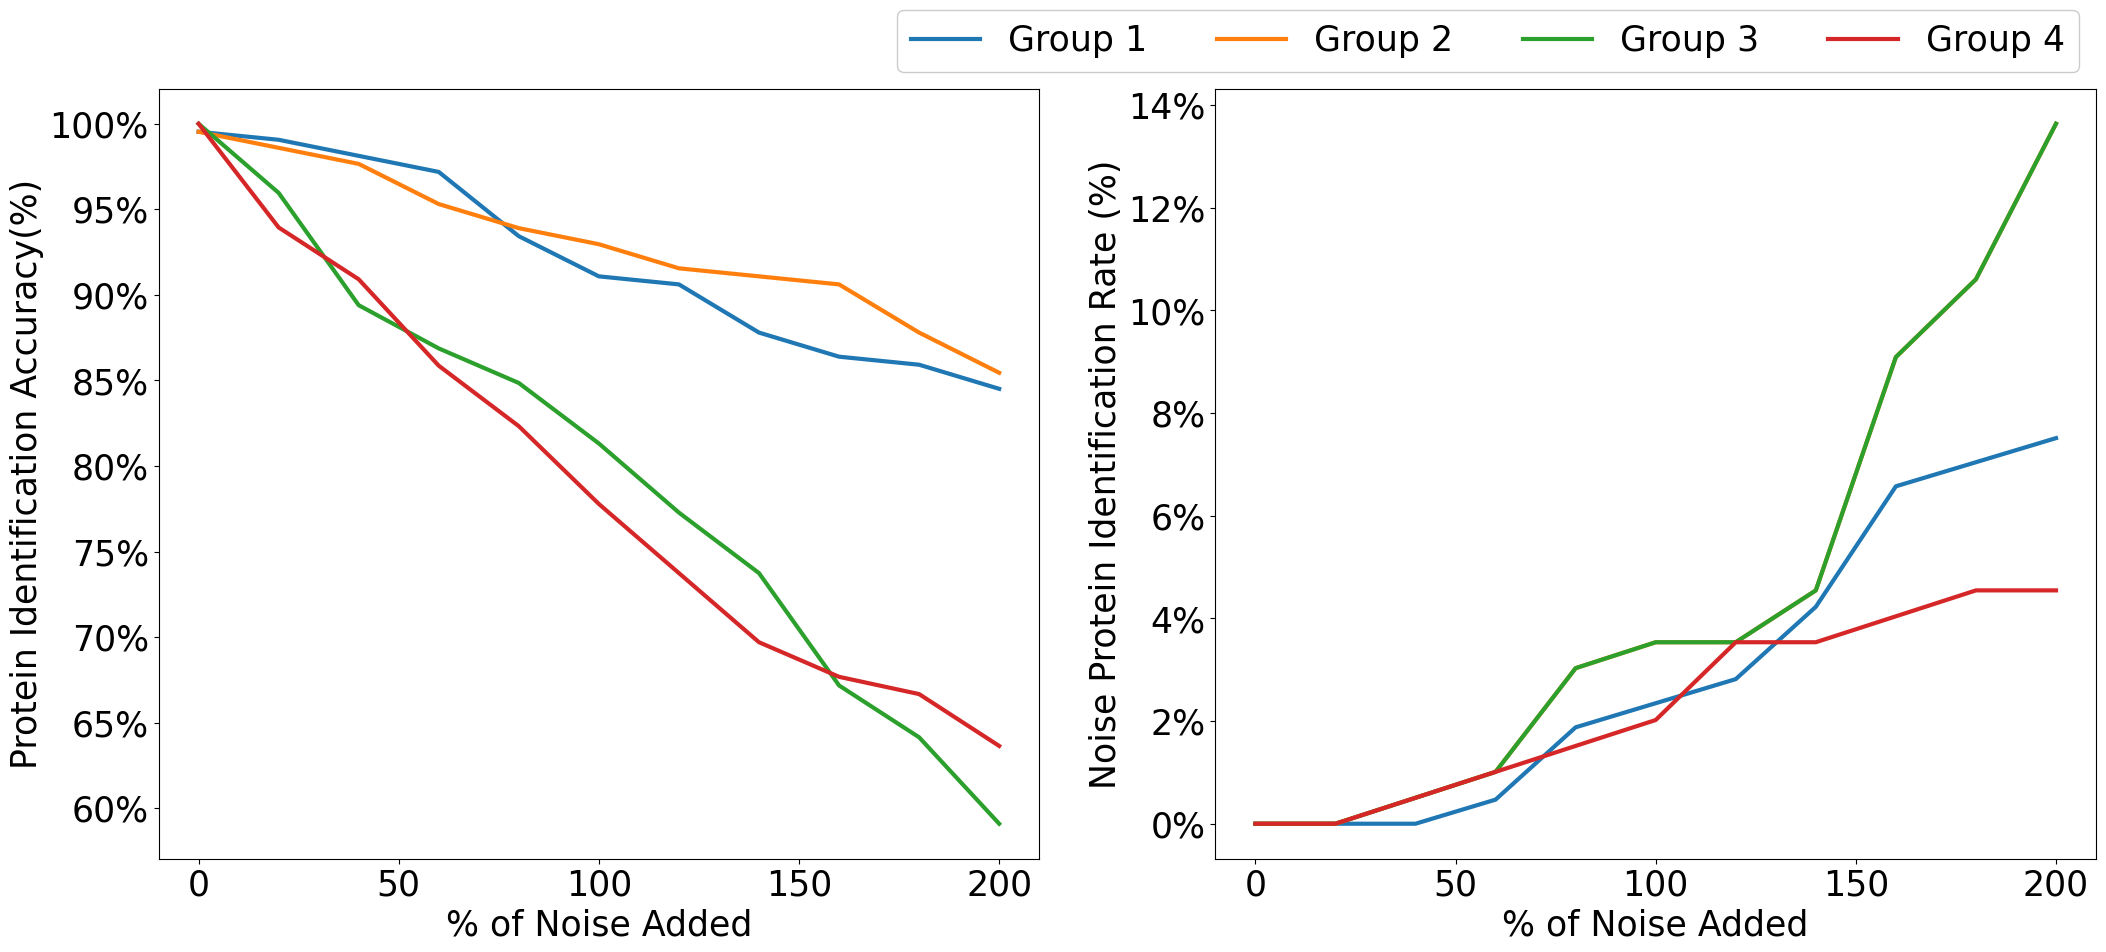

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

df = pd.DataFrame()

df["% of Noise Added"] = range(0, 210, 20)
# df["# of PrSMs"] = r2
# df["Accuracy"] = r2a
# df["False"] = r2b
df["# of PrSMs g0"] = r2g0
df["Accuracy g0"] = r2ag0
df["False g0"] = r2bg0
df["# of PrSMs g1"] = r2g1
df["Accuracy g1"] = r2ag1
df["False g1"] = r2bg1
df["# of PrSMs g2"] = r2g2
df["Accuracy g2"] = r2ag2
df["False g2"] = r2bg2
df["# of PrSMs g3"] = r2g3
df["Accuracy g3"] = r2ag3
df["False g3"] = r2bg3

df.to_csv("data.tsv", sep="\t")

plt.rcParams.update({'font.size': 25})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# sns.lineplot(data=df, x="% of Noise Added", y="# of PrSMs g0", ax=ax0, linewidth=3)
# sns.lineplot(data=df, x="% of Noise Added", y="# of PrSMs g1", ax=ax0, linewidth=3)
# sns.lineplot(data=df, x="% of Noise Added", y="# of PrSMs g2", ax=ax0, linewidth=3)
# sns.lineplot(data=df, x="% of Noise Added", y="# of PrSMs g3", ax=ax0, linewidth=3)

# ax0.set_ylabel('# of PrSMs with Correct Protein Identification')
# ax0.legend()

sns.lineplot(data=df, x="% of Noise Added", y="Accuracy g0", ax=ax1, linewidth=3)
sns.lineplot(data=df, x="% of Noise Added", y="Accuracy g1", ax=ax1, linewidth=3)
sns.lineplot(data=df, x="% of Noise Added", y="Accuracy g2", ax=ax1, linewidth=3)
sns.lineplot(data=df, x="% of Noise Added", y="Accuracy g3", ax=ax1, linewidth=3)

ax1.set_ylabel('Protein Identification Accuracy(%)')
# ax1.legend()

ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

sns.lineplot(data=df, x="% of Noise Added", y="False g0", ax=ax2, label="Group 1", linewidth=3)
sns.lineplot(data=df, x="% of Noise Added", y="False g1", ax=ax2, label="Group 2", linewidth=3)
sns.lineplot(data=df, x="% of Noise Added", y="False g2", ax=ax2, label="Group 3", linewidth=3)
sns.lineplot(data=df, x="% of Noise Added", y="False g3", ax=ax2, label="Group 4", linewidth=3)

ax2.set_ylabel('Noise Protein Identification Rate (%)')
# ax2.legend()

ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# fig.suptitle('Group 3')
sns.move_legend(ax2, loc='upper right', fancybox=True, framealpha=1, bbox_to_anchor=(1, 1.125), ncol = 4)
plt.savefig("noise.png", dpi=800, format="png")
plt.savefig("noise.svg", dpi=800, format="svg")
plt.show()

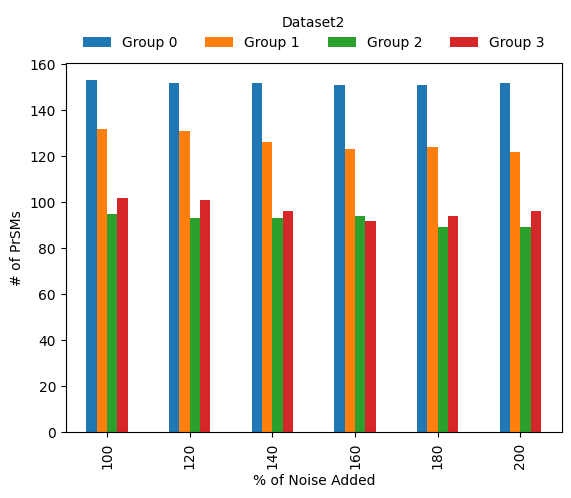

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({'Group 0': r2g0,
                   'Group 1': r2g1,
                   'Group 2': r2g2,
                   'Group 3': r2g3},
                  index=range(100, 210, 20))

df.plot(kind='bar')
 
# labels for x & y axis
plt.xlabel('% of Noise Added')
plt.ylabel('# of PrSMs')

ax = plt.gca()

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title="Dataset2", frameon=False,
)

plt.savefig("noisegroups2.png")

In [9]:
import pandas as pd
import read_msalign

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/Result_resolved.tsv", sep="\t", index_col=0)

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved2_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

spec_list_1 = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved1_ms2.msalign")
spec_list_2 = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved2_ms2.msalign")

pairs = df["Pair"].tolist()

access1 = {}
for pair in pairs:
    for spec in spec_list_1:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == eval(pair):
            access1[pair] = int(spec.header.spec_scan)

access2 = {}
for pair in pairs:
    for spec in spec_list_2:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == eval(pair):
            access2[pair] = int(spec.header.spec_scan)

{'frozenset({1730, 2070})': 1730, 'frozenset({1937, 10158})': 1937, 'frozenset({2512, 2031})': 2031, 'frozenset({1754, 2139})': 1754, 'frozenset({8121, 2218})': 2218, 'frozenset({2229, 3183})': 2229, 'frozenset({2232, 2124})': 2232, 'frozenset({2237, 3183})': 2237, 'frozenset({2240, 9402})': 2240, 'frozenset({2124, 2253})': 2253, 'frozenset({9402, 2299})': 2299, 'frozenset({9402, 2301})': 2301, 'frozenset({9402, 2306})': 2306, 'frozenset({2314, 9414})': 2314, 'frozenset({2330, 9414})': 2330, 'frozenset({2345, 2223})': 2223, 'frozenset({2348, 4436})': 2348, 'frozenset({7602, 2363})': 2363, 'frozenset({6115, 2374})': 6115, 'frozenset({4436, 2390})': 2390, 'frozenset({9402, 2398})': 2398, 'frozenset({2425, 9402})': 2425, 'frozenset({2426, 8275})': 2426, 'frozenset({2432, 9402})': 2432, 'frozenset({2573, 2462})': 2462, 'frozenset({8275, 2467})': 2467, 'frozenset({2488, 9414})': 2488, 'frozenset({2504, 9402})': 2504, 'frozenset({8275, 2519})': 2519, 'frozenset({9402, 2530})': 2530, 'frozens

In [17]:
Evalue1 = []
for pair in pairs:
    print(r2[r2["Scan(s)"] == access2[pair]].iloc[0]["E-value"], pair)

1.170382e-08 frozenset({1730, 2070})
1.1129862e-08 frozenset({1937, 10158})
2.26448e-06 frozenset({2512, 2031})
4.05662e-09 frozenset({1754, 2139})
1.00042e-06 frozenset({8121, 2218})
1.862245e-09 frozenset({2229, 3183})
1.61771665e-11 frozenset({2232, 2124})
3.753145e-09 frozenset({2237, 3183})
2.628e-06 frozenset({2240, 9402})
4.5451167e-12 frozenset({2124, 2253})
1.05014e-06 frozenset({9402, 2299})
1.07976e-06 frozenset({9402, 2301})
3.429e-07 frozenset({9402, 2306})
6.036662e-05 frozenset({2314, 9414})
5.8555e-05 frozenset({2330, 9414})
1.129434e-10 frozenset({2345, 2223})
3.6418e-05 frozenset({2348, 4436})
2.945106e-07 frozenset({7602, 2363})
0.0005540252 frozenset({6115, 2374})
8.1148e-06 frozenset({4436, 2390})
1.28706e-06 frozenset({9402, 2398})
2.8968e-08 frozenset({2425, 9402})
0.000129514 frozenset({2426, 8275})
1.71008e-07 frozenset({2432, 9402})
1.063658e-05 frozenset({2573, 2462})
8.36418e-05 frozenset({8275, 2467})
7.39732101e-06 frozenset({2488, 9414})
4.942e-07 frozens

IndexError: single positional indexer is out-of-bounds

In [1]:
import pandas as pd
import read_msalign

result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/Result_resolved.tsv", sep="\t", index_col=0)

result_a = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved1_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
result_b = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved2_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)

pairs = result["Pair"].tolist()

a_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved1_ms2.msalign")
b_spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/resolved2_ms2.msalign")

accessA = {}
for pair in pairs:
    for spec in a_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == eval(pair):
            accessA[pair] = spec.header.spec_scan

accessB = {}
for pair in pairs:
    for spec in b_spec_list:
        if frozenset((spec.header.spec_scan % 100000, int(spec.header.title) % 100000)) == eval(pair):
            accessB[pair] = spec.header.spec_scan

Evalue1 = []
Evalue2 = []
for pair in pairs:
    if result[result["Pair"] == pair].iloc[0]["choice"] == "A":
        Evalue1.append(result_a[result_a["Scan(s)"] == accessA[pair]].iloc[0]["E-value"])
        Evalue2.append(result_b[result_b["Scan(s)"] == accessA[pair]].iloc[0]["E-value"])
    else:
        Evalue1.append(result_a[result_a["Scan(s)"] == accessB[pair]].iloc[0]["E-value"])
        Evalue2.append(result_b[result_b["Scan(s)"] == accessB[pair]].iloc[0]["E-value"])

result["E-value1"] = Evalue1
result["E-value2"] = Evalue2


In [2]:
import numpy as np
result["LoggedDifference1"] = np.where(result["choice"] == "A", np.log(result["E-value1"]) - np.log(result["A+B_1 E-value"]), np.log(result["E-value1"]) - np.log(result["B+A_1 E-value"]))
result["LoggedDifference2"] = np.where(result["choice"] == "A", np.log(result["E-value2"]) - np.log(result["A+B_2 E-value"]), np.log(result["E-value2"]) - np.log(result["B+A_2 E-value"]))
display(result[result["LoggedDifference1"] > 0])
display(result[result["LoggedDifference2"] > 0])

,Pair,A+B_1,A+B_1 peaks,A+B_1 E-value,A+B_2,A+B_2 peaks,A+B_2 E-value,B+A_1,B+A_1 peaks,B+A_1 E-value,B+A_2,B+A_2 peaks,B+A_2 E-value,choice,E-value1,E-value2,LoggedDifference1,LoggedDifference2


,Pair,A+B_1,A+B_1 peaks,A+B_1 E-value,A+B_2,A+B_2 peaks,A+B_2 E-value,B+A_1,B+A_1 peaks,B+A_1 E-value,B+A_2,B+A_2 peaks,B+A_2 E-value,choice,E-value1,E-value2,LoggedDifference1,LoggedDifference2
92,"frozenset({7304, 3986})",B,20,1.040755e+00,DECOY,5,55.216049,B,15,0.000001,C,7,1.492240e+00,A,4.442953e-03,1.000000e+300,-5.456382,686.764274
93,"frozenset({7304, 3993})",B,23,8.655435e-01,DECOY,5,87.501731,B,15,0.000005,C,8,1.089040e+00,A,9.315608e-02,1.000000e+300,-2.229081,686.303869
346,"frozenset({9651, 2374})",A,22,5.663328e-04,C,6,0.703922,DECOY,5,3.599487,A,22,3.406032e-04,A,2.915141e-05,6.525186e+00,-2.966679,2.226757
458,"frozenset({5524, 2374})",A,37,1.736502e-12,DECOY,7,706.699320,-,0,1.000000,A,23,1.160500e-06,A,5.045600e-14,1.000000e+300,-3.538527,684.214923
655,"frozenset({10412, 6164})",A,39,6.953040e-12,DECOY,6,51.831440,-,0,1.000000,A,27,6.438420e-07,A,1.016442e-12,1.276778e+02,-1.922871,0.901513


In [8]:
display(result[(result["LoggedDifference2"] < result["LoggedDifference1"]) & (result["LoggedDifference1"] > -5)])


,Pair,A+B_1,A+B_1 peaks,A+B_1 E-value,A+B_2,A+B_2 peaks,A+B_2 E-value,B+A_1,B+A_1 peaks,B+A_1 E-value,B+A_2,B+A_2 peaks,B+A_2 E-value,choice,E-value1,E-value2,LoggedDifference1,LoggedDifference2
0,"frozenset({1730, 2070})",A,12,1.221761e-07,B,8,3.818720e-07,B,8,1.499648e-06,A,12,1.221761e-07,A,8.429419e-08,6.797890e-08,-0.371151,-1.725888
1,"frozenset({1937, 10158})",A,35,5.540780e-17,B,13,1.007913e-06,-,0,1.000000e+00,A,15,2.532557e-08,A,3.026608e-17,3.323386e-09,-0.604693,-5.714653
2,"frozenset({2512, 2031})",A,19,2.280401e-12,B,7,2.109440e-05,B,7,4.607200e-04,A,19,1.894875e-12,A,9.749559e-13,1.125872e-06,-0.849714,-2.930450
3,"frozenset({1754, 2139})",A,8,8.560010e-07,B,7,1.934460e-09,B,7,4.305960e-09,A,8,7.965320e-08,B,1.199250e-09,1.095124e-08,-1.278304,-1.984230
4,"frozenset({8121, 2218})",A,38,1.350135e-20,B,6,4.344800e-04,-,0,1.000000e+00,A,26,1.239046e-11,A,2.119774e-21,1.576900e-06,-1.851480,-5.618689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,"frozenset({11260, 5254})",A,45,1.359072e-11,B,9,3.338000e-05,B,9,1.477540e-04,A,45,4.618891e-12,A,9.855120e-13,2.254577e-07,-2.623981,-4.997580
1319,"frozenset({5120, 2607})",A,62,2.486405e-15,B,12,3.558400e-06,-,0,1.000000e+00,A,45,9.060480e-10,A,1.001299e-16,1.112920e-08,-3.212125,-5.767494
1320,"frozenset({3090, 5127})",A,70,4.554792e-17,B,11,2.388800e-04,-,0,1.000000e+00,A,49,3.974731e-11,A,1.808717e-18,3.613400e-07,-3.226147,-6.493897
1321,"frozenset({5242, 11260})",A,57,4.691227e-14,B,7,9.100400e-04,-,0,1.000000e+00,A,42,7.730448e-09,A,7.520832e-15,1.771160e-06,-1.830603,-6.241854


<Figure size 640x480 with 0 Axes>

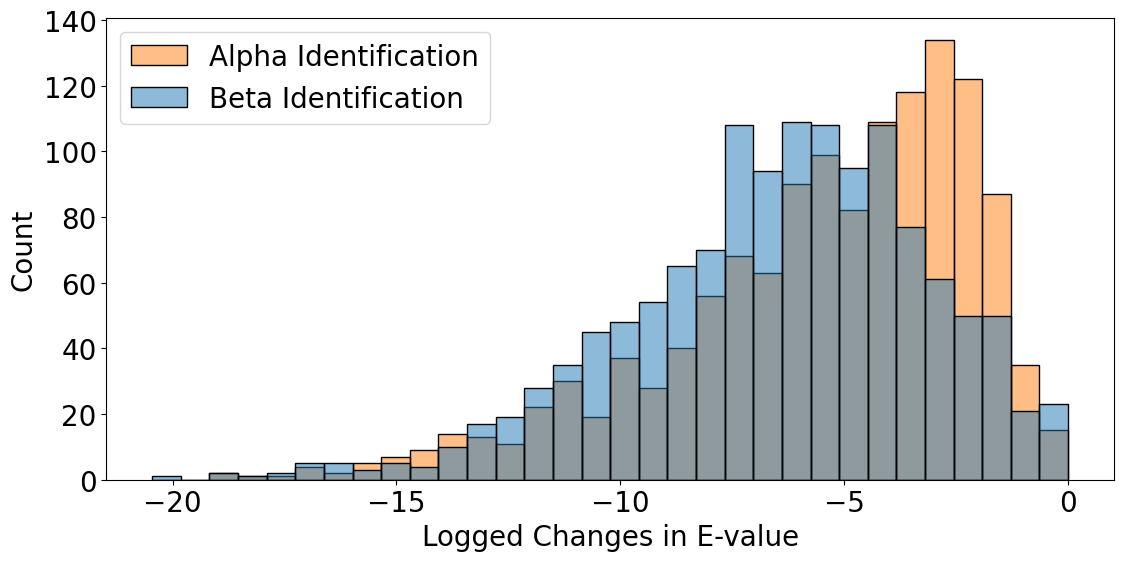

In [9]:
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

plt.clf()
result[result["LoggedDifference1"] > 0] = 0
result[result["LoggedDifference2"] > 0] = 0
differences1 = result["LoggedDifference1"].tolist()
differences2 = result["LoggedDifference2"].tolist()
plt.figure(figsize=(13,6))
plt.rcParams.update({'font.size': 20})
sns.histplot([differences2, differences1])
plt.xlabel("Logged Changes in E-value")
plt.legend(["Alpha Identification", "Beta Identification"])

[0.1738410334124683,
 0.4400850616058671,
 0.09366420207443318,
 0.2924097029072314]

2.1007552922620834

3.2212004001657197

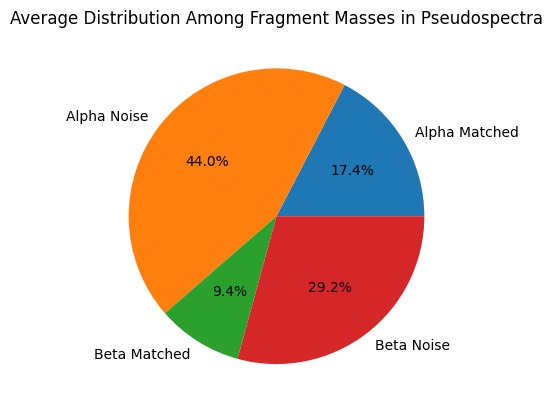

In [28]:
import read_msalign
import pandas as pd
from statistics import mean 
import matplotlib.pyplot as plt

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/Simulation5/Keep_Decoy/temp_ms2_modified.msalign")

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", sep="\t")

amatch = []
anon = []
bmatch = []
bnon = []
for spec in spec_list:
    ascan = int(spec.header.spec_scan) % 100000
    bscan = int(spec.header.title) % 100000
    atotal = int(df[df["Scan(s)"] == ascan].iloc[0]["#peaks"])
    a = int(df[df["Scan(s)"] == ascan].iloc[0]["#matched peaks"])
    btotal = int(df[df["Scan(s)"] == bscan].iloc[0]["#peaks"])
    b = int(df[df["Scan(s)"] == bscan].iloc[0]["#matched peaks"])

    total = atotal + btotal
    amatch.append(a / total)
    anon.append((atotal - a) / total)
    bmatch.append(b / total)
    bnon.append((btotal - b) / total)


list = [mean(amatch), mean(anon), mean(bmatch), mean(bnon)]
display(list)
mylabels = ["Alpha Matched", "Alpha Noise", "Beta Matched", "Beta Noise"]

plt.pie(list, labels=mylabels, autopct='%1.1f%%')
plt.title("Average Distribution Among Fragment Masses in Pseudospectra")

x = mean(amatch) / mean(bmatch)
y = (mean(anon) + mean(bnon)) / (x + 1)

display((mean(amatch) / (x*y)) / mean(amatch))
display((mean(bmatch) / y) / (mean(bmatch) / (1 - mean(amatch))))

plt.savefig("piechart.png", dpi=1200)

In [146]:

import sys
import pandas as pd
import numpy as np
import seaborn as sns
import read_msalign
import matplotlib.pyplot as plt

verifier = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

result1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationFDR1%/A_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
# result = result[result["E-value"] < 0.01]

result2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationFDR1%/B_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
result2["Scan(s)"] = result2["Scan(s)"] + 10000000

result = pd.concat([result1, result2], ignore_index=True)

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/A_ms2.msalign")
# spec_list2 = read_msalign.read_spec_file(dir + "resolved2_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in result.iterrows():
    result.loc[index, "Scan_real"] = int(row["Scan(s)"]) % 100000
    result.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"] % 10000000)].header.title) % 100000

# display(verifier)

verifiedResult = pd.merge(result,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan_real', right_on="Scan(s)", how='left', suffixes=("", "_True"))

joined = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_Other"))

joined["Verified_ProteinCorrect"] = "-"
joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_True"])
joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_Other"])

# joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
# joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01

# joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_True"]) < joined["proteoform_ppm"])
# joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_Other"]) < joined["proteoform_ppm"])

# # Correct protein for all
first = joined[joined["Scan(s)"] < 10000000]
second = joined[joined["Scan(s)"] > 10000000]

print(first[first["Verified_ProteinCorrect"] == True].shape[0])
print(first[(first["Protein accession"] == first["Protein accession_Other"]) & (first["Scan(s)"].isin(switchlist))].shape[0])

print(second[(second["Verified_ProteinCorrect"] == True) & (second["Scan(s)"].isin(switchlist))].shape[0])
# print(second[(second["Protein accession"] == second["Protein accession_True"]) & ].shape[0])


# #Correct protein for E-value < 0.01
# filtered = joined[joined["E-value"] < 0.01]
# filtered['pair'] = filtered.apply(lambda row: tuple(sorted((row['Scan_real'], row['Scan(other)']))), axis=1)
# # Step 2: Count the occurrences of each unique standardized pair
# pair_counts = filtered['pair'].value_counts()
# # Step 3: Determine how many unique pairs appeared once and how many appeared twice
# count_once = (pair_counts == 1).sum()
# count_twice = (pair_counts == 2).sum()
# print(f'Number of unique pairs that appeared once: {count_once}')
# print(f'Number of unique pairs that appeared twice: {count_twice}')
# filtered[filtered["Verified_ProteinCorrect"]]


722
0
0


725
725
Combination Counts:
 combination
Both identifications are reported      607
Only one identification is reported    116
No identifications are reported          2
Name: count, dtype: int64


<Figure size 1200x800 with 0 Axes>

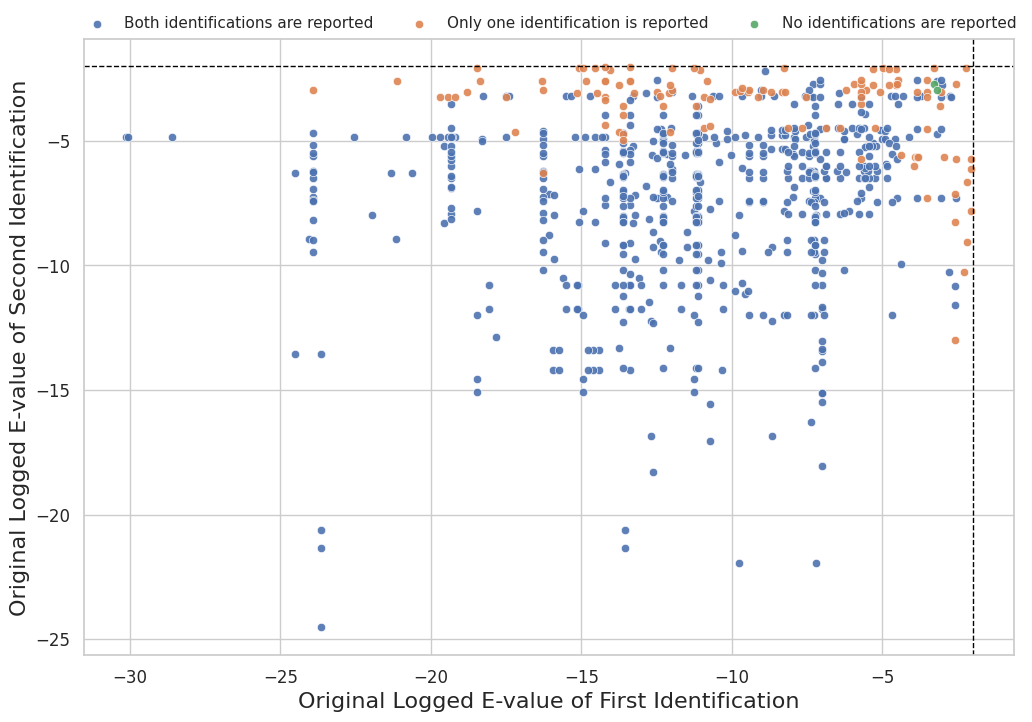

In [8]:

import sys
import pandas as pd
import numpy as np
import seaborn as sns
import read_msalign
import matplotlib.pyplot as plt

verifier = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

result1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/A_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
# result = result[result["E-value"] < 0.01]

result2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/SecondPrSM_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
result2["Scan(s)"] = result2["Scan(s)"] + 10000000

result = pd.concat([result1, result2], ignore_index=True)

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/A_ms2.msalign")
# spec_list2 = read_msalign.read_spec_file(dir + "resolved2_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in result.iterrows():
    result.loc[index, "Scan_real"] = int(row["Scan(s)"]) % 100000
    result.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"] % 10000000)].header.title) % 100000

# display(verifier)

verifiedResult = pd.merge(result,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan_real', right_on="Scan(s)", how='left', suffixes=("", "_True"))

joined = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_Other"))

joined["Verified_ProteinCorrect"] = "-"
joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_True"])
joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_Other"])

# joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
# joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01

# joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_True"]) < joined["proteoform_ppm"])
# joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_Other"]) < joined["proteoform_ppm"])

# # Correct protein for all
# joined[joined["Verified_ProteinCorrect"] == True]

# #Correct protein for E-value < 0.01
# filtered = joined[joined["E-value"] < 0.01]
# filtered['pair'] = filtered.apply(lambda row: tuple(sorted((row['Scan_real'], row['Scan(other)']))), axis=1)
# # Step 2: Count the occurrences of each unique standardized pair
# pair_counts = filtered['pair'].value_counts()
# # Step 3: Determine how many unique pairs appeared once and how many appeared twice
# count_once = (pair_counts == 1).sum()
# count_twice = (pair_counts == 2).sum()
# print(f'Number of unique pairs that appeared once: {count_once}')
# print(f'Number of unique pairs that appeared twice: {count_twice}')
# filtered[filtered["Verified_ProteinCorrect"]]


#Graph for simulation data
joined.loc[(joined["Scan(s)"] < 10000000), "Logged E-value"] = np.log10(joined["E-value_True"])
joined.loc[(joined["Scan(s)"] > 10000000), "Logged E-value"] = np.log10(joined["E-value_Other"])

df_x = joined[joined['Scan(s)'] < 10000000].reset_index(drop=True)
df_y = joined[joined['Scan(s)'] > 10000000].reset_index(drop=True)

print(df_x.shape[0])
print(df_y.shape[0])

# Make sure both dataframes have the same number of rows for pairing
# min_length = min(len(df_x), len(df_y))
# df_x = df_x.iloc[:min_length]
# df_y = df_y.iloc[:min_length]

# Prepare the scatter plot data
scatter_data = pd.DataFrame({
    'x': df_x['Logged E-value'],
    'y': df_y['Logged E-value'],
    'scan1': df_x["Scan_real"],
    'scan2': df_y["Scan(other)"],
    'boolean_x': df_x['E-value'] < 0.01,
    'boolean_y': df_y['E-value'] < 0.01
})



# Define color mapping based on boolean pairs
scatter_data['combination'] = scatter_data.apply(lambda row: 
                                                 'Both identifications are reported' if row['boolean_x'] and row['boolean_y'] else
                                                 'Only one identification is reported' if row['boolean_x'] or row['boolean_y'] else
                                                 'No identifications are reported', axis=1)

scatter_data.to_csv("data.tsv", sep="\t")

sns.set(style='whitegrid')

# Plotting the scatter plot
plt.figure(figsize=(12, 8))

# Print the count of each combination
print("Combination Counts:\n", scatter_data['combination'].value_counts())

# Adding transparency for clarity
plt.figure(figsize=(12, 8))
sns.scatterplot(data=scatter_data[scatter_data['combination'] == 'Both identifications are reported'], 
                x='x', y='y', label='Both identifications are reported', alpha=0.9)

sns.scatterplot(data=scatter_data[scatter_data['combination'] == 'Only one identification is reported'], 
                x='x', y='y', label='Only one identification is reported', alpha=0.9)

sns.scatterplot(data=scatter_data[scatter_data['combination'] == 'No identifications are reported'], 
                x='x', y='y', label='No identifications are reported', alpha=0.9)

# Customize plot
plt.xlabel('Original Logged E-value of First Identification', fontsize=16)
plt.ylabel('Original Logged E-value of Second Identification', fontsize=16)

plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=3, frameon=False)

plt.axvline(x=-2, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-2, color='black', linestyle='--', linewidth=1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.suptitle('Reported Identifications under 0.01 E-value Cutoff', fontsize=20)

plt.savefig("sensitivity.png", dpi=800, format="png")
plt.savefig("sensitivity.svg", dpi=800, format="svg")

plt.show()

In [ ]:
import pandas as pd 

newproteoforms = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/New proteoforms.tsv", sep="\t")



In [32]:
import pandas as pd

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/Result_final.tsv", sep="\t")

def choose_columns(row):
    if row['choice'] == 'A':  # Check if the value in the fifth column is 'A'
        return pd.Series([row['A+B_1'], row['A+B_2'], row['choice']])  # Return the first two columns
    else:  # Otherwise, it must be 'B'
        return pd.Series([row['B+A_1'], row['B+A_2'], row["choice"]])  # Return the second two columns

# Apply the function to each row in the dataframe
result_df = df.apply(choose_columns, axis=1)

result_df.columns = ['Selected_Col1', 'Selected_Col2', "choice"]

# # Count the number of rows with "-" in either of the two selected columns
# rows_with_dash = result_df[(result_df['Selected_Col1'] == '-') | (result_df['Selected_Col2'] == '-')].shape[0]

# # Display the count
# rows_with_dash

def count_rows_based_on_third_column(df):
    count_A = df[(df['choice'] == 'A') & (~(df['Selected_Col1'] == 'A') | ~(df['Selected_Col2'] == 'B'))]
    count_B = df[(df['choice'] == 'B') & (~(df['Selected_Col1'] == 'B') | ~(df['Selected_Col2'] == 'A'))]
    return count_A, count_B

# Get the counts
count_A, count_B = count_rows_based_on_third_column(result_df)

count_A, count_B

# result_df[(result_df['choice'] == 'B') & ~(result_df['Selected_Col1'] == 'B') | ~(result_df['Selected_Col2'] == 'A')]

(    Selected_Col1 Selected_Col2 choice
 89              A             C      A
 93              A             C      A
 146             A             C      A
 147             A             C      A
 157             A             C      A
 159             A             C      A
 188             A             C      A
 193             A             C      A
 207             A             C      A
 266             A             C      A
 315             A             C      A
 415             A             C      A
 426             A             C      A
 579             A             C      A
 594             A             C      A,
     Selected_Col1 Selected_Col2 choice
 265             C             A      B
 295             A             A      B)

In [35]:
import pandas as pd

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/Result_final.tsv", sep="\t")

def choose_columns(row):
    if row['choice'] == 'A':  # Check if the value in the fifth column is 'A'
        if (row["A+B_1 E-value"] < 0.01) & (row["A+B_2 E-value"] < 0.01):
            return pd.Series([row['A+B_1'], row["A+B_1 E-value"], row['A+B_2'], row["A+B_2 E-value"], row['choice']])  # Return the first two columns
        elif (row["A+B_1 E-value"] >= 0.01) & (row["A+B_2 E-value"] < 0.01):
            return pd.Series(["-", 1, row['A+B_2'], row["A+B_2 E-value"], row['choice']])
        elif (row["A+B_1 E-value"] < 0.01) & (row["A+B_2 E-value"] >= 0.01):
            return pd.Series([row['A+B_1'], row["A+B_1 E-value"], "-", 1, row['choice']])
        else:
            return pd.Series(["-", 1, "-", 1, row['choice']])
    else:  # Otherwise, it must be 'B'
        if (row["B+A_1 E-value"] < 0.01) & (row["B+A_2 E-value"] < 0.01):
            return pd.Series([row['B+A_1'], row["B+A_1 E-value"], row['B+A_2'], row["B+A_2 E-value"], row['choice']])  # Return the first two columns
        elif (row["B+A_1 E-value"] >= 0.01) & (row["B+A_2 E-value"] < 0.01):
            return pd.Series(["-", 1, row['B+A_2'], row["B+A_2 E-value"], row['choice']])
        elif (row["B+A_1 E-value"] < 0.01) & (row["B+A_2 E-value"] >= 0.01):
            return pd.Series([row['B+A_1'], row["B+A_1 E-value"], "-", 1, row['choice']])
        else:
            return pd.Series(["-", 1, "-", 1, row['choice']])

# Apply the function to each row in the dataframe
result_df = df.apply(choose_columns, axis=1)

result_df.columns = ['Protein 1', "E-value 1", 'Protein 2', "E-value 2", "choice"]

result_df

# # Count the number of rows with "-" in either of the two selected columns
# rows_with_dash = result_df[(result_df['Protein 1'] == '-') | (result_df['Protein 2'] == '-')].shape[0]

# # Display the count
# rows_with_dash

def count_rows_based_on_third_column(df):
    count_A = df[(df['choice'] == 'A') & ((~(df['Protein 1'] == 'A') & ~(df["Protein 1"] == "-"))| (~(df['Protein 2'] == 'B') & ~(df["Protein 2"] == "-")))]
    count_B = df[(df['choice'] == 'B') & ((~(df['Protein 1'] == 'B') & ~(df["Protein 1"] == "-"))| (~(df['Protein 2'] == 'A') & ~(df["Protein 2"] == "-")))]
    return count_A, count_B

# Get the counts
count_A, count_B = count_rows_based_on_third_column(result_df)

count_A, count_B


(Empty DataFrame
 Columns: [Protein 1, E-value 1, Protein 2, E-value 2, choice]
 Index: [],
 Empty DataFrame
 Columns: [Protein 1, E-value 1, Protein 2, E-value 2, choice]
 Index: [])

In [53]:
import pandas as pd
import numpy as np

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/Result_final.tsv", sep="\t")
result1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/resolved1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)
result2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/resolved2_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)


filteredA = df[(~(df["A+B_1"] == "-") & ~(df["A+B_2"] == "-") & (df["choice"] == "A"))][["Scan", "A+B_1", "A+B_1_mass", "A+B_1 E-value"]].rename(columns={'A+B_1': 'Old Protein', 'A+B_1 E-value': 'Old E-value', "A+B_1_mass": "Old Mass"})
filteredB = df[(~(df["B+A_1"] == "-") & ~(df["B+A_2"] == "-") & (df["choice"] == "B"))][["Scan", "B+A_1", "B+A_1_mass", "B+A_1 E-value"]].rename(columns={'B+A_1': 'Old Protein', 'B+A_1 E-value': 'Old E-value', "B+A_1_mass": "Old Mass"})

filtered = pd.concat([filteredA, filteredB])
joined = filtered.merge(result, left_on="Scan", right_on="Scan(s)", how="inner")

joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01


joined["Verified_ProteinCorrect"] = (joined["Old Protein"] == joined["Protein accession"])
joined["ppm difference"] = abs(joined["Proteoform mass"] - joined["Old Mass"])
joined["Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (joined["ppm difference"] < joined["proteoform_ppm"])

joined[(joined["Old E-value"] >= 0.01)]
# joined["E-value improvement"] = np.log10(joined["Old E-value"] - joined["E-value"])
# joined[~(joined["Old Protein"] == joined["Protein accession"])]

,Scan,Old Protein,Old Mass,Old E-value,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
865,2181,sp|P28904|TREC_ECOLI,9107.359053,0.021775,/home/daniel/Desktop/datafiles/RealData/ecoli/...,70,2181,HCD,2181,1688.09,...,0,NaN,0,NaN,-,4,6,0.004569,-,-


,Scan,Old Protein,Old Mass,Old E-value,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,...,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value,proteoform_ppm,Verified_ProteinCorrect,ppm difference,Verified_ProteoformCorrect
9,2296,sp|P0A850|TIG_ECOLI,3914.114666,0.011411,/home/daniel/Desktop/datafiles/RealData/ecoli/...,103,2296,HCD,2296,1777.81,...,-,7,7,0.005134,-,-,0.039141,True,0.0,True
41,2801,sp|P64503|YEBV_ECOLI,8761.406630,0.010711,/home/daniel/Desktop/datafiles/RealData/ecoli/...,211,2801,HCD,2801,2170.28,...,-,6,5,0.000333,-,-,0.087614,True,0.0,True
47,3504,sp|P0ADU5|YGIW_ECOLI,11968.987350,0.017851,/home/daniel/Desktop/datafiles/RealData/ecoli/...,306,3504,HCD,3504,2720.78,...,-,7,6,0.007416,-,-,0.119690,True,0.0,True
65,3868,sp|P0A8G6|NQOR_ECOLI,20716.924340,0.030035,/home/daniel/Desktop/datafiles/RealData/ecoli/...,358,3868,HCD,3868,3006.63,...,-,9,7,0.007786,-,-,0.207169,True,0.0,True
139,4165,sp|P68066|GRCA_ECOLI,14307.430000,0.012648,/home/daniel/Desktop/datafiles/RealData/ecoli/...,502,4165,HCD,4165,3238.33,...,-,12,13,0.004763,-,-,0.143074,True,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,10164,sp|P68066|GRCA_ECOLI,14322.411510,0.026158,/home/daniel/Desktop/datafiles/RealData/ecoli/...,1881,10164,HCD,10164,7845.44,...,-,9,8,0.005021,-,-,0.143224,True,0.0,True
1274,10967,sp|P68206|YJBJ_ECOLI,8336.307340,0.010584,/home/daniel/Desktop/datafiles/RealData/ecoli/...,1924,10967,HCD,10967,8466.79,...,-,5,5,0.001465,-,-,0.083363,True,0.0,True
1279,11597,sp|P68066|GRCA_ECOLI,14323.413300,0.017458,/home/daniel/Desktop/datafiles/RealData/ecoli/...,1949,11597,HCD,11597,8955.24,...,-,7,7,0.005611,-,-,0.143234,True,0.0,True
1280,11631,sp|P0A6F9|CH10_ECOLI,10378.569670,0.049928,/home/daniel/Desktop/datafiles/RealData/ecoli/...,1958,11631,HCD,11631,8982.31,...,-,5,5,0.003473,-,-,0.103786,True,0.0,True


In [ ]:
import pandas as pd
import read_msalign

result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/resolved2_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

filter = result['Protein accession'].str.contains("DECOY")
filtered_df = result[~filter]

def getMatchedPeaks(prsmID, dir, spec):
    with open(dir + "prsm" + str(prsmID) + ".js") as file:
        file.readline()
        toppic = json.loads(file.read())
        peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
        matched_list = []
        nonmatched_list = []
        if len(spec.peak_list) == 1:
            matched_list.append(copy.deepcopy(spec.peak_list[0]))
        else:
            for idx in range(0, len(peak_list)):
                if "matched_ions" in peak_list[idx]:
                    matched_list.append(copy.deepcopy(spec.peak_list[idx]))
                else:
                    nonmatched_list.append(copy.deepcopy(spec.peak_list[idx]))
        return matched_list, nonmatched_list
    
spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/resolved1_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec
    
for index, row in filtered_df.iterrows():
    scan = row["Scan(s)"]

    main_spec = (spec_dict[str(scan)])
    main_matchedList, nonMatchedList = getMatchedPeaks(result_a[result_a["Scan(s)"] == int(scan)].iloc[0]["Prsm ID"], a_dir, main_spec)

In [17]:
import read_msalign
import pandas as pd

# speclist1_6 = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/DDA_560_640_1micoscan/1.6.5/DDA_560_640_1microscan_ms2.msalign")
speclist1_7 = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/DDA_560_640_1micoscan/DDA_560_640_1microscan_ms2.msalign")

result1_6 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/DDA_560_640_1micoscan/1.6.5/DDA_560_640_1microscan_ms2_toppic_prsm_single.tsv", skiprows=29, sep="\t")
result1_7 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/DDA_560_640_1micoscan/DDA_560_640_1microscan_ms2_toppic_prsm_single.tsv", skiprows=29, sep="\t")

# spec_dict1_6 = {}
# for spec in speclist1_6:
#     spec_dict1_6[str(spec.header.spec_scan)] = spec

spec_dict1_7 = {}
for spec in speclist1_7:
    spec_dict1_7[str(spec.header.spec_scan)] = spec

missingones = set(result1_6["Scan(s)"]).difference(set(result1_7["Scan(s)"]))

for scan in missingones:
    if int(result1_6[result1_6["Scan(s)"] == scan].iloc[0]["Charge"]) == spec_dict1_7

{4927,
 5416,
 5460,
 5485,
 5537,
 5641,
 5648,
 5654,
 5662,
 5687,
 5692,
 5729,
 5730,
 5835,
 5856,
 5857,
 6051,
 6062,
 6066,
 6084,
 6123,
 6130,
 6136,
 6153,
 6154,
 6199,
 6202,
 6205,
 6224,
 6335,
 6350,
 6615,
 6653,
 6698,
 6720,
 6768,
 6794,
 6811,
 6845,
 6891,
 7024,
 7032,
 7069,
 7075,
 7115,
 7127,
 7197,
 7201,
 7263,
 7329,
 7369,
 7395,
 7434,
 7438,
 7474,
 7526,
 7528,
 7577,
 7663,
 7670,
 7715,
 7756,
 7823,
 8004,
 8025,
 8130,
 8138,
 8161,
 8230,
 8239,
 8243,
 8382,
 8403,
 8415,
 8445,
 8452,
 8492,
 8512,
 8616,
 8651,
 8693,
 8775,
 8896,
 8959,
 8970,
 8985,
 9003,
 9033,
 9034,
 9049,
 9062,
 9068,
 9075,
 9078,
 9099,
 9121,
 9129,
 9131,
 9148,
 9153,
 9176,
 9191,
 9195,
 9218,
 9262,
 9267,
 9479,
 9544,
 9603,
 9615,
 9729,
 9730,
 9773,
 9779,
 9818,
 9827,
 9889,
 9926,
 9950,
 10022,
 10041,
 10044,
 10080,
 10137,
 10253,
 10274,
 10575,
 10602,
 10618,
 10620,
 10625,
 10777,
 10884,
 10975,
 10998,
 11003,
 11184,
 11199,
 11322,
 11372,

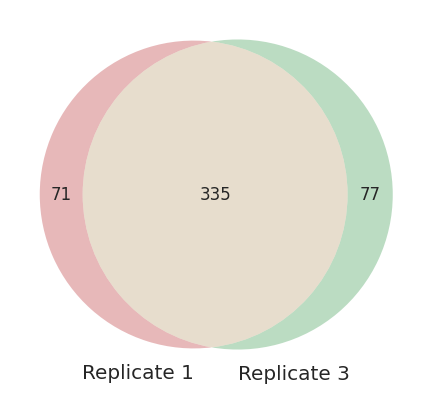

In [13]:
from matplotlib_venn import venn2

venn2(subsets=(71, 77, 335), set_labels=('Replicate 1', 'Replicate 3'))


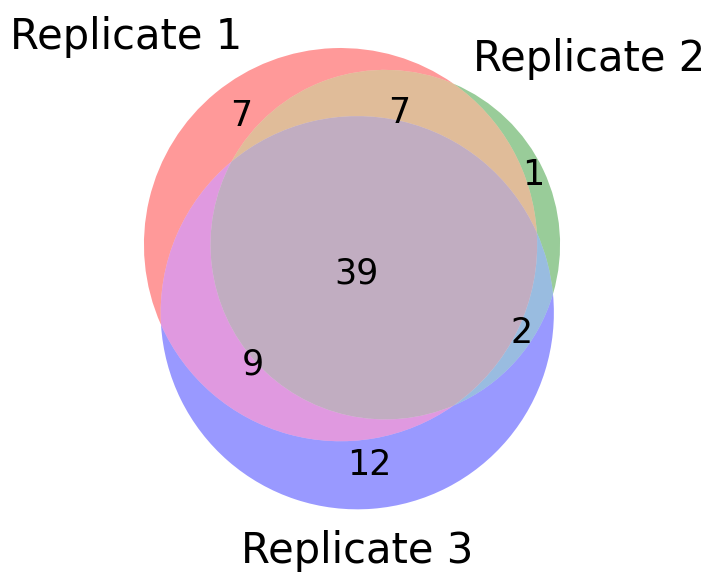

In [97]:
from matplotlib_venn import venn3

plt.figure(figsize=(11, 7))
venn3(subsets=(7, 1, 7, 12, 9, 2, 39),
        set_labels=('Replicate 1', 'Replicate 2', 'Replicate 3'))

plt.savefig("proteinoverlap.png", dpi=200)

In [10]:
import pandas as pd

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/resolved1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/resolved2_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

combined_df = pd.concat([r1, r2], ignore_index=True)

combined_df = combined_df[~combined_df['Protein accession'].str.contains('DECOY')]

combined_df["Multiplexed"] = combined_df.groupby("Scan(s)")["Scan(s)"].transform("size")

combined_df[(combined_df["Data file name"] == "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/resolved2_ms2.msalign") & combined_df["Multiplexed"] == 1]

# group_sizes = combined_df.groupby('Scan(s)').size()

# # Count the frequency of each group size
# group_size_counts = group_sizes.value_counts().sort_index()

# print(group_size_counts)


,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value,Multiplexed
2087,/home/daniel/Desktop/datafiles/RealData/ecoli/...,3,2665,HCD,2665,2064.01,12,5,4109.00007,4108.95507,...,-1.0128:[9-10],0,NaN,-,5,5,0.038799,0.009434,0.017857,1
2088,/home/daniel/Desktop/datafiles/RealData/ecoli/...,4,2950,HCD,2950,2287.40,25,8,8745.23843,8745.18343,...,-116.0523:[42-43],0,NaN,-,10,7,0.000005,0.000000,0.000000,1
2093,/home/daniel/Desktop/datafiles/RealData/ecoli/...,9,4184,HCD,4184,3253.67,74,12,12386.38120,12387.29355,...,-24.0369:[42-92],0,NaN,-,11,11,0.000235,0.000000,0.000000,1
2102,/home/daniel/Desktop/datafiles/RealData/ecoli/...,18,4702,HCD,4702,3658.39,192,18,14228.62638,14229.55873,...,+382.3628:[103-121],0,NaN,-,26,19,0.042613,0.009009,0.016949,1
2105,/home/daniel/Desktop/datafiles/RealData/ecoli/...,21,4831,HCD,4831,3757.84,162,16,15352.85478,15353.74713,...,-26.0274:[70-72],0,NaN,-,21,15,0.001948,0.000000,0.000000,1


In [45]:
import pandas as pd

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/resolved1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/resolved2_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

result = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/Result_final.tsv", sep="\t")
newproteoforms = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/newproteoforms.tsv", sep="\t")

# Concatenate two proteoform files
combined_df = pd.concat([r1, r2], ignore_index=True)

combined_df = combined_df[~combined_df['Protein accession'].str.contains('DECOY')]

combined_df["Multiplexed"] = combined_df.groupby("Scan(s)")["Scan(s)"].transform("size")

combined_df = combined_df.merge(result, left_on="Scan(s)", right_on="Scan", how="left")

finalresult = newproteoforms.merge(combined_df, on=["Scan(s)", "Precursor mass"], how="inner")

finalresult.to_csv("result.tsv", sep="\t")


In [59]:
import pandas as pd

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/merged_results.csv", sep="\t")
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_2_MSDeplex/merged_results.csv", sep="\t")
r3 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_3_MSDeplex/merged_results.csv", sep="\t")

r1 = r1[~r1['Protein accession'].str.contains('DECOY')]
r2 = r2[~r2['Protein accession'].str.contains('DECOY')]
r3 = r3[~r3['Protein accession'].str.contains('DECOY')]

r1["Origin"] = 1
r2["Origin"] = 2
r3["Origin"] = 3

combined = pd.concat([r1, r2, r3], ignore_index=True)

combined.sort_values(by="E-value")

combined["1"] = combined["Origin"] == 1
combined["2"] = combined["Origin"] == 2
combined["3"] = combined["Origin"] == 3

resultlist = pd.DataFrame(columns=combined.columns).astype(combined.dtypes)

for i, row in combined.iterrows():
    is_duplicate = False
    for j, result in resultlist.iterrows():
        if row['Protein accession'] == result['Protein accession'] and abs(row['Precursor mass'] - result['Precursor mass']) < 1.2:
            if row["Origin"] == 1:
                resultlist.loc[j, "1"] = True
            elif row["Origin"] == 2:
                resultlist.loc[j, "2"] = True
            elif row["Origin"] == 3:
                resultlist.loc[j, "3"] = True
            is_duplicate = True
            break
    
    if not is_duplicate:
        resultlist.loc[0 if pd.isnull(resultlist.index.max()) else resultlist.index.max() + 1] = row

MSDeplex = resultlist

In [1]:
import pandas as pd

newproteoforms = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/tests/newproteoformsVanillaMSDeplexR1.tsv", sep="\t")

overlapedMSDeplex = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/tests/overlapR1R2.tsv", sep="\t")

r1 = newproteoforms
r2 = overlapedMSDeplex

r1["Origin"] = 1
r2["Origin"] = 2

combined = pd.concat([r1, r2], ignore_index=True)

combined.sort_values(by="E-value")

combined["1"] = combined["Origin"] == 1
combined["2"] = combined["Origin"] == 2

resultlist = pd.DataFrame(columns=combined.columns).astype(combined.dtypes)

for i, row in combined.iterrows():
    is_duplicate = False
    for j, result in resultlist.iterrows():
        if row['Protein accession'] == result['Protein accession'] and abs(row['Precursor mass'] - result['Precursor mass']) < 1.2:
            if row["Origin"] == 1:
                resultlist.loc[j, "1"] = True
            elif row["Origin"] == 2:
                resultlist.loc[j, "2"] = True
            is_duplicate = True
            break
    
    if not is_duplicate:
        resultlist.loc[0 if pd.isnull(resultlist.index.max()) else resultlist.index.max() + 1] = row

# Calculate the sizes for the Venn diagram
only_set1 = resultlist[(resultlist["1"] == True) & (resultlist["2"] == False)].shape[0]
only_set2 = resultlist[(resultlist["1"] == False) & (resultlist["2"] == True)].shape[0]
intersection = resultlist[(resultlist["1"] == True) & (resultlist["2"] == True)].shape[0]

resultlist[(resultlist["1"] == True) & (resultlist["2"] == False)].to_csv("focus.tsv", sep="\t")

In [48]:
import pandas as pd

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_proteoform_single.tsv", sep="\t", skiprows=29)
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_2_ms2_toppic_proteoform_single.tsv", sep="\t", skiprows=29)
r3 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_3_ms2_toppic_proteoform_single.tsv", sep="\t", skiprows=29)

r1 = r1[~r1['Protein accession'].str.contains('DECOY')]
r2 = r2[~r2['Protein accession'].str.contains('DECOY')]
r3 = r3[~r3['Protein accession'].str.contains('DECOY')]

r1["Origin"] = 1
r2["Origin"] = 2
r3["Origin"] = 3

combined = pd.concat([r1, r2, r3], ignore_index=True)

combined.sort_values(by="E-value")

combined["1"] = combined["Origin"] == 1
combined["2"] = combined["Origin"] == 2
combined["3"] = combined["Origin"] == 3

resultlist = pd.DataFrame(columns=combined.columns).astype(combined.dtypes)

for i, row in combined.iterrows():
    is_duplicate = False
    for j, result in resultlist.iterrows():
        if row['Protein accession'] == result['Protein accession'] and abs(row['Precursor mass'] - result['Precursor mass']) < 1.2:
            if row["Origin"] == 1:
                resultlist.loc[j, "1"] = True
            elif row["Origin"] == 2:
                resultlist.loc[j, "2"] = True
            elif row["Origin"] == 3:
                resultlist.loc[j, "3"] = True
            is_duplicate = True
            break
    
    if not is_duplicate:
        resultlist.loc[0 if pd.isnull(resultlist.index.max()) else resultlist.index.max() + 1] = row

Vanilla = resultlist

In [49]:
Vanilla = Vanilla[(Vanilla["1"] == True) & (Vanilla["2"] == True) & (Vanilla["3"] == True)]
MSDeplex = MSDeplex[(MSDeplex["1"] == True) & (MSDeplex["2"] == True) & (MSDeplex["3"] == True)]

In [53]:
Vanilla.to_csv("vanilla.tsv", sep="\t")
MSDeplex.to_csv("msdelplex.tsv", sep="\t")


In [58]:
import pandas as pd

r1 = pd.read_csv("vanilla.tsv", sep="\t")
r2 = pd.read_csv("msdelplex.tsv", sep="\t")

r1["Origin"] = 1
r2["Origin"] = 2

combined = pd.concat([r1, r2], ignore_index=True)

combined.sort_values(by="E-value")

combined["1"] = combined["Origin"] == 1
combined["2"] = combined["Origin"] == 2

resultlist = pd.DataFrame(columns=combined.columns).astype(combined.dtypes)

for i, row in combined.iterrows():
    is_duplicate = False
    for j, result in resultlist.iterrows():
        if row['Protein accession'] == result['Protein accession'] and abs(row['Precursor mass'] - result['Precursor mass']) < 1.2:
            if row["Origin"] == 1:
                resultlist.loc[j, "1"] = True
            elif row["Origin"] == 2:
                resultlist.loc[j, "2"] = True
            is_duplicate = True
            break
    
    if not is_duplicate:
        resultlist.loc[0 if pd.isnull(resultlist.index.max()) else resultlist.index.max() + 1] = row

# Calculate the sizes for the Venn diagram
only_set1 = resultlist[(resultlist["1"] == True) & (resultlist["2"] == False)].shape[0]
only_set2 = resultlist[(resultlist["1"] == False) & (resultlist["2"] == True)].shape[0]
intersection = resultlist[(resultlist["1"] == True) & (resultlist["2"] == True)].shape[0]

resultlist[(resultlist["1"] == True) & (resultlist["2"] == False)].to_csv("missingproteoforms.tsv", sep="\t")

In [47]:
import pandas as pd
import read_msalign

dir = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/"

inputdf = pd.read_csv(dir + "Result_final.tsv", delimiter="\t", index_col=0)

speclist = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/A_ms2.msalign")

# speclist = [spec for spec in speclist if (len(spec.header.pre_mz_list) > 1) and (float(spec.header.pre_inte_list[1]) > 0) and (float(spec.header.pre_inte_list[0]) / float(spec.header.pre_inte_list[1]) < 0)]

# scanlist = [int(spec.header.spec_scan) for spec in speclist]

scanlist = []

result_a = pd.read_csv(dir + "A_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
result_ab = pd.read_csv(dir + "AB_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
result_b = pd.read_csv(dir + "B_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
result_ba = pd.read_csv(dir + "BA_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)

output1 = pd.DataFrame(columns=result_a.columns).astype(result_a.dtypes)
output2 = pd.DataFrame(columns=result_a.columns).astype(result_a.dtypes)

for index, row in inputdf.iterrows():
    scan = row["Scan"]
    if int(scan) in scanlist:
        o1 = pd.Series()
        o2 = pd.Series()

        if (row["choice"] == "A"):
            A1 = result_a[result_a["Scan(s)"] == scan]
            A2 = result_ab[result_ab["Scan(s)"] == scan]

            if A1.shape[0] > 0:
                o1 = A1.iloc[0]
            if A2.shape[0] > 0:
                o2 = A2.iloc[0]
        elif (row["choice"] == "B"):
            B1 = result_b[result_b["Scan(s)"] == scan]
            B2 = result_ba[result_ba["Scan(s)"] == scan]

            if B1.shape[0] > 0:
                o1 = B1.iloc[0]
            if B2.shape[0] > 0:
                o2 = B2.iloc[0]

        if not o1.empty:
            output1.loc[0 if pd.isnull(output1.index.max()) else output1.index.max() + 1] = o1
        if not o2.empty:
            output2.loc[0 if pd.isnull(output2.index.max()) else output2.index.max() + 1] = o2
    else:
        A1 = result_a[result_a["Scan(s)"] == scan]
        if A1.shape[0] > 0:
            output1.loc[0 if pd.isnull(output1.index.max()) else output1.index.max() + 1] = A1.iloc[0]

def calculate_q_values(df):
    """
    Calculates q-values for a target-decoy search.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing protein accession and score columns.
    protein_column (str): The name of the column containing protein accession data (default: 'Protein accession').
    score_column (str): The name of the column containing identification scores (default: 'Score').
    decoy_identifier (str): The string that identifies decoy entries in the protein accession column (default: 'DECOY').
    
    Returns:
    pd.DataFrame: DataFrame with additional columns for cumulative decoy/target counts, FDR, and q-values.
    """
    # Copy the input DataFrame to avoid modifying the original data
    df = df.copy()

    # Add a column to indicate if the protein is a decoy
    df['IsDecoy'] = df["Protein accession"].str.contains("DECOY")

    # Sort by score (assuming higher score means better identification)
    df = df.sort_values(by="E-value")

    # Initialize counters for decoy and target counts
    df['Cumulative_Decoy'] = df['IsDecoy'].cumsum()
    df['Cumulative_Target'] = (~df['IsDecoy']).cumsum()

    # Calculate FDR: FDR = (# decoys / # total)
    df['FDR'] = df['Cumulative_Decoy'] / (df['Cumulative_Decoy'] + df['Cumulative_Target'])

    # Calculate q-value: the minimum FDR at or above this score
    df['q-value'] = df['FDR'][::-1].cummin()[::-1]  # Reverse cummin to get the minimum FDR for each score

    df = df.sort_index()

    return df["q-value"]

In [48]:
output1

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
0,/home/daniel/Desktop/datafiles/RealData/ecoli/...,0,659,HCD,771,606.88,12,5,4576.98037,4578.03272,...,1,+123.5988:[37-39],0,NaN,-,1,1,1000000000000000052504760255204420248704468581...,0.679102,1.0
1,/home/daniel/Desktop/datafiles/RealData/ecoli/...,1,661,HCD,774,609.78,14,1,963.99906,963.99406,...,1,-159.5432:[5-9],0,NaN,-,2,2,1000000000000000052504760255204420248704468581...,0.645428,1.0
2,/home/daniel/Desktop/datafiles/RealData/ecoli/...,2,664,HCD,777,611.69,16,1,740.97096,740.97096,...,1,-248.5949:[3-8],0,NaN,-,1,1,1000000000000000052504760255204420248704468581...,0.296798,0.727637
3,/home/daniel/Desktop/datafiles/RealData/ecoli/...,3,668,HCD,782,615.87,11,5,3797.50097,3798.53332,...,1,-147.3986:[27-36],0,NaN,-,1,1,1000000000000000052504760255204420248704468581...,0.292506,0.716956
4,/home/daniel/Desktop/datafiles/RealData/ecoli/...,4,684,HCD,801,630.63,13,1,901.80825,900.8209,...,1,-260.7821:[4-9],0,NaN,-,2,2,1000000000000000052504760255204420248704468581...,0.658303,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5110,10186,HCD,11886,9181.83,23,15,14322.50855,14322.47355,...,1,+19.9997:[11-44],0,NaN,-,5,5,1066.16452,0.26536,0.050704
5111,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5111,10188,HCD,11889,9184.79,38,10,10396.64584,10396.56584,...,1,+15.9825:[1-73],0,NaN,-,11,8,0.00352,0.0,0.0
5112,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5112,10189,HCD,11890,9185.37,14,9,10411.63779,10410.54044,...,1,+186.0691:[7-88],0,NaN,-,5,3,1000000000000000052504760255204420248704468581...,0.572466,0.258333
5113,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5113,10195,HCD,11897,9190.93,23,10,10411.63774,10412.55009,...,1,+143.0117:[92-94],0,NaN,-,5,5,1.434827,0.070286,0.258333


In [49]:
# output1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

output1["Spectrum-level Q-value"] = calculate_q_values(output1)
output1["Proteoform-level Q-value"] = 0.0
output1[(output1["Spectrum-level Q-value"] < 0.01) & ~(output1["Protein accession"].str.contains("DECOY"))]

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
52,/home/daniel/Desktop/datafiles/RealData/ecoli/...,52,1453,HCD,1698,1314.73,20,2,1486.77281,1486.762736,...,0,NaN,0,NaN,-,6,5,0.001458,0.000000,0.0
55,/home/daniel/Desktop/datafiles/RealData/ecoli/...,55,1481,HCD,1730,1338.75,22,3,2469.98008,2469.96008,...,1,-387.1317:[19-22],0,NaN,-,12,12,0.0,0.000000,0.0
56,/home/daniel/Desktop/datafiles/RealData/ecoli/...,56,1483,HCD,1733,1341.64,16,3,2599.02364,2600.07599,...,1,-257.0158:[22-25],0,NaN,-,7,7,0.000012,0.000000,0.0
60,/home/daniel/Desktop/datafiles/RealData/ecoli/...,60,1501,HCD,1754,1357.88,13,3,2523.13204,2523.114989,...,0,NaN,0,NaN,-,7,7,0.0,0.000000,0.0
63,/home/daniel/Desktop/datafiles/RealData/ecoli/...,63,1513,HCD,1768,1369.05,27,5,3621.94082,3621.91582,...,1,+240.1338:[27-29],0,NaN,-,11,10,0.000001,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5105,10177,HCD,11876,9174.28,76,13,10380.65059,10380.58331,...,0,NaN,0,NaN,-,12,7,0.00244,0.000000,0.0
5108,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5108,10182,HCD,11882,9179.23,58,10,10396.64584,10395.67349,...,1,+15.0902:[95-97],0,NaN,-,13,9,0.004993,0.000000,0.0
5109,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5109,10183,HCD,11883,9179.82,32,9,10396.64586,10396.56086,...,1,+15.9775:[70-84],0,NaN,-,7,7,0.01475,0.000567,0.0
5111,/home/daniel/Desktop/datafiles/RealData/ecoli/...,5111,10188,HCD,11889,9184.79,38,10,10396.64584,10396.56584,...,1,+15.9825:[1-73],0,NaN,-,11,8,0.00352,0.000000,0.0


In [32]:
output2["Spectrum-level Q-value"] = calculate_q_values(output2)
output2["Proteoform-level Q-value"] = 0.0
output2[output2["Spectrum-level Q-value"] < 0.01]

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
51,/home/daniel/Desktop/datafiles/RealData/ecoli/...,193,1980,HCD,2313,1791.61,60,9,7493.91663,7493.87163,...,1,+172.1003:[1-9],0,NaN,-,13,10,0.016286,0.00885,0.0
58,/home/daniel/Desktop/datafiles/RealData/ecoli/...,201,2011,HCD,2349,1818.87,17,4,3380.77961,3380.757598,...,0,NaN,0,NaN,-,5,5,0.034665,0.00885,0.0
72,/home/daniel/Desktop/datafiles/RealData/ecoli/...,244,2136,HCD,2495,1931.57,68,9,7476.92418,7476.86918,...,1,-1.0033:[55-66],0,NaN,-,17,15,0.000003,0.00000,0.0
79,/home/daniel/Desktop/datafiles/RealData/ecoli/...,260,2179,HCD,2545,1970.34,64,9,7476.92418,7476.86918,...,1,-1.0033:[58-60],0,NaN,-,24,19,0.0,0.00000,0.0
97,/home/daniel/Desktop/datafiles/RealData/ecoli/...,292,2282,HCD,2665,2064.01,12,5,4109.00007,4108.95507,...,1,-1.0128:[9-10],0,NaN,-,5,5,0.038799,0.00885,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,/home/daniel/Desktop/datafiles/RealData/ecoli/...,3672,9960,HCD,11623,8976.12,92,12,10411.63528,10410.58293,...,1,+29.9996:[93],0,NaN,-,13,10,0.01505,0.00885,0.0
2442,/home/daniel/Desktop/datafiles/RealData/ecoli/...,3667,10171,HCD,11869,9168.74,95,12,10396.64584,10395.56849,...,1,+14.9852:[8-26],0,NaN,-,20,10,0.004977,0.00885,0.0
2443,/home/daniel/Desktop/datafiles/RealData/ecoli/...,3701,10173,HCD,11871,9170.2,45,10,10380.65064,10380.58331,...,0,NaN,0,NaN,-,11,9,0.000022,0.00000,0.0
2445,/home/daniel/Desktop/datafiles/RealData/ecoli/...,3703,10176,HCD,11875,9173.7,48,11,10412.63821,10411.56086,...,1,+147.2721:[8-58],0,NaN,-,8,8,0.004259,0.00885,0.0


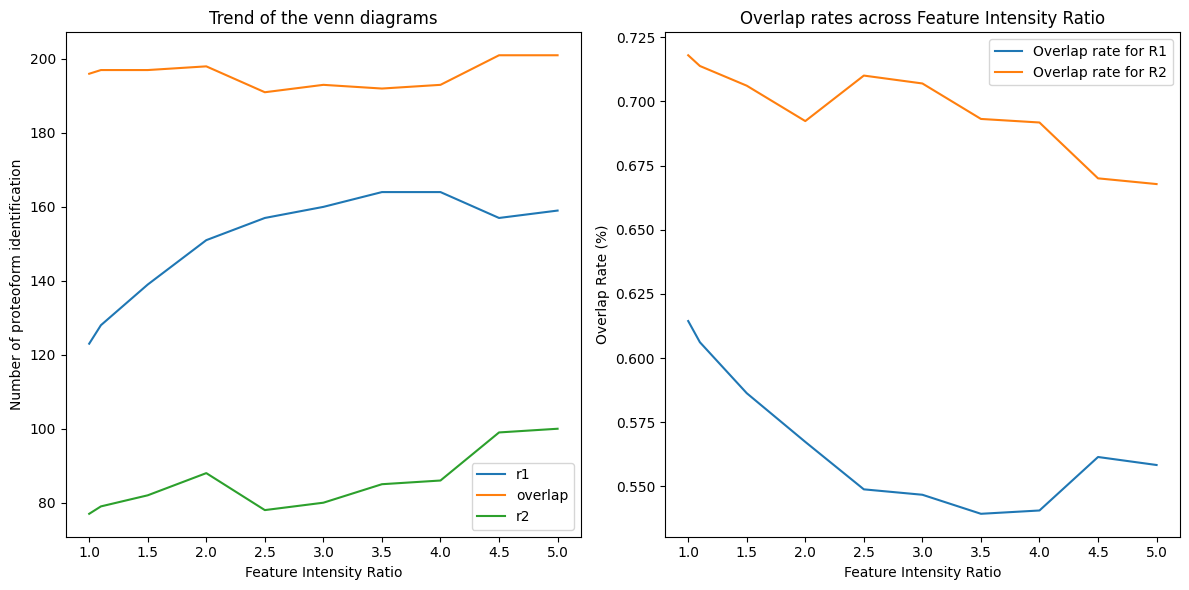

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

r1 = [123, 128, 139, 151, 157, 160, 164, 164, 157, 159]
overlap = [196, 197, 197, 198, 191, 193, 192, 193, 201, 201]
r2 = [77, 79, 82, 88, 78, 80, 85, 86, 99, 100]

x = [1, 1.1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

overlaprate1 = [o / (r1_val + o) for r1_val, o in zip(r1, overlap)]
overlaprate2 = [o / (r2_val + o) for r2_val, o in zip(r2, overlap)]

# Create a figure with side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First plot with r1, overlap, r2
sns.lineplot(x=x, y=r1, label='r1', ax=ax1)
sns.lineplot(x=x, y=overlap, label='overlap', ax=ax1)
sns.lineplot(x=x, y=r2, label='r2', ax=ax1)
ax1.set_title('Trend of the venn diagrams')
ax1.set_xlabel('Feature Intensity Ratio')
ax1.set_ylabel('Number of proteoform identification')

# Second plot with the generated lists
sns.lineplot(x=x, y=overlaprate1, label='Overlap rate for R1', ax=ax2)
sns.lineplot(x=x, y=overlaprate2, label='Overlap rate for R2', ax=ax2)
ax2.set_title('Overlap rates across Feature Intensity Ratio')
ax2.set_xlabel('Feature Intensity Ratio')
ax2.set_ylabel('Overlap Rate (%)')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np

dir = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/"

msdeplex = pd.read_csv(dir + "merged_results.tsv", sep="\t")
toppic = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_ms2_toppic_proteoform_single.tsv", sep="\t", skiprows=26)

r1 = toppic
r2 = msdeplex

r1["Origin"] = 1
r2["Origin"] = 2

combined = pd.concat([r1, r2], ignore_index=True)

combined.sort_values(by="E-value")

combined["1"] = np.where(combined["Origin"] == 1, True, False)
combined["2"] = np.where(combined["Origin"] == 2, True, False)

resultlist = pd.DataFrame(columns=combined.columns).astype(combined.dtypes)

for i, row in combined.iterrows():
    is_duplicate = False
    for j, result in resultlist.iterrows():
        if row['Protein accession'] == result['Protein accession'] and abs(row['Precursor mass'] - result['Precursor mass']) < 1.2:
            if row["Origin"] == 1:
                resultlist.loc[j, "1"] = True
            elif row["Origin"] == 2:
                resultlist.loc[j, "2"] = True
            is_duplicate = True
            break
    
    if not is_duplicate:
        resultlist.loc[0 if pd.isnull(resultlist.index.max()) else resultlist.index.max() + 1] = row

# Calculate the sizes for the Venn diagram
# only_set1 = resultlist[(resultlist["1"] == True) & (resultlist["2"] == False)]
only_set2 = resultlist[(resultlist["1"] == False) & (resultlist["2"] == True)]
# intersection = resultlist[(resultlist["1"] == True) & (resultlist["2"] == True)]

newproteoforms = only_set2.drop(columns=["Origin", "1", "2"])
newproteoforms

replicate1 = msdeplex
replicate2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_3_MSDeplex/merged_results.tsv", sep="\t")

r1 = replicate1
r2 = replicate2

r1["Origin"] = 1
r2["Origin"] = 2

combined = pd.concat([r1, r2], ignore_index=True)

combined.sort_values(by="E-value")

combined["1"] = np.where(combined["Origin"] == 1, True, False)
combined["2"] = np.where(combined["Origin"] == 2, True, False)

resultlist = pd.DataFrame(columns=combined.columns).astype(combined.dtypes)

for i, row in combined.iterrows():
    is_duplicate = False
    for j, result in resultlist.iterrows():
        if row['Protein accession'] == result['Protein accession'] and abs(row['Precursor mass'] - result['Precursor mass']) < 1.2:
            if row["Origin"] == 1:
                resultlist.loc[j, "1"] = True
            elif row["Origin"] == 2:
                resultlist.loc[j, "2"] = True
            is_duplicate = True
            break
    
    if not is_duplicate:
        resultlist.loc[0 if pd.isnull(resultlist.index.max()) else resultlist.index.max() + 1] = row

# Calculate the sizes for the Venn diagram
only_set1 = resultlist[(resultlist["1"] == True) & (resultlist["2"] == False)]
# only_set2 = resultlist[(resultlist["1"] == False) & (resultlist["2"] == True)]
intersection = resultlist[(resultlist["1"] == True) & (resultlist["2"] == True)]

interestset = pd.concat([only_set1, intersection], ignore_index=True)

result = newproteoforms.merge(interestset, on=["Protein accession", "Precursor mass"], how="left")

print(result.shape[0], result[result["2"] == True].shape[0] / result.shape[0])

result.to_csv(dir + "newproteoformoverlapanalysis.tsv", sep="\t", index=False)

397 0.345088161209068


In [13]:
import pandas as pd
import read_msalign

newproteoforms = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/newproteoformoverlapanalysis.tsv", sep="\t")

results = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/Result_final.tsv", sep="\t")

results = results[~((results["F1 Con"] == "True") & (results["F2 Con"] == "True") & (results["A+B_1 peaks"] + results["A+B_2 peaks"] == results["B+A_1 peaks"] + results["B+A_2 peaks"]))]

interestset = newproteoforms.merge(results["Scan"], left_on="Scan(s)_x", right_on="Scan", how="left")

interestset.dropna(subset="Scan").to_csv("interestset.tsv", sep="\t", index=False)

In [57]:
def drop_custom_duplicates(group):
    threshold = 1.2

    group["Single"] = "True"

    # Sort the group by E-value to prioritize rows with the lowest value in E-value
    group = group.sort_values(by='E-value')
    
    # Initialize a list to store indices of rows to keep
    keep_indices = []

    # Iterate through the sorted group
    for index, row in group.iterrows():
        # Check if this row is a duplicate of any previously kept row
        is_duplicate = False
        for keep_index in keep_indices:
            if abs(row['Precursor mass'] - group.loc[keep_index, 'Precursor mass']) < threshold:
                is_duplicate = True
                group.loc[keep_index, "Single"] = "False"
                break
        # If not a duplicate, add it to the list of indices to keep
        if not is_duplicate:
            keep_indices.append(index)
    
    # Return only the rows to keep
    return group.loc[keep_indices]

def calculate_q_values(df):
    """
    Calculates q-values for a target-decoy search.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing protein accession and score columns.
    protein_column (str): The name of the column containing protein accession data (default: 'Protein accession').
    score_column (str): The name of the column containing identification scores (default: 'Score').
    decoy_identifier (str): The string that identifies decoy entries in the protein accession column (default: 'DECOY').
    
    Returns:
    pd.DataFrame: DataFrame with additional columns for cumulative decoy/target counts, FDR, and q-values.
    """
    # Copy the input DataFrame to avoid modifying the original data
    df = df.copy()

    # Add a column to indicate if the protein is a decoy
    df['IsDecoy'] = df["Protein accession"].str.contains("DECOY")

    # Sort by score (assuming higher score means better identification)
    df = df.sort_values(by="E-value")

    # Initialize counters for decoy and target counts
    df['Cumulative_Decoy'] = df['IsDecoy'].cumsum()
    df['Cumulative_Target'] = (~df['IsDecoy']).cumsum()

    # Calculate FDR: FDR = (# decoys / # total)
    df['FDR'] = df['Cumulative_Decoy'] / (df['Cumulative_Decoy'] + df['Cumulative_Target'])

    # Calculate q-value: the minimum FDR at or above this score
    df['q-value'] = df['FDR'][::-1].cummin()[::-1]  # Reverse cummin to get the minimum FDR for each score

    df.sort_index()

    return df["q-value"]

In [59]:
import pandas as pd

df = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/Result_final.tsv", sep="\t")

modifieddf = df[~(df["A+B_1"] == df["B+A_1"])]

modifieddf = modifieddf[modifieddf["choice"] == "B"]

# modifieddf = modifieddf[~(modifieddf["A+B_1"] == "-")]

scanlist = modifieddf["Scan"].tolist()

rawtoppicprsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
rawtoppicproteoform = rawtoppicprsm.sort_values(by='E-value').drop_duplicates(subset='Feature ID', keep='first').groupby('Protein accession', group_keys=False).apply(drop_custom_duplicates).sort_values(by="Scan(s)")

rawtoppicprsm["Spectrum-level Q-value"] = calculate_q_values(rawtoppicprsm)
rawtoppicproteoform["Proteoform-level Q-value"] = calculate_q_values(rawtoppicproteoform)

toppicprsm = rawtoppicprsm[(rawtoppicprsm["Spectrum-level Q-value"] < 0.01)].sort_values(by="Scan(s)")
toppicproteoform = rawtoppicproteoform[(rawtoppicproteoform["Proteoform-level Q-value"] < 0.01)].sort_values(by="Scan(s)")

toppicprsm = toppicprsm[~(toppicprsm["Protein accession"].str.contains("DECOY"))]
toppicproteoform = toppicproteoform[~(toppicproteoform["Protein accession"].str.contains("DECOY"))]
print(toppicproteoform.shape[0])

toppicscanlist = toppicprsm[toppicprsm["Scan(s)"].isin(scanlist)]["Scan(s)"].tolist()

deplexprsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/prsm1.tsv", sep="\t")

sharedlist = deplexprsm[deplexprsm["Scan(s)"].isin(toppicscanlist)]["Scan(s)"].tolist()

print(len(sharedlist))

# toppicproteoform[(toppicproteoform["Scan(s)"].isin(sharedlist)) & (toppicproteoform["Single"] == "False")]

# dropbyfeature = rawtoppicprsm.sort_values(by='E-value').drop_duplicates(subset='Feature ID', keep='first')

# dropbyfeature[dropbyfeature["Scan(s)"].isin(sharedlist)]

headproteoforms = toppicproteoform[toppicproteoform["Scan(s)"].isin(sharedlist)]["Scan(s)"].tolist()

filteredproteoform = rawtoppicprsm[~(rawtoppicprsm["Scan(s)"].isin(sharedlist))].sort_values(by='E-value').drop_duplicates(subset='Feature ID', keep='first').groupby('Protein accession', group_keys=False).apply(drop_custom_duplicates).sort_values(by="Scan(s)")

filteredproteoform["Proteoform-level Q-value"] = 0
filteredproteoform["Proteoform-level Q-value"] = calculate_q_values(filteredproteoform)
filteredproteoform = filteredproteoform[(filteredproteoform["Proteoform-level Q-value"] < 0.01)].sort_values(by="Scan(s)")
filteredproteoform = filteredproteoform[~(filteredproteoform["Protein accession"].str.contains("DECOY"))]
filteredproteoform




2059
264


/tmp/ipykernel_4873/3505956306.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rawtoppicproteoform = rawtoppicprsm.sort_values(by='E-value').drop_duplicates(subset='Feature ID', keep='first').groupby('Protein accession', group_keys=False).apply(drop_custom_duplicates).sort_values(by="Scan(s)")


,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value,Single
4614,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,4614,5063,HCD,6875,3032.07,48,3,2901.59896,2901.600416,...,NaN,0,NaN,-,15,12,0.00001,0.0,0.0,False


In [52]:
deplexproteoform = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/proteoform1.tsv", sep="\t")
print(deplexproteoform.shape[0])

result_a = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=26)
result_b = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=26)

scanlist = []
rawdeplexprsm = pd.DataFrame(columns=result_a.columns).astype(result_a.dtypes)
for index, row in df.iterrows():
    scan = row["Scan"]
    if int(scan) not in scanlist:
        o1 = pd.Series()

        A1 = result_a[result_a["Scan(s)"] == scan]
        B1 = result_b[result_b["Scan(s)"] == scan]
        
        if (row["choice"] == "-"):
            o1 = A1.iloc[0]
        elif ((row["choice"] == "A")):
            if A1.shape[0] > 0:
                o1 = A1.iloc[0]
        elif (row["choice"] == "B"):
            if B1.shape[0] > 0:
                o1 = B1.iloc[0]

        if not o1.empty:
            rawdeplexprsm.loc[0 if pd.isnull(rawdeplexprsm.index.max()) else rawdeplexprsm.index.max() + 1] = o1
    # else:
    #     A1 = result_a[result_a["Scan(s)"] == scan]
    #     if A1.shape[0] > 0:
    #         output1.loc[0 if pd.isnull(output1.index.max()) else output1.index.max() + 1] = A1.iloc[0]

print(df.shape[0])
filtereddeplexproteoform = rawdeplexprsm[~(rawdeplexprsm["Scan(s)"].isin(sharedlist))].sort_values(by='E-value').drop_duplicates(subset='Feature ID', keep='first').groupby('Protein accession', group_keys=False).apply(drop_custom_duplicates).sort_values(by="Scan(s)")

filtereddeplexproteoform["Proteoform-level Q-value"] = 0
filtereddeplexproteoform["Proteoform-level Q-value"] = calculate_q_values(filtereddeplexproteoform)
filtereddeplexproteoform = filtereddeplexproteoform[(filtereddeplexproteoform["Proteoform-level Q-value"] < 0.01)].sort_values(by="Scan(s)")
filtereddeplexproteoform = filtereddeplexproteoform[~(filtereddeplexproteoform["Protein accession"].str.contains("DECOY"))]
filtereddeplexproteoform


2150
6092


/tmp/ipykernel_4873/1124164345.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtereddeplexproteoform = rawdeplexprsm[~(rawdeplexprsm["Scan(s)"].isin(sharedlist))].sort_values(by='E-value').drop_duplicates(subset='Feature ID', keep='first').groupby('Protein accession', group_keys=False).apply(drop_custom_duplicates).sort_values(by="Scan(s)")


,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
1,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,1,249,HCD,1095,1078.69,41,9,5707.03881,5707.14881,...,1,+110.2700:[32-49],0,NaN,-,11,6,0.01866,0.001182,0.003897
5,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,4,253,HCD,1100,1080.73,39,7,4434.53873,4435.49608,...,1,+354.2906:[12-29],0,NaN,-,10,6,0.056719,0.004804,0.007907
14,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,12,269,HCD,1120,1088.99,61,7,6054.09513,6055.07748,...,1,+384.1531:[1-2],0,NaN,-,14,9,0.002852,0.000253,0.000515
26,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,23,305,HCD,1164,1106.58,30,11,6631.64594,6631.70094,...,1,+56.0189:[25-34],0,NaN,-,5,5,0.012841,0.001196,0.002979
43,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,35,337,HCD,1203,1121.93,84,9,5389.0302,5388.022966,...,0,NaN,0,NaN,-,6,5,0.002963,0.000253,0.000515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6057,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,4461,6735,HCD,8882,3748.55,42,3,2770.28287,2770.286137,...,0,NaN,0,NaN,-,7,5,0.000211,0.0,0.000000
6059,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5949,6737,HCD,8884,3749.01,15,2,2338.12945,2338.132871,...,0,NaN,0,NaN,-,9,9,0.000292,0.0,0.000000
6060,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5950,6738,HCD,8886,3750.25,37,3,3038.3635,3038.367994,...,0,NaN,0,NaN,-,9,9,0.0,0.0,0.000000
6064,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5952,6746,HCD,8895,3753.19,33,4,3578.69253,3578.695141,...,0,NaN,0,NaN,-,7,6,0.0,0.0,0.000000


In [30]:
import pandas as pd
import numpy as np

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

prsm = prsm[prsm["E-value"] < 0.01]

filteredprsm = prsm.sort_values(["Feature ID", "E-value", "Protein accession"]).drop_duplicates(subset=["Feature ID", "Protein accession"], keep="first")

# filteredprsm.to_csv("FeatureID.tsv", sep="\t", index=False)

scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID")

# filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].to_csv("Scan.tsv", sep="\t", index=False)

otherprsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

otherprsm = otherprsm[(otherprsm["Scan(s)"].isin(scanlist)) & (otherprsm["E-value"] < 0.01)]

joined = filteredprsm.merge(otherprsm, on="Scan(s)", how="inner")

joined[(joined["Protein accession_x"] == joined["Protein accession_y"]) & (joined["E-value_x"] < joined["E-value_y"])]

# otherprsm.to_csv("otherscan.tsv", sep="\t", index=False)

# otherprsm[otherprsm["Scan(s)"] == 4371]

# sharedlist = otherprsm["Scan(s)"].tolist()

# prsmfiltered = prsm[prsm["Scan(s)"].isin(sharedlist)].sort_values(by="Scan(s)").reset_index()

# prsmfiltered["Delta E-value"] = np.log10(otherprsm["E-value"]) - np.log10(prsmfiltered["E-value"])

# prsmfiltered







# df_sorted.groupby('Feature ID')

# # For groups with size >= 2, return the 'Scan(s)' column for each row excluding the first row
# result = grouped.apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

/tmp/ipykernel_7190/1840675852.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)
/tmp/ipykernel_7190/1840675852.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)


,Data file name_x,Prsm ID_x,Spectrum ID_x,Fragmentation_x,Scan(s),Retention time_x,#peaks_x,Charge_x,Precursor mass_x,Adjusted precursor mass_x,...,#unexpected modifications_y,unexpected modifications_y,#variable PTMs_y,variable PTMs_y,MIScore_y,#matched peaks_y,#matched fragment ions_y,E-value_y,Spectrum-level Q-value_y,Proteoform-level Q-value_y
4,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,2158,2542,HCD,3849,2003.47,85,6,5116.63520,5116.635698,...,1,-214.9381:[31-34],0,NaN,-,9,9,4.701725e-03,0.0,0.0
7,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,2744,3130,HCD,4555,2240.38,67,5,4026.99162,4026.004270,...,1,-127.0664:[1-2],0,NaN,-,14,14,3.635082e-05,0.0,0.0
13,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,1923,2306,HCD,3566,1908.81,99,7,5967.14078,5968.208130,...,1,+267.4562:[35-42],0,NaN,-,16,13,9.776596e-04,0.0,0.0
32,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,4519,4960,HCD,6751,2988.95,72,4,4335.21481,4335.299810,...,1,+100.1094:[41],0,NaN,-,20,15,8.684294e-07,0.0,0.0
65,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,4885,5367,HCD,7239,3159.42,49,6,6838.15502,6838.290020,...,0,NaN,0,NaN,-,14,13,1.256675e-05,0.0,0.0


In [5]:
import read_msalign

speclist = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2.msalign")

featureID_dict = {
    801: 0,
    1498: 0,
    6142: 0,
    2527: 0,
    1936: 0,
    10085: 0,
    4908: 0,
    1821: 0,
    3889: 0,
    1519: 0,
    3429: 0,
    2044: 0,
    8909: 0,
    5973: 0,
    8310: 0,
    11553: 0,
    9434: 0,
    13123: 0,
    12683: 0,
    14205: 0,
    14571: 0,
    15342: 0,
    12674: 0
}

for spec in speclist:
    if not spec.header.pre_id_list[0] == "" and int(spec.header.pre_id_list[0]) in featureID_dict.keys():
        featureID_dict[int(spec.header.pre_id_list[0])] += 1
    if len(spec.header.pre_id_list) > 1 and int(spec.header.pre_id_list[1]) in featureID_dict.keys():
        featureID_dict[int(spec.header.pre_id_list[1])] += 1

print(featureID_dict)

{801: 2, 1498: 1, 6142: 1, 2527: 1, 1936: 2, 10085: 1, 4908: 4, 1821: 6, 3889: 6, 1519: 1, 3429: 3, 2044: 1, 8909: 1, 5973: 2, 8310: 1, 11553: 1, 9434: 6, 13123: 2, 12683: 1, 14205: 1, 14571: 7, 15342: 3, 12674: 3}


In [28]:
import read_msalign
import copy
import json

def getMatchedPeaks(prsmID, dir, spec):
    with open(dir + "prsm" + str(prsmID) + ".js") as file:
        file.readline()
        toppic = json.loads(file.read())
        peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
        matched_list = []
        nonmatched_list = []
        if len(spec.peak_list) == 1:
            matched_list.append(copy.deepcopy(spec.peak_list[0]))
        else:
            for idx in range(0, len(peak_list)):
                if "matched_ions" in peak_list[idx]:
                    matched_list.append(copy.deepcopy(spec.peak_list[idx]))
                else:
                    nonmatched_list.append(copy.deepcopy(spec.peak_list[idx]))
        return matched_list, nonmatched_list

scans = [
    2307, 2429, 2921, 3231, 3450, 3566, 3625, 3677, 3691, 3704, 3729, 3782, 
    3849, 3900, 4013, 4070, 4109, 4235, 4262, 4275, 4295, 4332, 4353, 4371, 
    4419, 4441, 4484, 4555, 4599, 4737, 4746, 4827, 4845, 4957, 5055, 5169, 
    5245, 5342, 5372, 5430, 5481, 5820, 5903, 5909, 6021, 6035, 6071, 6201, 
    6252, 6255, 6405, 6573, 6603, 6725, 6751, 7107, 7127, 7158, 7239, 7470, 
    7485, 7523, 7652, 7681, 8619, 8643
]

a_dir = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/" + "A_html/toppic_prsm_cutoff/data_js/prsms/"
b_dir = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/" + "B_html/toppic_prsm_cutoff/data_js/prsms/"

result_a = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/" + "A_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=26)
result_b = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/" + "B_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=26)

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

data = {
    "Protein": [False] * len(scans),
    "Shared Peaks": [False] * len(scans)
}

df = pd.DataFrame(data, index=scans)
for scan in scans:
    df.loc[scan, "Protein"] = result_a[result_a["Scan(s)"] == int(scan)].iloc[0]["Protein accession"] == result_b[result_b["Scan(s)"] == int(scan)].iloc[0]["Protein accession"]

    main_spec = copy.deepcopy((spec_dict[str(scan)]))
    matchedList_a, nonMatchedList = getMatchedPeaks(result_a[result_a["Scan(s)"] == int(scan)].iloc[0]["Prsm ID"], a_dir, main_spec)
    matchedList_b, nonMatchedList = getMatchedPeaks(result_b[result_b["Scan(s)"] == int(scan)].iloc[0]["Prsm ID"], b_dir, main_spec)

    seta = set(matchedList_a)
    setb = set(matchedList_b)

    df.loc[scan, "Shared Peaks"] = len(seta.intersection(setb)) / min(float(len(seta)), float(len(setb))) >= 0.65

df

,Protein,Shared Peaks
2307,True,True
2429,True,True
2921,False,False
3231,False,False
3450,True,True
...,...,...
7523,True,True
7652,False,False
7681,True,True
8619,True,True


In [11]:
import pandas as pd
import read_msalign

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

prsm = prsm[(prsm["E-value"] < 0.01) & ~(prsm["Protein accession"].str.contains("DECOY"))]

grouped = prsm.groupby("Feature ID")
consistent_groups = grouped.filter(lambda x: x["Protein accession"].nunique() == 1)

grouped_again = consistent_groups.groupby(["Feature ID", "Protein accession"])
filtered_groups = grouped_again.filter(lambda x: len(x) > 1)

unique_feature_ids_count = filtered_groups["Feature ID"].nunique()
print(unique_feature_ids_count)

scan_list = filtered_groups["Scan(s)"].tolist()

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_ms2.msalign")

possiblelist = [spec for spec in spec_list if spec.header.spec_scan in scan_list]

print(len(possiblelist))

masslist = []

for spec in possiblelist:
    masslist.append(float(spec.header.pre_mass_list[0]))

averagemass = sum(masslist) / len(masslist)

outputlist = []
for spec in possiblelist:
    if abs(float(spec.header.pre_mass_list[0]) - averagemass) < 500:
        continue
     
    spec.header.pre_mz_list = spec.header.pre_mz_list[:1]
    spec.header.pre_charge_list = spec.header.pre_charge_list[:1]
    spec.header.pre_mass_list = spec.header.pre_mass_list[:1]
    spec.header.pre_inte_list = spec.header.pre_inte_list[:1]
    spec.header.pre_id_list = spec.header.pre_id_list[:1]

    spec.header.pre_mass_list.append(str(averagemass))
    spec.header.pre_charge_list.append(spec.header.pre_charge_list[0])
    spec.header.pre_mz_list.append(str(averagemass / int(spec.header.pre_charge_list[1])))
    spec.header.pre_inte_list.append(spec.header.pre_inte_list[0])
    spec.header.pre_id_list.append("-1")

    outputlist.append(spec)

print(len(outputlist))

read_msalign.write_spec_file("simulation_ms2.msalign", outputlist)

942
2892
2405


In [90]:
import pandas as pd
import numpy as np

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/testinsideiso/new/Yeast_1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

prsm = prsm[prsm["E-value"] < 0.01]

newuniquefeatures = prsm.drop_duplicates("Feature ID")["Feature ID"].tolist()

print(prsm.drop_duplicates("Feature ID").shape[0])

filteredprsm = prsm.sort_values(["Feature ID", "E-value", "Protein accession"]).drop_duplicates(subset=["Feature ID", "Protein accession"], keep="first")

# # filteredprsm.to_csv("FeatureID.tsv", sep="\t", index=False)

scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

print(len(scanlist))

filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID")

1941
76


/tmp/ipykernel_7804/3357113800.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)
/tmp/ipykernel_7804/3357113800.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)


,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
2783,../../../../data/zwang64/yeast/test/Yeast_1_ms...,2783,3167,HCD,4599,2254.87,82,7,4932.44810,4932.543100,...,1,-387.1272:[21-30],0,NaN,-,17,13,1.118224e-04,0.000000,0.0
3316,../../../../data/zwang64/yeast/test/Yeast_1_ms...,3316,3705,HCD,5245,2472.81,75,5,4613.25242,4613.342420,...,1,-440.1966:[31-49],0,NaN,-,20,14,6.998942e-05,0.000000,0.0
1829,../../../../data/zwang64/yeast/test/Yeast_1_ms...,1829,2209,HCD,3450,1871.65,92,8,5527.94083,5528.050830,...,1,+365.3472:[32-48],0,NaN,-,23,18,5.940262e-09,0.000000,0.0
2161,../../../../data/zwang64/yeast/test/Yeast_1_ms...,2161,2542,HCD,3849,2003.47,85,6,5116.63520,5116.635698,...,0,NaN,0,NaN,-,25,21,9.853335e-17,0.000000,0.0
3161,../../../../data/zwang64/yeast/test/Yeast_1_ms...,3161,3548,HCD,5057,2409.80,74,5,4467.32942,4466.367192,...,0,NaN,0,NaN,-,17,13,8.452394e-06,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982,../../../../data/zwang64/yeast/test/Yeast_1_ms...,4982,5468,HCD,7361,3203.30,60,5,5181.70167,5181.706027,...,0,NaN,0,NaN,-,9,8,5.081438e-04,0.000000,0.0
5033,../../../../data/zwang64/yeast/test/Yeast_1_ms...,5033,5521,HCD,7424,3225.55,61,3,3020.52415,3019.486800,...,1,-409.1957:[22-30],0,NaN,-,6,6,1.691676e-03,0.000255,0.0
4952,../../../../data/zwang64/yeast/test/Yeast_1_ms...,4952,5433,HCD,7319,3188.12,56,5,5561.46912,5561.579120,...,1,-219.2227:[1-17],0,NaN,-,9,9,1.206381e-05,0.000000,0.0
5537,../../../../data/zwang64/yeast/test/Yeast_1_ms...,5537,6094,HCD,8112,3471.80,36,4,3620.93425,3621.004250,...,1,+419.2757:[19-31],0,NaN,-,13,12,2.946908e-04,0.000000,0.0


In [23]:
import pandas as pd
import numpy as np

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

# prsm = prsm[prsm["E-value"] < 0.01]

oldfeaturelist = prsm.drop_duplicates("Feature ID")["Feature ID"].tolist()

print(prsm.drop_duplicates("Feature ID").shape[0])

filteredprsm = prsm.sort_values(["Feature ID", "E-value", "Protein accession"]).drop_duplicates(subset=["Feature ID", "Protein accession"], keep="first")

# # filteredprsm.to_csv("FeatureID.tsv", sep="\t", index=False)

scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

print(len(scanlist))

filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID")

# # filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].to_csv("Scan.tsv", sep="\t", index=False)

# otherprsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

# otherprsm = otherprsm[(otherprsm["Scan(s)"].isin(scanlist)) & (otherprsm["E-value"] < 0.01)]

# joined = filteredprsm.merge(otherprsm, on="Scan(s)", how="inner")

# joined[(joined["Protein accession_x"] == joined["Protein accession_y"]) & (joined["E-value_x"] < joined["E-value_y"])]

# otherprsm.to_csv("otherscan.tsv", sep="\t", index=False)

# otherprsm[otherprsm["Scan(s)"] == 4371]

# sharedlist = otherprsm["Scan(s)"].tolist()

# prsmfiltered = prsm[prsm["Scan(s)"].isin(sharedlist)].sort_values(by="Scan(s)").reset_index()

# prsmfiltered["Delta E-value"] = np.log10(otherprsm["E-value"]) - np.log10(prsmfiltered["E-value"])

# prsmfiltered







# df_sorted.groupby('Feature ID')

# # For groups with size >= 2, return the 'Scan(s)' column for each row excluding the first row
# result = grouped.apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

2147
148


/tmp/ipykernel_11361/2391317668.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)
/tmp/ipykernel_11361/2391317668.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)


,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
195,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,195,869,HCD,1842,1343.92,140,14,8413.35003,8412.427680,...,1,-489.1563:[70-82],0,NaN,-,10,10,0.094715,0.004484,0.009255
1888,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,1888,2977,HCD,4371,2178.32,53,4,3545.01121,3545.081210,...,1,-474.0153:[31-35],0,NaN,-,16,13,0.000002,0.000000,0.000000
2569,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,2569,3776,HCD,5330,2501.46,50,3,2292.24514,2292.290140,...,1,-1.8834:[1-2],0,NaN,-,13,10,0.031942,0.002098,0.000000
2052,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,2052,3167,HCD,4599,2254.87,82,7,4932.44810,4932.543100,...,1,-387.1272:[21-30],0,NaN,-,17,13,0.000112,0.000000,0.000000
2507,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,2507,3705,HCD,5245,2472.81,75,5,4613.25242,4613.342420,...,1,-440.1966:[31-49],0,NaN,-,20,14,0.000070,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,4348,6236,HCD,8282,3533.48,35,2,1747.98219,1748.959540,...,1,+69.1077:[14-15],0,NaN,-,4,6,0.080772,0.003611,0.007353
3867,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,3867,5500,HCD,7399,3216.69,40,3,3404.35156,3403.319210,...,1,-35.2705:[6-28],0,NaN,-,9,7,0.061809,0.003187,0.002112
7,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,7,302,HCD,1161,1105.89,70,11,6846.83685,6846.856850,...,1,+182.1449:[1],0,NaN,-,5,5,0.057754,0.002969,0.006442
3707,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,3707,5279,HCD,7134,3123.01,31,3,2857.46941,2857.471787,...,0,NaN,0,NaN,-,7,7,0.008901,0.001212,0.000000


In [24]:
import json
import copy

def getMatchedPeaks(prsmID, dir, spec):
    with open(dir + "prsm" + str(prsmID) + ".js") as file:
        file.readline()
        toppic = json.loads(file.read())
        peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
        matched_list = []
        nonmatched_list = []
        if len(spec.peak_list) == 1:
            matched_list.append(copy.deepcopy(spec.peak_list[0]))
        else:
            for idx in range(0, len(peak_list)):
                if "matched_ions" in peak_list[idx]:
                    matched_list.append(copy.deepcopy(spec.peak_list[idx]))
                else:
                    nonmatched_list.append(copy.deepcopy(spec.peak_list[idx]))
        return matched_list, nonmatched_list

1786
1908
     Scan(s)  log_diff
636     3271 -5.305793
637     3277 -5.705778
638     3278 -8.535990
639     3279 -5.014349
640     3281 -5.940878
808     3864 -7.546117
868     4097 -7.073419
870     4104 -5.141880
-8.53598977273457


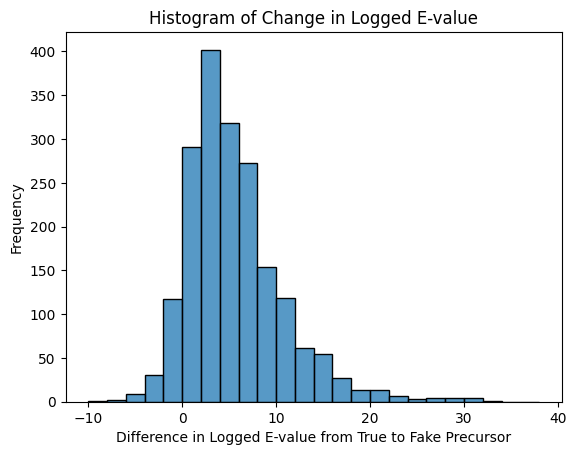

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import read_msalign


spectra = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/yeast/simulation/new/simulation_ms2.msalign")

spec_dict = {}
for spec in spectra:
    spec_dict[str(spec.header.spec_scan)] = spec

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/simulation/new/simulation_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
dir = "/home/daniel/Desktop/datafiles/RealData/yeast/simulation/new/simulation_html/toppic_prsm_cutoff/data_js/prsms/"
trueprsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
truedir = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_html/toppic_prsm_cutoff/data_js/prsms/"

merge = prsm.merge(trueprsm, on="Scan(s)", how="left")

totalscans = merge["Scan(s)"].tolist()

sameproteinscans = merge[merge["Protein accession_x"] == merge["Protein accession_y"]]["Scan(s)"].tolist()

print(len(sameproteinscans))

for scan in totalscans:
    if scan not in sameproteinscans:
        matchedList_simulation, nonMatchedList = getMatchedPeaks(prsm[prsm["Scan(s)"] == int(scan)].iloc[0]["Prsm ID"], dir, spec_dict[str(scan)])
        matchedList_true, nonMatchedList = getMatchedPeaks(trueprsm[trueprsm["Scan(s)"] == int(scan)].iloc[0]["Prsm ID"], truedir, spec_dict[str(scan)])
        setsimulation = set(matchedList_simulation)
        settrue = set(matchedList_true)
        if (len(setsimulation.intersection(settrue)) / min(float(len(settrue)), float(len(setsimulation))) >= 0.8):
            sameproteinscans.append(scan)

print(len(sameproteinscans))

merge = merge[merge["Scan(s)"].isin(sameproteinscans)]

# Step 1: Apply log10 to both columns
merge['log_E-value_x'] = np.log10(merge['E-value_x'])
merge['log_E-value_y'] = np.log10(merge['E-value_y'])

# Step 2: Subtract logged values
merge['log_diff'] = merge['log_E-value_x'] - merge['log_E-value_y']

print(merge[(merge['log_diff'] < -5)][["Scan(s)", "log_diff"]])

bin_width = 2  # Adjust the bin width as desired
min_val = merge['log_diff'].min()
print(min_val)
max_val = merge['log_diff'].max()

# Create bins that are symmetrical around 0, with consistent width
bins = np.arange(min_val // bin_width * bin_width, max_val // bin_width * bin_width + bin_width, bin_width)

# Step 3: Create a histogram using seaborn
sns.histplot(merge['log_diff'], bins=bins, kde=False, edgecolor='black')

# Customize plot
plt.title('Histogram of Change in Logged E-value')
plt.xlabel('Difference in Logged E-value from True to Fake Precursor')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [73]:
import pandas as pd

result1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
result2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

result1 = result1[(result1["E-value"] < 0.01)]
result2 = result2[(result2["E-value"] < 0.01)]

spectra = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2.msalign")

spec_dict = {}
for spec in spectra:
    spec_dict[str(spec.header.spec_scan)] = spec

dir_1 = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_html/toppic_prsm_cutoff/data_js/prsms/"
dir_2 = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_html/toppic_prsm_cutoff/data_js/prsms/"

merge = result1.merge(result2, on="Scan(s)", how="inner")

totalscans = merge["Scan(s)"].tolist()

sameproteinscans = merge[merge["Protein accession_x"] == merge["Protein accession_y"]]["Scan(s)"].tolist()

print(len(sameproteinscans))

for scan in totalscans:
    if scan not in sameproteinscans:
        matchedList_1, nonMatchedList = getMatchedPeaks(result1[result1["Scan(s)"] == int(scan)].iloc[0]["Prsm ID"], dir_1, spec_dict[str(scan)])
        matchedList_2, nonMatchedList = getMatchedPeaks(result2[result2["Scan(s)"] == int(scan)].iloc[0]["Prsm ID"], dir_2, spec_dict[str(scan)])
        set1 = set(matchedList_1)
        set2 = set(matchedList_2)
        if (len(set1.intersection(set2)) / min(float(len(set1)), float(len(set2))) >= 0.8):
            sameproteinscans.append(scan)

print(len(sameproteinscans))

merge = merge[merge["Scan(s)"].isin(sameproteinscans)]

# Step 1: Apply log10 to both columns
merge['log_E-value_x'] = np.log10(merge['E-value_x'])
merge['log_E-value_y'] = np.log10(merge['E-value_y'])

# Step 2: Subtract logged values
merge['log_diff'] = merge['log_E-value_x'] - merge['log_E-value_y']

print(len(merge[(merge['log_diff'] > 5)]))

currlist = merge[(merge['log_diff'] > 5)]["Scan(s)"].tolist()

1573
1613
58


In [78]:
setcurr = set(currlist)
setall = set(scanlist)

print(len(setall.intersection(setcurr)))

print(setcurr - setall)

16
{4097, 6657, 3206, 3207, 4104, 4105, 4106, 4107, 2965, 3864, 3621, 3241, 3756, 3245, 5168, 3249, 5042, 4659, 3257, 4796, 7613, 3776, 3783, 1865, 4941, 6864, 3281, 4307, 5972, 4310, 1752, 6746, 6750, 5473, 5474, 3692, 3693, 6767, 2161, 2420, 3320, 6013}


In [75]:
outputresult = pd.Series(result1.columns)

totalscanlist = result1["Scan(s)"].tolist()

outputresult = pd.concat([result1[~(result1["Scan(s)"].isin(currlist))], result2[result2["Scan(s)"].isin(currlist)]], ignore_index=True).sort_values(by="Scan(s)")

newfeatureID = outputresult.drop_duplicates("Feature ID")["Feature ID"].tolist()

print(outputresult.drop_duplicates("Feature ID").shape[0])

filteredprsm = outputresult.sort_values(["Feature ID", "E-value", "Protein accession"]).drop_duplicates(subset=["Feature ID", "Protein accession"], keep="first")

# # filteredprsm.to_csv("FeatureID.tsv", sep="\t", index=False)

scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

print(len(scanlist))

print(len(filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID")))

1939
76
73


/tmp/ipykernel_7804/694792379.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)
/tmp/ipykernel_7804/694792379.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)


In [93]:
from matplotlib_venn import venn2

setold = set(oldfeaturelist)
setnew = set(newuniquefeatures)

interestingfeatures = setnew - setold

interestingfeatures

{358,
 560,
 1050,
 1727,
 2165,
 2492,
 2672,
 3215,
 3231,
 4678,
 5973,
 6143,
 7571,
 7575,
 8496,
 8625,
 8867,
 10374,
 10858,
 11611,
 12076,
 13123,
 14451,
 14545,
 14912,
 16067,
 16467,
 16985,
 18689,
 19142,
 19179}

In [95]:
features = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Feature ID'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

set(interestingfeatures).intersection(set(features))

/tmp/ipykernel_7804/2566201855.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  features = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Feature ID'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)
/tmp/ipykernel_7804/2566201855.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Feature ID'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)


{14451}

2011 141


/tmp/ipykernel_1765291/2517195971.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('group')['multiplexed'].mean()


0.2101477975312969


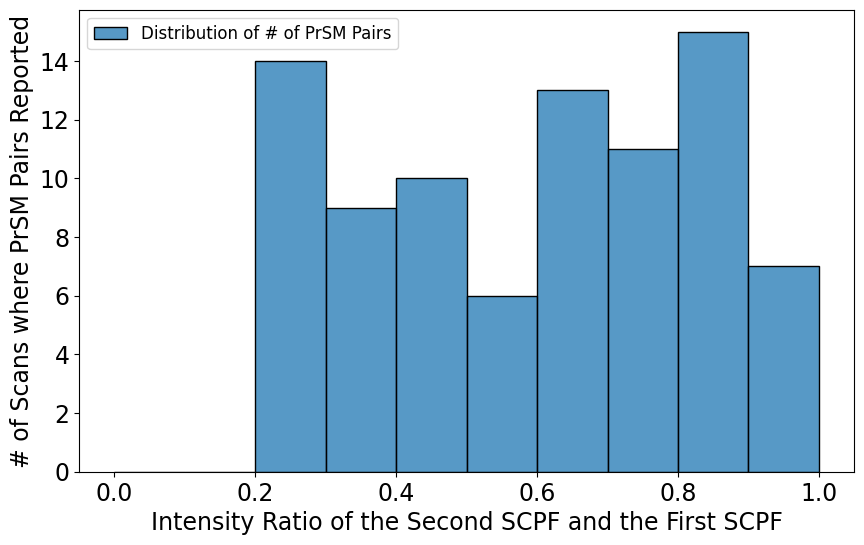

In [3]:
def calculate_q_values(df):
    """
    Calculates q-values for a target-decoy search.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing protein accession and score columns.
    protein_column (str): The name of the column containing protein accession data (default: 'Protein accession').
    score_column (str): The name of the column containing identification scores (default: 'Score').
    decoy_identifier (str): The string that identifies decoy entries in the protein accession column (default: 'DECOY').
    
    Returns:
    pd.DataFrame: DataFrame with additional columns for cumulative decoy/target counts, FDR, and q-values.
    """
    # Copy the input DataFrame to avoid modifying the original data
    df = df.copy()

    # Add a column to indicate if the protein is a decoy
    df['IsDecoy'] = df["Protein accession"].str.contains("DECOY")

    # Sort by score (assuming higher score means better identification)
    df = df.sort_values(by="E-value")

    # Initialize counters for decoy and target counts
    df['Cumulative_Decoy'] = df['IsDecoy'].cumsum()
    df['Cumulative_Target'] = (~df['IsDecoy']).cumsum()

    # Calculate FDR: FDR = (# decoys / # total)
    df['FDR'] = df['Cumulative_Decoy'] / (df['Cumulative_Decoy'] + df['Cumulative_Target'])

    # Calculate q-value: the minimum FDR at or above this score
    df['q-value'] = df['FDR'][::-1].cummin()[::-1]  # Reverse cummin to get the minimum FDR for each score

    df.sort_index()

    return df["q-value"]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex_fdr0.01/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex_fdr0.01/AB_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

print(r1.shape[0], r2.shape[0])

pairs = r1.merge(r2, on="Scan(s)", how="inner")

print(pairs.shape[0])

scans = pairs["Scan(s)"].tolist()

df = pd.DataFrame({
    'scan': pd.Series(dtype='int'),
    'multiplexed': pd.Series(dtype='bool'),
    'ratio': pd.Series(dtype='float')
})

spectra = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_MSDeplex/A_ms2.msalign")

totalscans = [int(spec.header.spec_scan) for spec in spectra]

multiplexed = [True if int(spec.header.spec_scan) in scans else False for spec in spectra]

ratio = [float(spec.header.pre_inte_list[1]) / float(spec.header.pre_inte_list[0]) if not (spec.header.pre_inte_list[0] == '' or float(spec.header.pre_inte_list[0]) == float(0) or len(spec.header.pre_inte_list) == 1 or float(spec.header.pre_inte_list[1]) == float(0)) else 0 for spec in spectra]

df["scan"] = totalscans
df["multiplexed"] = multiplexed
df["ratio"] = ratio

# Define the bins for the ratio column
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1 (inclusive)
labels = [f"{round(bins[i], 1)} - {round(bins[i+1], 1)}" for i in range(len(bins) - 1)]

# Add a 'group' column to categorize each row into the appropriate bin
df['group'] = pd.cut(df['ratio'], bins=bins, labels=labels, include_lowest=True)

# Calculate the proportion of True values in the 'multiplexed' column for each group
proportions = df.groupby('group')['multiplexed'].mean()

# Convert the proportions into a list
proportions_list = proportions.tolist()

# Display the resulting list of proportions
proportions_list

proportions_percentage = [p * 100 for p in proportions_list]


outputdf = df[df["multiplexed"] == True]

print(outputdf['ratio'].min())

fig, ax1 = plt.subplots(figsize=(10, 6))

bins = np.arange(0.0, 1.1, 0.1)

sns.histplot(outputdf['ratio'], bins=bins, kde=False, edgecolor='black', label="Distribution of # of PrSM Pairs")

ax1.set_xlabel('Intensity Ratio of the Second SCPF and the First SCPF')
ax1.set_ylabel('# of Scans where PrSM Pairs Reported')
# ax1.set_title('Histogram of Ratio with Proportion of Multiplexed=True')

# bin_centers = np.arange(0.25, 1.05, 0.1)

# ax2 = ax1.twinx()
# ax2.plot(bin_centers, proportions_percentage[2:], color='red', label="Distribution of % of PrSM Pairs")
# ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))
# ax2.set_ylabel("% of Scans where PrSM Pairs Reported")

plt.rcParams.update({'font.size': 17})

lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper left', fontsize=12)

plt.savefig("PrSM Pairs vs Intensity Ratio.svg", format="svg", dpi=800)
plt.savefig("PrSM Pairs vs Intensity Ratio.png", format="png", dpi=800)

plt.show()



In [85]:
import pandas as pd
import read_msalign
import random
import copy

random.seed(0)

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", sep="\t")
spectra = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2.msalign")

r1 = r1[r1["E-value"] < 10E-6]

print(r1.shape[0])

multiplexscans = [int(spec.header.spec_scan) for spec in spectra if (not (spec.header.pre_inte_list[0] == '' or float(spec.header.pre_inte_list[0]) == float(0))) and (float(spec.header.pre_inte_list[0]) / sum(map(float, spec.header.pre_inte_list)) > 0.85)]

r1 = r1[r1["Scan(s)"].isin(multiplexscans)]

print(r1.shape[0])

match = r1[r1["#unexpected modifications"] == 0]["Scan(s)"].tolist()
shift = r1[r1["#unexpected modifications"] == 1]["Scan(s)"].tolist()

print(len(match), len(shift))


matcherror = []
shifterror = []
for spec in spectra:
    if int(spec.header.spec_scan) in r1["Scan(s)"].tolist():
        modifiedspec = copy.deepcopy(spec)
        
        modifiedspec.header.pre_charge_list[0] = str(int(modifiedspec.header.pre_charge_list[0]) + random.choice([1, -1]))
        modifiedspec.header.pre_mass_list[0] = str(float(modifiedspec.header.pre_mz_list[0]) * int(modifiedspec.header.pre_charge_list[0]) + 79.966)

        if int(spec.header.spec_scan) in match:
            matcherror.append(modifiedspec)
        elif int(spec.header.spec_scan) in shift:
            shifterror.append(modifiedspec)
        else:
            print("What? smn is wrong")

read_msalign.write_spec_file("matcherror_ms2.msalign", matcherror)
read_msalign.write_spec_file("shifterror_ms2.msalign", shifterror)

1094
358
199 159


112 47
112 47
110 47


/tmp/ipykernel_7823/2956719111.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newmatchmerge["matched peaks diff"] = newmatchmerge["#matched peaks_x"] - newmatchmerge["#matched peaks_y"]
/tmp/ipykernel_7823/2956719111.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newmatchmerge["matched ions diff"] = newmatchmerge["#matched fragment ions_x"] - newmatchmerge["#matched fragment ions_y"]
/tmp/ipykernel_7823/2956719111.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

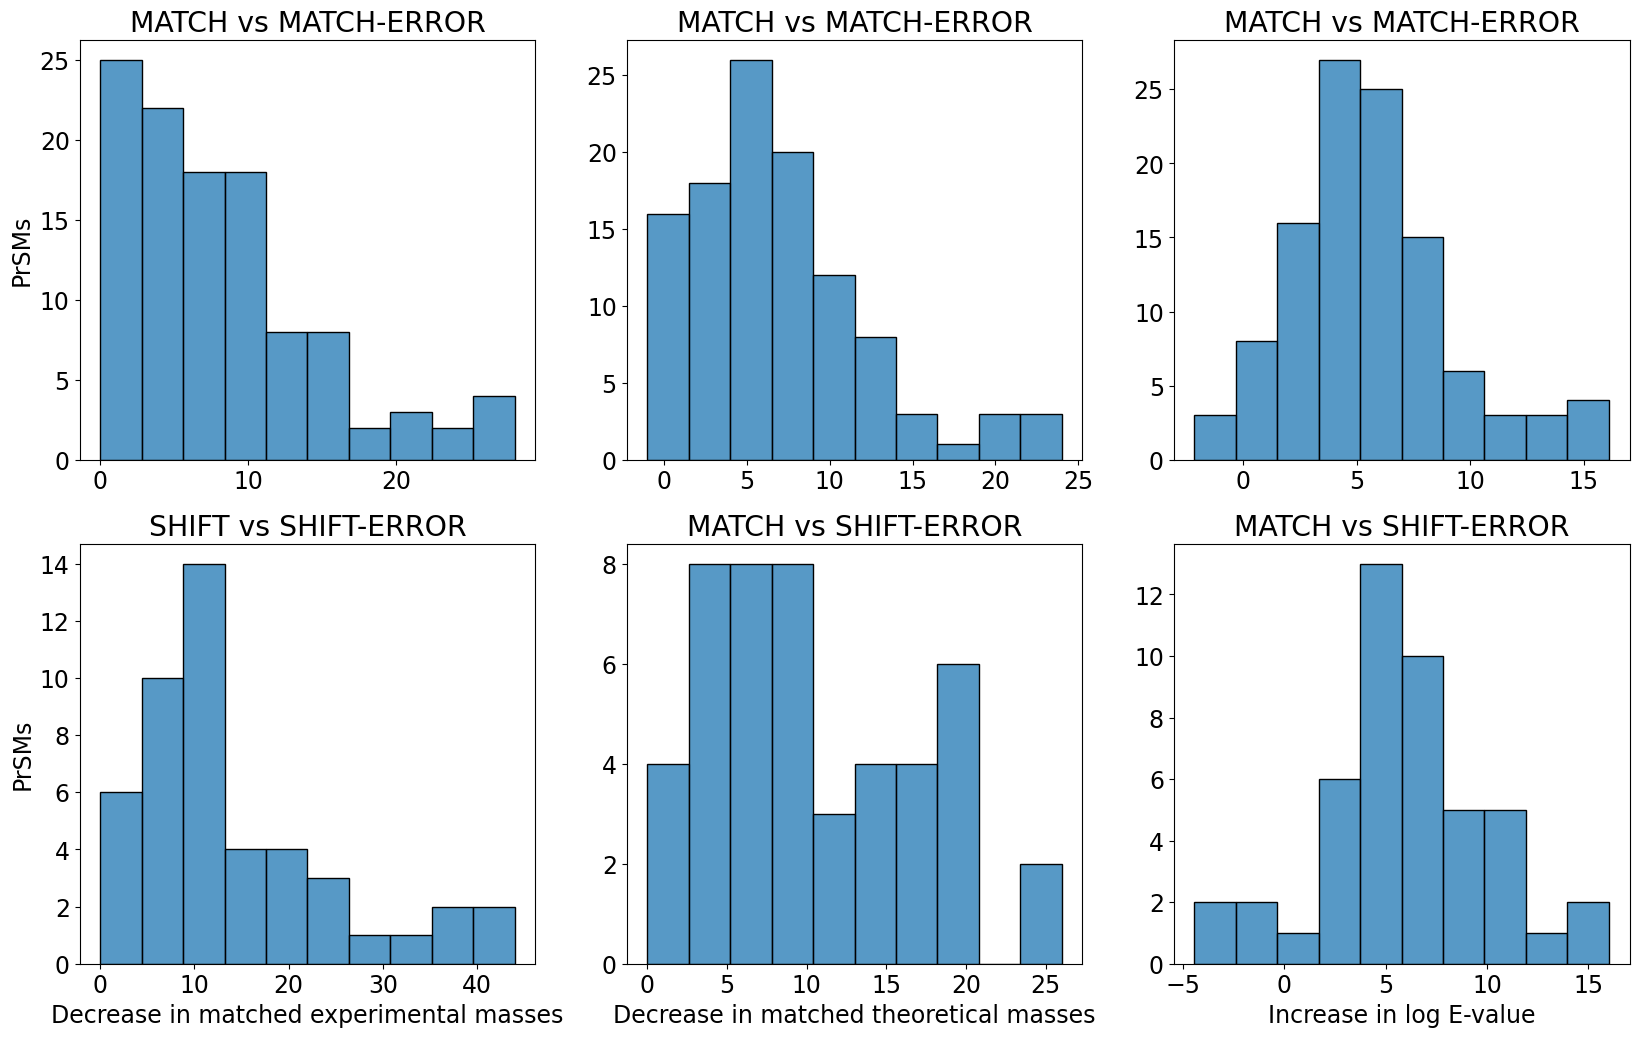

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

r1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", sep="\t")

matcherror = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/precursorselect/matcherror_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

shifterror = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/precursorselect/shifterror_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

print(matcherror.shape[0], shifterror.shape[0])

matchmerge = r1.merge(matcherror, on="Scan(s)", how="inner")
shiftmerge = r1.merge(shifterror, on="Scan(s)", how="inner")

print(matchmerge.shape[0], shiftmerge.shape[0])

newmatchmerge = matchmerge[matchmerge["Protein accession_x"] == matchmerge["Protein accession_y"]]
newshiftmerge = shiftmerge[shiftmerge["Protein accession_x"] == shiftmerge["Protein accession_y"]]

print(newmatchmerge.shape[0], newshiftmerge.shape[0])

newmatchmerge["matched peaks diff"] = newmatchmerge["#matched peaks_x"] - newmatchmerge["#matched peaks_y"]
newmatchmerge["matched ions diff"] = newmatchmerge["#matched fragment ions_x"] - newmatchmerge["#matched fragment ions_y"]
newmatchmerge["E-value diff"] = np.log10(newmatchmerge["E-value_y"]) - np.log10(newmatchmerge["E-value_x"])
# print(newmatchmerge["matched peaks diff"].max())
newshiftmerge["matched peaks diff"] = newshiftmerge["#matched peaks_x"] - newshiftmerge["#matched peaks_y"]
newshiftmerge["matched ions diff"] = newshiftmerge["#matched fragment ions_x"] - newshiftmerge["#matched fragment ions_y"]
newshiftmerge["E-value diff"] = np.log10(newshiftmerge["E-value_y"]) - np.log10(newshiftmerge["E-value_x"])

# print(newshiftmerge["matched ions diff"].max())

# bins = np.arange(-2, 26, 2)

# fig, ax1 = plt.subplots(figsize=(10, 6))

# sns.histplot(r1merge['matched ions diff'], bins=bins, kde=False, edgecolor='black', alpha=0.6, label="Distribution of ECOLI-MATCH vs ECOLI ERROR")
# sns.histplot(shiftmerge['matched ions diff'], bins=bins, kde=False, edgecolor='black', alpha=0.6, label="Distribution of ECOLI-SHIFT vs ECOLI ERROR")

# plt.xlabel("Change in # of Matched Theoretical Fragments")
# plt.ylabel("# of PrSMs")
# # plt.legend(loc='upper left', fontsize=12)
plt.rcParams.update({'font.size': 17})

# Define bins for the histogram
# bins = np.arange(-2, 28, 2)

# Create a single figure with two subplots
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(20, 12))


# Plot the histogram for r1merge on the first subplot
sns.histplot(newmatchmerge['matched peaks diff'], ax=ax1, bins=10)
ax1.set_title("MATCH vs MATCH-ERROR")
ax1.set_xlabel("")
# ax1.set_xticks(np.arange(-2, 28, 4))
ax1.set_ylabel("PrSMs")
# ax1.set_xlabel("Decrease in matched experimental masses")

sns.histplot(newmatchmerge['matched ions diff'], ax=ax2, bins=10)
ax2.set_title("MATCH vs MATCH-ERROR")
ax2.set_xlabel("")
# ax1.set_xticks(np.arange(-2, 28, 4))
ax2.set_ylabel("")

sns.histplot(newmatchmerge['E-value diff'], ax=ax3, bins=10)
ax3.set_title("MATCH vs MATCH-ERROR")
ax3.set_xlabel("")
# ax1.set_xticks(np.arange(-2, 28, 4))
ax3.set_ylabel("")

# Plot the histogram for shiftmerge on the second subplot
sns.histplot(newshiftmerge['matched peaks diff'], ax=ax4, bins=10)
ax4.set_title("SHIFT vs SHIFT-ERROR")
ax4.set_xlabel("Decrease in matched experimental masses")
ax4.set_ylabel("PrSMs")
# ax2.set_xticks(np.arange(-2, 28, 4))

sns.histplot(newshiftmerge['matched ions diff'], ax=ax5, bins=10)
ax5.set_title("MATCH vs SHIFT-ERROR")
ax5.set_xlabel("Decrease in matched theoretical masses")
ax5.set_ylabel("")

sns.histplot(newshiftmerge['E-value diff'], ax=ax6, bins=10)
ax6.set_title("MATCH vs SHIFT-ERROR")
ax6.set_xlabel("Increase in log E-value")
ax6.set_ylabel("")


plt.savefig("PrecursorSelection.svg", format="svg", dpi=800)
plt.savefig("PrecursorSelection.png", format="png", dpi=800)

In [241]:
import pandas as pd
import read_msalign

prsms = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", sep="\t")
scans = prsms["Scan(s)"].tolist()

spectra = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2.msalign")

nonmultiplexedprsm = [spec for spec in spectra if ((int(spec.header.spec_scan) in scans) and (float(spec.header.pre_inte_list[0]) / sum(map(float, spec.header.pre_inte_list)) > 0.85))]

print(len(nonmultiplexedprsm))

pairs = []
for idx, prsm in enumerate(nonmultiplexedprsm[:-1]):
    for idxother, prsmother in enumerate(nonmultiplexedprsm[idx:]):
        if (not (int(prsm.header.pre_charge_list[0]) == int(prsmother.header.pre_charge_list[0]))) and (abs(float(prsm.header.pre_mz_list[0]) - float(prsmother.header.pre_mz_list[0])) < 1.5):
            if not (prsms[prsms["Scan(s)"] == int(prsm.header.spec_scan)].iloc[0]["Protein accession"] == prsms[prsms["Scan(s)"] == int(prsmother.header.spec_scan)].iloc[0]["Protein accession"]):
                if prsms[prsms["Scan(s)"] == int(prsm.header.spec_scan)].iloc[0]["#matched peaks"] >= prsms[prsms["Scan(s)"] == int(prsmother.header.spec_scan)].iloc[0]["#matched peaks"]:
                    pairs.append((prsm.header.spec_scan, prsmother.header.spec_scan))
                else:
                    pairs.append((prsmother.header.spec_scan, prsm.header.spec_scan))

print(len(pairs))

498
725


In [236]:
spec_dict = {}
for spec in nonmultiplexedprsm:
    spec_dict[str(spec.header.spec_scan)] = spec

output_list = []
for pair in pairs:
    mainSpec = copy.deepcopy(spec_dict[str(pair[0])])
    sideSpec = spec_dict[str(pair[1])]
    mainSpec.header.title = str(sideSpec.header.spec_scan)
    mainSpec.header.pre_mz_list = [mainSpec.header.pre_mz_list[0], sideSpec.header.pre_mz_list[0]]
    mainSpec.header.pre_charge_list = [mainSpec.header.pre_charge_list[0], sideSpec.header.pre_charge_list[0]]
    mainSpec.header.pre_mass_list = [mainSpec.header.pre_mass_list[0], sideSpec.header.pre_mass_list[0]]
    mainSpec.header.pre_inte_list = [mainSpec.header.pre_inte_list[0], sideSpec.header.pre_inte_list[0]]
    mainSpec.header.pre_id_list = [mainSpec.header.pre_id_list[0], sideSpec.header.pre_id_list[0]]
    mainSpec.peak_list = mainSpec.peak_list + sideSpec.peak_list
    output_list.append(mainSpec)

sortedlist = read_msalign.sortScans(output_list)

print(len(sortedlist))

read_msalign.write_spec_file("A_ms2.msalign", sortedlist)

for spec in sortedlist:
    pre_mz_list = spec.header.pre_mz_list
    pre_charge_list = spec.header.pre_charge_list
    pre_mass_list = spec.header.pre_mass_list
    pre_inte_list = spec.header.pre_inte_list
    pre_id_list = spec.header.pre_id_list

    pre_mz_list[0], pre_mz_list[1] = pre_mz_list[1], pre_mz_list[0]
    pre_charge_list[0], pre_charge_list[1] = pre_charge_list[1], pre_charge_list[0]
    pre_mass_list[0], pre_mass_list[1] = pre_mass_list[1], pre_mass_list[0]
    pre_inte_list[0], pre_inte_list[1] = pre_inte_list[1], pre_inte_list[0]
    pre_id_list[0], pre_id_list[1] = pre_id_list[1], pre_id_list[0]

    spec.header.pre_mz_list = pre_mz_list
    spec.header.pre_charge_list = pre_charge_list
    spec.header.pre_mass_list = pre_mass_list
    spec.header.pre_inte_list = pre_inte_list
    spec.header.pre_id_list = pre_id_list

read_msalign.write_spec_file("B_ms2.msalign", sortedlist)

725


In [199]:
import json
import copy

def getMatchedPeaks(prsmID, dir, spec):
    with open(dir + "prsm" + str(prsmID) + ".js") as file:
        file.readline()
        toppic = json.loads(file.read())
        peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
        matched_list = []
        nonmatched_list = []
        if len(spec.peak_list) == 1:
            matched_list.append(copy.deepcopy(spec.peak_list[0]))
        else:
            for idx in range(0, len(peak_list)):
                if "matched_ions" in peak_list[idx]:
                    matched_list.append(copy.deepcopy(spec.peak_list[idx]))
                else:
                    nonmatched_list.append(copy.deepcopy(spec.peak_list[idx]))
        return matched_list, nonmatched_list

import pandas as pd
import read_msalign

A = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
B = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

spectra = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2.msalign")

spec_dict = {}
for spec in spectra:
    spec_dict[str(spec.header.spec_scan)] = spec

dirA = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_html/toppic_prsm_cutoff/data_js/prsms/"
dirB = "/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_html/toppic_prsm_cutoff/data_js/prsms/"

merge = A.merge(B, on="Scan(s)", how="inner")
bothscanlist = merge["Scan(s)"].tolist()

sameproteinscans = merge[merge["Protein accession_x"] == merge["Protein accession_y"]]["Scan(s)"].tolist()

print(len(sameproteinscans))

for spec in spectra:
    scan = int(spec.header.spec_scan)
    if scan not in sameproteinscans and scan in bothscanlist:
        matchedListA, nonMatchedList = getMatchedPeaks(merge[merge["Scan(s)"] == int(scan)].iloc[0]["Prsm ID_x"], dirA, spec_dict[str(scan)])
        matchedListB, nonMatchedList = getMatchedPeaks(merge[merge["Scan(s)"] == int(scan)].iloc[0]["Prsm ID_y"], dirB, spec_dict[str(scan)])
        setA = set(matchedListA)
        setB = set(matchedListB)
        if (len(setA.intersection(setB)) / min(int(len(setA)), int(len(setB))) >= 0.9):
            sameproteinscans.append(scan)

print(len(sameproteinscans))

filteredmerge = merge[merge["Scan(s)"].isin(sameproteinscans)]
# chargemerge = filteredmerge[~(filteredmerge["Charge_x"] == filteredmerge["Charge_y"])]
completemerge = filteredmerge[filteredmerge["#unexpected modifications_x"] - filteredmerge["#unexpected modifications_y"] >= 0]
completemerge["difference # ions"] = completemerge["#matched fragment ions_y"] - completemerge["#matched fragment ions_x"]
completemerge["difference logged E-value"] = np.log10(completemerge["E-value_y"]) - np.log10(completemerge["E-value_x"])

2165
2252


/tmp/ipykernel_11361/4186889636.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completemerge["difference # ions"] = completemerge["#matched fragment ions_y"] - completemerge["#matched fragment ions_x"]
/tmp/ipykernel_11361/4186889636.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completemerge["difference logged E-value"] = np.log10(completemerge["E-value_y"]) - np.log10(completemerge["E-value_x"])


In [39]:
import pandas as pd

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

prsm = prsm[prsm["E-value"] < 0.01]

filtered_df = prsm[prsm['Feature ID'].isin(
    prsm.groupby('Feature ID').filter(
        lambda group: len(group) > 1 and group['Protein accession'].nunique() != 1
    )['Feature ID']
)]

# notreportedscans = prsm["Scan(s)"].tolist()

# oldfeaturelist = prsm.drop_duplicates("Feature ID")["Feature ID"].tolist()

# unique_values = prsm[prsm.groupby('Feature ID')['Feature ID'].transform('size') == 1]

oldinconfeaturedict = dict(zip(filtered_df['Scan(s)'], filtered_df['Feature ID']))


# print(prsm.drop_duplicates("Feature ID").shape[0])

# filteredprsm = prsm.sort_values(["Feature ID", "E-value", "Protein accession"]).drop_duplicates(subset=["Feature ID", "Protein accession"], keep="first")

# # # filteredprsm.to_csv("FeatureID.tsv", sep="\t", index=False)

# scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

# inconscans = scanlist

# filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID")
# oldinconfeatures = filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID")["Feature ID"].tolist()
# len(oldinconfeatures)

In [200]:

print(completemerge[completemerge["difference # ions"] >= 3].shape[0])
correctedscanlist = completemerge[completemerge["difference # ions"] >= 3]["Scan(s)"].tolist()

114


In [201]:
prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

replaceprsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/B_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

prsm.set_index('Scan(s)', inplace=True)
replaceprsm.set_index('Scan(s)', inplace=True)

prsm.update(replaceprsm[replaceprsm.index.isin(correctedscanlist)])

prsm.reset_index(inplace=True)

prsm = prsm[prsm["E-value"] < 0.01]

prsm.to_csv("switched>=3.tsv", sep="\t", index=False)

print(prsm.shape[0])

oldfeaturelist = prsm.drop_duplicates("Feature ID")["Feature ID"].tolist()

print(prsm.drop_duplicates("Feature ID").shape[0])

filteredprsm = prsm.sort_values(["Feature ID", "E-value", "Protein accession"]).drop_duplicates(subset=["Feature ID", "Protein accession"], keep="first")

# # filteredprsm.to_csv("FeatureID.tsv", sep="\t", index=False)

scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)

print(filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID").shape[0])
newinconfeatures = filteredprsm[filteredprsm["Scan(s)"].isin(scanlist)].drop_duplicates(subset="Feature ID")["Feature ID"].tolist()

4182
1948
60


/tmp/ipykernel_11361/3363399380.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)
/tmp/ipykernel_11361/3363399380.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scanlist = filteredprsm.groupby('Feature ID').apply(lambda x: x.iloc[1:]['Scan(s)'] if len(x) >= 2 else pd.Series([])).reset_index(drop=True)


In [20]:
import pandas as pd

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/FirstPrSM_toppic_prsm_single.tsv", sep="\t")

unique_values = prsm[prsm.groupby('Feature ID')['Feature ID'].transform('size') == 1]

newfeaturedict = dict(zip(unique_values['Feature ID'], unique_values['Scan(s)']))

In [16]:
singlefeatures = {24,
 165,
 222,
 356,
 1047,
 1050,
 1125,
 1243,
 1403,
 1498,
 1821,
 1938,
 2003,
 2044,
 2143,
 2165,
 2423,
 2662,
 2775,
 3245,
 3261,
 3479,
 3543,
 4149,
 4390,
 5047,
 5216,
 5973,
 7529,
 8625,
 8909,
 9158,
 9209,
 10374,
 12674,
 13803,
 14205,
 14705,
 16467,
 18689}

In [40]:
count = 0
case4 = []
for value in singlefeatures:
    if newfeaturedict[value] in oldinconfeaturedict:
        case4.append(value)

case4

[12674,
 1938,
 24,
 1050,
 1821,
 4390,
 3245,
 5047,
 9158,
 8909,
 2003,
 5973,
 1498,
 1243,
 222,
 5216,
 2662,
 7529,
 9209,
 2044,
 14205]

In [41]:
case3

[165, 3261, 2143, 356, 1125, 14705]

In [137]:
prsm1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/FirstPrSM_toppic_prsm_single.tsv", sep="\t")
prsm2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/SecondPrSM_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
prsm3 = pd.read_csv("/home/daniel/Desktop/secondprsm/SecondPrSMAddRandom_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
prsm4 = pd.read_csv("/home/daniel/Desktop/secondprsm/SecondPrSMRandom_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

# old = prsm1.merge(prsm2, on="Scan(s)", how="inner")
# new1 = prsm1.merge(prsm3, on="Scan(s)", how="inner")

# scanlist = old[old["Protein accession_x"] != old["Protein accession_y"]]["Scan(s)"].tolist()

# new1[(new1["Protein accession_x"] == new1["Protein accession_y"]) & (new1["Scan(s)"].isin(scanlist))]

merge = prsm2.merge(prsm3, on="Scan(s)", how="inner")

len(set(prsm3["Scan(s)"].tolist()) - set(merge["Scan(s)"].tolist()))

11

In [136]:
prsm1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/FirstPrSM_toppic_prsm_single.tsv", sep="\t")
prsm2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/SecondPrSM_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
prsm3 = pd.read_csv("/home/daniel/Desktop/secondprsm/SecondPrSMAddRandom_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)
prsm4 = pd.read_csv("/home/daniel/Desktop/secondprsm/SecondPrSMRandom_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

new1 = prsm1.merge(prsm3, on="Scan(s)", how="inner")

new1

,Data file name_x,Prsm ID_x,Spectrum ID_x,Fragmentation_x,Scan(s),Retention time_x,#peaks_x,Charge_x,Precursor mass_x,Adjusted precursor mass_x,...,#unexpected modifications_y,unexpected modifications_y,#variable PTMs_y,variable PTMs_y,MIScore_y,#matched peaks_y,#matched fragment ions_y,E-value_y,Spectrum-level Q-value_y,Proteoform-level Q-value_y
0,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,259,637,HCD,1563,1250.06,111,7,4268.32268,4268.328790,...,0,NaN,0,NaN,-,6,5,1.658360e-03,-,-
1,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,325,703,HCD,1643,1277.59,149,11,6588.59128,6589.598413,...,0,NaN,0,NaN,-,22,20,5.331180e-12,-,-
2,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,329,707,HCD,1647,1278.50,149,11,6588.59128,6589.598413,...,0,NaN,0,NaN,-,20,19,2.882987e-10,-,-
3,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,341,721,HCD,1664,1284.39,136,10,6850.70344,6850.715114,...,0,NaN,0,NaN,-,16,13,6.866400e-04,-,-
4,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,372,752,HCD,1701,1296.77,132,6,3968.09804,3968.103040,...,0,NaN,0,NaN,-,23,20,2.312200e-16,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5852,6513,HCD,8616,3654.64,55,3,2680.44997,2680.453477,...,0,NaN,0,NaN,-,13,9,1.482959e-05,-,-
761,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5858,6520,HCD,8624,3657.20,46,3,2761.45543,2761.453811,...,1,+99.8152:[25-26],0,NaN,-,14,13,7.469855e-11,-,-
762,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5860,6523,HCD,8628,3658.83,46,3,2761.45543,2761.453811,...,1,-56.2859:[25-27],0,NaN,-,11,11,1.143166e-05,-,-
763,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5864,6528,HCD,8634,3660.95,64,4,3856.75825,3856.748250,...,0,NaN,0,NaN,-,10,10,4.414272e-06,-,-


In [151]:
prsm1.merge(prsm2, on="Scan(s)", how="inner")


,Data file name_x,Prsm ID_x,Spectrum ID_x,Fragmentation_x,Scan(s),Retention time_x,#peaks_x,Charge_x,Precursor mass_x,Adjusted precursor mass_x,...,#unexpected modifications_y,unexpected modifications_y,#variable PTMs_y,variable PTMs_y,MIScore_y,#matched peaks_y,#matched fragment ions_y,E-value_y,Spectrum-level Q-value_y,Proteoform-level Q-value_y
0,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,259,637,HCD,1563,1250.06,111,7,4268.32268,4268.328790,...,0,NaN,0,NaN,-,6,5,8.604000e-04,-,-
1,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,325,703,HCD,1643,1277.59,149,11,6588.59128,6589.598413,...,0,NaN,0,NaN,-,21,19,1.637328e-12,-,-
2,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,329,707,HCD,1647,1278.50,149,11,6588.59128,6589.598413,...,0,NaN,0,NaN,-,20,19,8.341145e-11,-,-
3,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,341,721,HCD,1664,1284.39,136,10,6850.70344,6850.715114,...,0,NaN,0,NaN,-,16,13,1.233720e-04,-,-
4,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,372,752,HCD,1701,1296.77,132,6,3968.09804,3968.103040,...,0,NaN,0,NaN,-,23,20,1.621780e-16,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5852,6513,HCD,8616,3654.64,55,3,2680.44997,2680.453477,...,0,NaN,0,NaN,-,13,9,8.960351e-06,-,-
680,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5858,6520,HCD,8624,3657.20,46,3,2761.45543,2761.453811,...,1,+99.8152:[25-26],0,NaN,-,14,13,4.924485e-12,-,-
681,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5860,6523,HCD,8628,3658.83,46,3,2761.45543,2761.453811,...,1,-56.2859:[25-27],0,NaN,-,11,11,4.496700e-07,-,-
682,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5864,6528,HCD,8634,3660.95,64,4,3856.75825,3856.748250,...,0,NaN,0,NaN,-,10,10,2.712860e-07,-,-


In [20]:
import pandas as pd

prsm = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

prsm = prsm[~prsm['Protein accession'].str.contains("DECOY")]

prsm

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
0,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,0,250,HCD,1096,1078.92,31,6,3595.98458,3594.982728,...,0,NaN,0,NaN,-,6,5,5.501050e-02,0.002976,0.006461
3,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,3,257,HCD,1105,1082.83,50,6,3796.17350,3796.248500,...,1,+298.2354:[29],0,NaN,-,6,5,1.999076e-01,0.009465,0.019175
4,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,4,269,HCD,1120,1088.99,61,7,6054.09513,6055.077480,...,1,+384.1531:[1-2],0,NaN,-,14,9,2.851968e-03,0.000253,0.000548
5,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,5,298,HCD,1156,1103.80,56,11,6846.83685,6845.769500,...,1,+181.0576:[26-36],0,NaN,-,6,5,7.816320e-02,0.003391,0.006442
7,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,7,302,HCD,1161,1105.89,70,11,6846.83685,6846.856850,...,1,+182.1449:[1],0,NaN,-,5,5,5.775360e-02,0.002969,0.006442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,4584,6737,HCD,8884,3749.01,15,2,2338.12945,2338.132871,...,0,NaN,0,NaN,-,9,9,2.918465e-04,0.000000,0.000000
4585,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,4585,6738,HCD,8886,3750.25,37,3,3038.36350,3038.367994,...,0,NaN,0,NaN,-,9,9,3.454950e-10,0.000000,0.000000
4586,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,4586,6742,HCD,8890,3751.17,20,3,2765.23231,2765.235523,...,0,NaN,0,NaN,-,8,8,4.681800e-09,0.000000,0.000000
4587,../../../../data/zwang64/yeast/Yeast_1_ms2.msa...,4587,6746,HCD,8895,3753.19,33,4,3578.69253,3578.695141,...,0,NaN,0,NaN,-,7,6,4.290840e-07,0.000000,0.000000


In [38]:
import pandas as pd

prsm1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/FirstPrSM_toppic_prsm_single.tsv", sep="\t")
prsm2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/SecondPrSM_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=26)

prsm1 = prsm1[~prsm1['Protein accession'].str.contains("DECOY")]
prsm2 = prsm2[~prsm2['Protein accession'].str.contains("DECOY")]

prsm2 = prsm2[prsm2["Spectrum-level Q-value"] < 0.001]


# prsm2 = prsm2[prsm2["E-value"] < 0.001]

total = pd.concat([prsm1, prsm2], ignore_index=True)

total

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
0,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,2,250,HCD,1096,1078.92,31,6,3595.98458,3594.982728,...,0,NaN,0,NaN,-,6,5,5.501050e-02,0.002933,0.006461
1,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,9,257,HCD,1105,1082.83,50,6,3796.17350,3796.248500,...,1,+298.2354:[29],0,NaN,-,6,5,1.999076e-01,0.009336,0.019175
2,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,12,269,HCD,1120,1088.99,61,7,6054.09513,6055.077480,...,1,+384.1531:[1-2],0,NaN,-,14,9,2.851968e-03,0.000242,0.000548
3,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,18,298,HCD,1156,1103.80,56,11,6846.83685,6845.769500,...,1,+181.0576:[26-36],0,NaN,-,6,5,7.816320e-02,0.003357,0.006442
4,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,21,302,HCD,1161,1105.89,70,11,6846.83685,6846.856850,...,1,+182.1449:[1],0,NaN,-,5,5,5.775360e-02,0.002933,0.006442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5423,../../../../data/zwang64/secondprsm/SecondPrSM...,1146,6675,HCD,8810,3723.18,36,3,2214.19036,2214.193621,...,0,NaN,0,NaN,-,9,8,7.560184e-04,0.000000,0.000000
5424,../../../../data/zwang64/secondprsm/SecondPrSM...,1147,6689,HCD,8827,3729.31,28,3,2302.21549,2302.220899,...,0,NaN,0,NaN,-,7,5,1.628056e-04,0.000000,0.000000
5425,../../../../data/zwang64/secondprsm/SecondPrSM...,1148,6733,HCD,8880,3748.09,35,3,2699.43826,2699.442184,...,0,NaN,0,NaN,-,9,9,4.710420e-10,0.000000,0.000000
5426,../../../../data/zwang64/secondprsm/SecondPrSM...,1149,6735,HCD,8882,3748.55,42,3,2770.28287,2770.286137,...,0,NaN,0,NaN,-,7,5,2.112270e-04,0.000000,0.000000


In [22]:
prsm1

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
0,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,2,250,HCD,1096,1078.92,31,6,3595.98458,3594.982728,...,0,NaN,0,NaN,-,6,5,5.501050e-02,0.002933,0.006461
3,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,9,257,HCD,1105,1082.83,50,6,3796.17350,3796.248500,...,1,+298.2354:[29],0,NaN,-,6,5,1.999076e-01,0.009336,0.019175
4,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,12,269,HCD,1120,1088.99,61,7,6054.09513,6055.077480,...,1,+384.1531:[1-2],0,NaN,-,14,9,2.851968e-03,0.000242,0.000548
5,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,18,298,HCD,1156,1103.80,56,11,6846.83685,6845.769500,...,1,+181.0576:[26-36],0,NaN,-,6,5,7.816320e-02,0.003357,0.006442
7,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,21,302,HCD,1161,1105.89,70,11,6846.83685,6846.856850,...,1,+182.1449:[1],0,NaN,-,5,5,5.775360e-02,0.002933,0.006442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5949,6737,HCD,8884,3749.01,15,2,2338.12945,2338.132871,...,0,NaN,0,NaN,-,9,9,2.918465e-04,0.000000,0.000000
4605,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5950,6738,HCD,8886,3750.25,37,3,3038.36350,3038.367994,...,0,NaN,0,NaN,-,9,9,3.454950e-10,0.000000,0.000000
4606,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5951,6742,HCD,8890,3751.17,20,3,2765.23231,2765.235523,...,0,NaN,0,NaN,-,8,8,4.681800e-09,0.000000,0.000000
4607,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5952,6746,HCD,8895,3753.19,33,4,3578.69253,3578.695141,...,0,NaN,0,NaN,-,7,6,4.290840e-07,0.000000,0.000000


In [27]:
print(prsm.drop_duplicates("Feature ID").shape[0])


2117


In [24]:
print(prsm1.drop_duplicates("Feature ID").shape[0])


2128


In [39]:
print(total.drop_duplicates("Feature ID").shape[0])


2379


In [26]:
len(prsm[prsm['Feature ID'].isin(
    prsm.groupby('Feature ID').filter(
        lambda group: len(group) > 1 and group['Protein accession'].nunique() != 1
    )['Feature ID']
)].drop_duplicates("Feature ID")["Feature ID"].tolist())

123

In [28]:
len(prsm1[prsm1['Feature ID'].isin(
    prsm1.groupby('Feature ID').filter(
        lambda group: len(group) > 1 and group['Protein accession'].nunique() != 1
    )['Feature ID']
)].drop_duplicates("Feature ID")["Feature ID"].tolist())

87

In [40]:
len(total[total['Feature ID'].isin(
    total.groupby('Feature ID').filter(
        lambda group: len(group) > 1 and group['Protein accession'].nunique() != 1
    )['Feature ID']
)].drop_duplicates("Feature ID")["Feature ID"].tolist())

111

In [146]:
print(total.drop_duplicates("Feature ID").shape[0])


2218


In [120]:
prsm1[prsm1.groupby('Feature ID')['Feature ID'].transform('size') == 1]


,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
0,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,12,269,HCD,1120,1088.99,61,7,6054.09513,6055.077480,...,1,+384.1531:[1-2],0,NaN,-,14,9,2.851968e-03,0.000253,0.000548
1,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,19,299,HCD,1157,1104.03,85,11,6846.83685,6846.806850,...,1,-309.2543:[9-12],0,NaN,-,6,7,6.950720e-03,0.000489,0.001064
2,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,35,337,HCD,1203,1121.93,84,9,5389.03020,5388.022966,...,0,NaN,0,NaN,-,6,5,2.962540e-03,0.000253,0.000547
13,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,94,430,HCD,1315,1164.09,46,7,4736.55359,4736.558015,...,0,NaN,0,NaN,-,5,5,3.746620e-04,0.000000,0.000000
16,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,99,438,HCD,1325,1168.01,47,5,3124.68267,3124.686714,...,0,NaN,0,NaN,-,10,9,5.582577e-05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5943,6726,HCD,8871,3744.50,31,3,2634.19078,2634.195038,...,0,NaN,0,NaN,-,8,7,3.448912e-05,0.000000,0.000000
4176,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5944,6729,HCD,8875,3746.21,24,3,2699.43826,2699.442184,...,0,NaN,0,NaN,-,11,11,6.418503e-12,0.000000,0.000000
4178,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5949,6737,HCD,8884,3749.01,15,2,2338.12945,2338.132871,...,0,NaN,0,NaN,-,9,9,2.918465e-04,0.000000,0.000000
4179,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,5950,6738,HCD,8886,3750.25,37,3,3038.36350,3038.367994,...,0,NaN,0,NaN,-,9,9,3.454950e-10,0.000000,0.000000


In [147]:
total[total.groupby('Feature ID')['Feature ID'].transform('size') == 1]


,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
0,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,12,269,HCD,1120,1088.99,61,7,6054.09513,6055.077480,...,1,+384.1531:[1-2],0,NaN,-,14,9,2.851968e-03,0.000253,0.000548
1,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,19,299,HCD,1157,1104.03,85,11,6846.83685,6846.806850,...,1,-309.2543:[9-12],0,NaN,-,6,7,6.950720e-03,0.000489,0.001064
2,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,35,337,HCD,1203,1121.93,84,9,5389.03020,5388.022966,...,0,NaN,0,NaN,-,6,5,2.962540e-03,0.000253,0.000547
13,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,94,430,HCD,1315,1164.09,46,7,4736.55359,4736.558015,...,0,NaN,0,NaN,-,5,5,3.746620e-04,0.0,0.0
16,../../../../data/zwang64/yeast/Yeast_1_MSDeple...,99,438,HCD,1325,1168.01,47,5,3124.68267,3124.686714,...,0,NaN,0,NaN,-,10,9,5.582577e-05,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,../../../../data/zwang64/secondprsm/SecondPrSM...,1142,6470,HCD,8564,3636.53,39,3,2382.18463,2382.179630,...,1,+21.9784:[8-12],0,NaN,-,14,14,1.694131e-05,-,-
5088,../../../../data/zwang64/secondprsm/SecondPrSM...,1154,6541,HCD,8649,3665.90,34,3,3096.35428,3096.344280,...,1,+79.9545:[3-5],0,NaN,-,12,11,4.032658e-08,-,-
5089,../../../../data/zwang64/secondprsm/SecondPrSM...,1155,6585,HCD,8702,3685.58,25,2,1284.65429,1284.656146,...,0,NaN,0,NaN,-,9,7,7.730791e-04,-,-
5094,../../../../data/zwang64/secondprsm/SecondPrSM...,1162,6735,HCD,8882,3748.55,42,3,2770.28287,2770.286137,...,0,NaN,0,NaN,-,7,5,8.449080e-05,-,-


In [148]:
total[total['Feature ID'].isin(
    total.groupby('Feature ID').filter(
        lambda group: len(group) > 1 and group['Protein accession'].nunique() == 1
    )['Feature ID']
)].drop_duplicates("Feature ID").shape[0]

1122

In [18]:
r1incofeatures = prsm1[prsm1['Feature ID'].isin(
    prsm.groupby('Feature ID').filter(
        lambda group: len(group) > 1 and group['Protein accession'].nunique() != 1
    )['Feature ID']
)].drop_duplicates("Feature ID")["Feature ID"].tolist()

len(r1incofeatures)

122

In [19]:
totalincofeatures = total[total['Feature ID'].isin(
    total.groupby('Feature ID').filter(
        lambda group: len(group) > 1 and group['Protein accession'].nunique() != 1
    )['Feature ID']
)].drop_duplicates("Feature ID")["Feature ID"].tolist()

len(totalincofeatures)

126

In [150]:
len(totalincofeatures)

85

In [126]:
set(totalincofeatures) - set(r1incofeatures)

{24,
 81,
 161,
 253,
 294,
 337,
 621,
 826,
 841,
 939,
 1243,
 1244,
 1537,
 1631,
 2461,
 2782,
 3303,
 3835,
 7059,
 8547,
 10496,
 14840,
 15229}

In [87]:
len(set(totalincofeatures) - set(r1incofeatures))

25

In [36]:
non_unique_due_to_filetemp = file2[
    (~file2['Feature ID'].isin(feature_ids_file1)) & 
    (file2['Feature ID'].duplicated(keep=False))
]

non_unique_due_to_filetemp

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
12,../../../../data/zwang64/secondprsm/SecondPrSM...,12,703,HCD,1643,1277.59,122,6,3591.94370,3591.947190,...,0,NaN,0,NaN,-,21,19,3.273662e-12,0.000000,0.000000
13,../../../../data/zwang64/secondprsm/SecondPrSM...,13,707,HCD,1647,1278.50,130,6,3591.94370,3591.947190,...,0,NaN,0,NaN,-,20,19,1.667723e-10,0.000000,0.000000
25,../../../../data/zwang64/secondprsm/SecondPrSM...,25,865,HCD,1837,1342.11,108,11,7536.93780,7535.990450,...,1,-24.7685:[29-63],0,NaN,-,19,14,4.807603e-03,0.003071,0.001779
26,../../../../data/zwang64/secondprsm/SecondPrSM...,26,866,HCD,1838,1342.34,106,11,7536.93780,7535.980450,...,1,-24.7785:[30-63],0,NaN,-,22,14,1.736128e-03,0.001138,0.001779
28,../../../../data/zwang64/secondprsm/SecondPrSM...,28,886,HCD,1862,1350.27,126,8,5406.78539,5406.794067,...,0,NaN,0,NaN,-,15,14,1.901287e-06,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,../../../../data/zwang64/secondprsm/SecondPrSM...,1137,6523,HCD,8628,3658.83,33,3,2762.14564,2762.200640,...,1,-56.2859:[25-27],0,NaN,-,11,11,8.991301e-07,0.000000,0.000000
1143,../../../../data/zwang64/secondprsm/SecondPrSM...,1143,6598,HCD,8718,3691.49,19,11,7194.29055,7194.230550,...,1,+496.3566:[41-60],0,NaN,-,4,6,3.303540e-03,0.003185,0.000000
1145,../../../../data/zwang64/secondprsm/SecondPrSM...,1145,6672,HCD,8806,3721.58,32,3,2214.19036,2214.193621,...,0,NaN,0,NaN,-,9,8,7.987180e-04,0.000000,0.000000
1146,../../../../data/zwang64/secondprsm/SecondPrSM...,1146,6675,HCD,8810,3723.18,36,3,2214.19036,2214.193621,...,0,NaN,0,NaN,-,9,8,7.560184e-04,0.000000,0.000000


In [37]:
import pandas as pd

# Load the TSV files
file1 = pd.read_csv('/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/FirstPrSM_toppic_prsm_single.tsv', sep='\t')
file2 = pd.read_csv('/home/daniel/Desktop/datafiles/RealData/yeast/yeast/Yeast_1_MSDeplex/SecondPrSM_ms2_toppic_prsm_single.tsv', sep='\t', skiprows=26)

# Identify 'Feature ID' values in file1 and file2
feature_ids_file1 = set(file1['Feature ID'])
feature_ids_file2 = set(file2['Feature ID'])

# Unique rows in file2
unique_rows_file2 = file2[
    (~file2['Feature ID'].isin(feature_ids_file1)) & 
    (~file2['Feature ID'].duplicated(keep=False))
]

# Rows no longer unique due to another row in file2
non_unique_within_file2 = file2[
    (~file2['Feature ID'].isin(feature_ids_file1)) & 
    (file2['Feature ID'].duplicated(keep=False))
]

# Rows no longer unique due to a row in file1
non_unique_due_to_file1 = file2[
    (file2['Feature ID'].isin(feature_ids_file1))
]

# Count the rows
num_unique_rows = len(unique_rows_file2)
num_non_unique_within_file2 = len(non_unique_within_file2)
num_non_unique_due_to_file1 = len(non_unique_due_to_file1)

# Count the unique Feature IDs in each category
unique_feature_ids_in_unique_rows = unique_rows_file2['Feature ID'].nunique()
unique_feature_ids_in_non_unique_within_file2 = non_unique_within_file2['Feature ID'].nunique()
unique_feature_ids_in_non_unique_due_to_file1 = non_unique_due_to_file1['Feature ID'].nunique()

# Output the results
print(f"Number of rows in file2 where 'Feature ID' is still unique: {num_unique_rows}")
print(f"Number of unique Feature IDs in these rows: {unique_feature_ids_in_unique_rows}")

print(f"Number of rows in file2 where 'Feature ID' is no longer unique due to another row in file2: {num_non_unique_within_file2}")
print(f"Number of unique Feature IDs in these rows: {unique_feature_ids_in_non_unique_within_file2}")

print(f"Number of rows in file2 where 'Feature ID' is no longer unique due to a row in file1: {num_non_unique_due_to_file1}")
print(f"Number of unique Feature IDs in these rows: {unique_feature_ids_in_non_unique_due_to_file1}")


Number of rows in file2 where 'Feature ID' is still unique: 271
Number of unique Feature IDs in these rows: 271
Number of rows in file2 where 'Feature ID' is no longer unique due to another row in file2: 200
Number of unique Feature IDs in these rows: 83
Number of rows in file2 where 'Feature ID' is no longer unique due to a row in file1: 680
Number of unique Feature IDs in these rows: 381


In [38]:
import pandas as pd

# Identify rows in file2 where 'Feature ID' is no longer unique due to other rows in file2
non_unique_within_file2 = file2[
    (~file2['Feature ID'].isin(feature_ids_file1)) & 
    (file2['Feature ID'].duplicated(keep=False))
]

# Combine these rows with rows from file1 that share the same 'Feature ID'
shared_feature_ids = set(non_unique_within_file2['Feature ID'])
combined_rows = pd.concat([
    non_unique_within_file2,
    file1[file1['Feature ID'].isin(shared_feature_ids)]
], ignore_index=True)

# Group by 'Feature ID'
grouped_by_feature_id = combined_rows.groupby('Feature ID')

# Initialize counters
contradicting_accession_count = 0
total_rows_in_contradicting_groups = 0
contradicting_only_due_to_file1_count = 0

for feature_id, group in grouped_by_feature_id:
    unique_protein_accessions = group['Protein accession'].nunique()
    if unique_protein_accessions > 1:  # Check for contradicting accessions
        contradicting_accession_count += 1
        total_rows_in_contradicting_groups += len(group)
        
        # Check if contradiction is only due to rows in file1
        rows_from_file1 = group[group['Protein accession'].isin(file1['Protein accession'])]
        rows_from_file2 = group[group['Protein accession'].isin(file2['Protein accession'])]
        if len(rows_from_file1) > 0 and len(rows_from_file2) == 0:
            contradicting_only_due_to_file1_count += 1

# Output the results
print(f"Number of 'Feature ID' groups with contradicting 'Protein accession': {contradicting_accession_count}")
print(f"Total number of rows in those groups: {total_rows_in_contradicting_groups}")
print(f"Number of groups contradicting only because of rows in file1: {contradicting_only_due_to_file1_count}")


Number of 'Feature ID' groups with contradicting 'Protein accession': 5
Total number of rows in those groups: 11
Number of groups contradicting only because of rows in file1: 0


In [49]:
import pandas as pd

# Identify rows in file2 where 'Feature ID' is no longer unique due to file1
non_unique_due_to_file1 = file2[
    (file2['Feature ID'].isin(feature_ids_file1))
]

# Combine these rows with rows from file1 that share the same 'Feature ID'
shared_feature_ids = set(non_unique_due_to_file1['Feature ID'])
combined_rows = pd.concat([
    non_unique_due_to_file1,
    file1[file1['Feature ID'].isin(shared_feature_ids)]
], ignore_index=True)

# Group by 'Feature ID'
grouped_by_feature_id = combined_rows.groupby('Feature ID')

# Initialize counters
contradicting_accession_count = 0
total_rows_in_contradicting_groups = 0
contradicting_only_due_to_file1_count = 0

for feature_id, group in grouped_by_feature_id:
    unique_protein_accessions = group['Protein accession'].nunique()
    if unique_protein_accessions > 1:  # Check for contradicting accessions
        contradicting_accession_count += 1
        total_rows_in_contradicting_groups += len(group)
        
        # Check if contradiction is only due to rows in file1
        rows_from_file1 = group[group['Protein accession'].isin(file1['Protein accession'])]
        if len(rows_from_file1) > 0:
            contradicting_only_due_to_file1_count += 1

# Output the results
print(f"Number of 'Feature ID' groups with contradicting 'Protein accession': {contradicting_accession_count}")
print(f"Total number of rows in those groups: {total_rows_in_contradicting_groups}")
print(f"Number of groups contradicting only because of rows in file1: {contradicting_only_due_to_file1_count}")


Number of 'Feature ID' groups with contradicting 'Protein accession': 58
Total number of rows in those groups: 262
Number of groups contradicting only because of rows in file1: 58


In [52]:
# Combine these rows with rows from file1 that share the same 'Feature ID'
shared_feature_ids = set(non_unique_due_to_file1['Feature ID'])
combined_rows = pd.concat([
    non_unique_due_to_file1,
    file1[file1['Feature ID'].isin(shared_feature_ids)]
], ignore_index=True)

# Group by 'Feature ID'
grouped_by_feature_id = combined_rows.groupby('Feature ID')

# Initialize counters
contradicting_accession_count = 0
contradictory_due_to_file1_count = 0
temp = 0

for feature_id, group in grouped_by_feature_id:
    unique_protein_accessions = group['Protein accession'].nunique()
    if unique_protein_accessions > 1:  # Check for contradicting accessions
        contradicting_accession_count += 1
        
        # Check rows in file1 for this feature ID
        rows_in_file1 = file1[file1['Feature ID'] == feature_id]
        
        if len(rows_in_file1) == 1:
            # Case 1: Single row in file1 with this feature ID
            contradictory_due_to_file1_count += 1
        elif rows_in_file1['Protein accession'].nunique() > 1:
            # Case 2: Contradictions within file1
            temp += 1

# Output the results
print(f"Number of 'Feature ID' groups with contradicting 'Protein accession': {contradicting_accession_count}")
print(f"Number of groups contradictory due to a row in file1: {contradictory_due_to_file1_count}")

Number of 'Feature ID' groups with contradicting 'Protein accession': 58
Number of groups contradictory due to a row in file1: 18


In [70]:
# Combine these rows with rows from file1 that share the same 'Feature ID'
shared_feature_ids = set(non_unique_due_to_file1['Feature ID'])
combined_rows = pd.concat([
    non_unique_due_to_file1,
    file1[file1['Feature ID'].isin(shared_feature_ids)]
], ignore_index=True)

# Group by 'Feature ID'
grouped_by_feature_id = combined_rows.groupby('Feature ID')

# Initialize list for `Scan(s)`
scans_file2_contradictory_with_non_contradictory_file1 = []
templist = []

for feature_id, group in grouped_by_feature_id:
    unique_protein_accessions = group['Protein accession'].nunique()
    if unique_protein_accessions > 1:  # Check for contradicting accessions
        # Check rows in file1 for this feature ID
        rows_in_file1 = file1[file1['Feature ID'] == feature_id]
        
        if (len(rows_in_file1['Protein accession'].unique()) == 1) and rows_in_file1.shape[0] > 1:  # Not contradictory in file1
            # Collect 'Scan(s)' values from file2 for this feature ID
            scans = non_unique_due_to_file1.loc[(non_unique_due_to_file1['Feature ID'] == feature_id) & ~(non_unique_due_to_file1["Protein accession"] == rows_in_file1['Protein accession'].unique()[0]), 'Scan(s)']
            temp = non_unique_due_to_file1.loc[non_unique_due_to_file1['Feature ID'] == feature_id, '#unexpected modifications']
            scans_file2_contradictory_with_non_contradictory_file1.extend(scans.tolist())
            templist.extend(temp.tolist())

# Output the result
print("Scan(s) values in file2 for contradictory groups with non-contradictory rows in file1:")
print(sorted(scans_file2_contradictory_with_non_contradictory_file1))
print(sum(templist) / len(templist))

Scan(s) values in file2 for contradictory groups with non-contradictory rows in file1:
[2019, 2268, 2424, 2549, 2551, 2671, 2990, 3085, 3357, 3385, 3494, 4097, 5450, 5617, 6084, 6085, 6087, 6095, 7110, 7265, 7281, 7373, 8574, 8577]
0.75


In [71]:
file2[file2["Scan(s)"].isin(scans_file2_contradictory_with_non_contradictory_file1)].sort_values("E-value")

,Data file name,Prsm ID,Spectrum ID,Fragmentation,Scan(s),Retention time,#peaks,Charge,Precursor mass,Adjusted precursor mass,...,#unexpected modifications,unexpected modifications,#variable PTMs,variable PTMs,MIScore,#matched peaks,#matched fragment ions,E-value,Spectrum-level Q-value,Proteoform-level Q-value
283,../../../../data/zwang64/secondprsm/SecondPrSM...,283,2155,HCD,3385,1849.85,107,9,8724.55368,8723.656330,...,1,+87.3331:[54-60],0,NaN,-,34,24,3.103454e-12,0.000000,0.000000
218,../../../../data/zwang64/secondprsm/SecondPrSM...,218,1826,HCD,2990,1718.58,109,12,9357.02392,9357.208920,...,1,-53.6545:[37-65],0,NaN,-,32,19,5.297749e-08,0.000000,0.000000
423,../../../../data/zwang64/secondprsm/SecondPrSM...,423,2748,HCD,4097,2086.81,65,6,5535.08888,5535.090236,...,0,NaN,0,NaN,-,18,16,5.928778e-07,0.000000,0.000000
112,../../../../data/zwang64/secondprsm/SecondPrSM...,112,1354,HCD,2424,1533.38,118,7,5150.50195,5149.599600,...,1,+181.9586:[13],0,NaN,-,20,12,1.241768e-06,0.000000,0.000000
943,../../../../data/zwang64/secondprsm/SecondPrSM...,943,5259,HCD,7110,3114.46,20,3,2810.22667,2810.281670,...,1,+116.8640:[1-2],0,NaN,-,8,7,5.687465e-06,0.000000,0.000000
968,../../../../data/zwang64/secondprsm/SecondPrSM...,968,5388,HCD,7265,3168.99,46,3,3119.78233,3119.842330,...,1,+159.3977:[1-7],0,NaN,-,10,10,7.611807e-05,0.000000,0.000000
785,../../../../data/zwang64/secondprsm/SecondPrSM...,785,4404,HCD,6084,2759.16,45,3,2582.38339,2582.433390,...,1,+2.0535:[24-25],0,NaN,-,16,12,1.175573e-04,0.000000,0.000000
971,../../../../data/zwang64/secondprsm/SecondPrSM...,971,5402,HCD,7281,3174.15,38,3,3242.62033,3241.667980,...,1,+285.1642:[1-5],0,NaN,-,9,11,1.729497e-04,0.000000,0.000000
154,../../../../data/zwang64/secondprsm/SecondPrSM...,154,1560,HCD,2671,1614.15,65,6,4607.29280,4607.382800,...,1,-330.1655:[35-47],0,NaN,-,14,11,1.911153e-04,0.000000,0.000000
789,../../../../data/zwang64/secondprsm/SecondPrSM...,789,4413,HCD,6095,2763.10,38,4,3688.56181,3688.631810,...,1,-0.2810:[1-4],0,NaN,-,8,7,2.504210e-04,0.000000,0.000000


In [155]:
import json

A = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/A_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)
B = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/B_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

merge = A.merge(B, on="Scan(s)", how="inner")

switchlist = merge[merge["#matched peaks_y"] > merge["#matched peaks_x"]]["Scan(s)"].tolist()

print(len(switchlist))

filteredB = B[B["Scan(s)"].isin(switchlist)]

filteredA = A[~A["Scan(s)"].isin(switchlist)]

result = pd.concat([filteredA, filteredB], ignore_index=True).sort_values(by="Scan(s)")

result.to_csv("PrimaryPrSMs.tsv", sep="\t", index=False)

# result[(result["E-value"] < 0.01)]



removelistb = filteredB["Scan(s)"].tolist()
removelista = filteredA["Scan(s)"].tolist()

bspectra = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/B_ms2.msalign")

for spec in bspectra:
    scan = int(spec.header.spec_scan)
    if scan in removelista:
        prsmid = int(filteredA.loc[filteredA["Scan(s)"] == scan, "Prsm ID"].iloc[0])
        filename = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/A_html/toppic_prsm_cutoff/data_js/prsms/prsm" + str(prsmid) + ".js"
        with open(filename) as file:
            file.readline()
            toppic = json.loads(file.read())
            scan = str(toppic["prsm"]["ms"]["ms_header"]["scans"])
            peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
            for idx in range(len(peak_list) -1, -1, -1):
                if "matched_ions" in peak_list[idx]:
                    del spec.peak_list[idx]
    if scan in removelistb:
        spec.header.pre_mz_list = spec.header.pre_mz_list[1:]
        spec.header.pre_charge_list = spec.header.pre_charge_list[1:]
        spec.header.pre_mass_list = spec.header.pre_mass_list[1:]
        spec.header.pre_inte_list = spec.header.pre_inte_list[1:]
        spec.header.pre_id_list = spec.header.pre_id_list[1:]

        prsmid = int(filteredB.loc[filteredB["Scan(s)"] == scan, "Prsm ID"].iloc[0])
        filename = "/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/B_html/toppic_prsm_cutoff/data_js/prsms/prsm" + str(prsmid) + ".js"
        with open(filename) as file:
            file.readline()
            toppic = json.loads(file.read())
            scan = str(toppic["prsm"]["ms"]["ms_header"]["scans"])
            peak_list = toppic["prsm"]["ms"]["peaks"]["peak"]
            for idx in range(len(peak_list) -1, -1, -1):
                if "matched_ions" in peak_list[idx]:
                    del spec.peak_list[idx]

read_msalign.write_spec_file("./SecondPrSM_ms2.msalign", bspectra)



14


In [154]:

import sys
import pandas as pd
import numpy as np
import seaborn as sns
import read_msalign
import matplotlib.pyplot as plt

verifier = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/20231215_ecoli_400ng_daniel_1_ms2_toppic_prsm_single.tsv", delimiter="\t")

result1 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/A_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
# result = result[result["E-value"] < 0.01]

result2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/B_ms2_toppic_prsm_single.tsv", delimiter="\t", skiprows=29)
result2["Scan(s)"] = result2["Scan(s)"] + 10000000

result = pd.concat([result1, result2], ignore_index=True)

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/A_ms2.msalign")
# spec_list2 = read_msalign.read_spec_file(dir + "resolved2_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in result.iterrows():
    result.loc[index, "Scan_real"] = int(row["Scan(s)"]) % 100000
    result.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"] % 10000000)].header.title) % 100000

# display(verifier)

verifiedResult = pd.merge(result,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan_real', right_on="Scan(s)", how='left', suffixes=("", "_True"))

joined = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_Other"))

joined["Verified_ProteinCorrect"] = "-"
joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_True"])
joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_Other"])

# joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
# joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01

# joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_True"]) < joined["proteoform_ppm"])
# joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_Other"]) < joined["proteoform_ppm"])

# # Correct protein for all
first = joined[joined["Scan(s)"] < 10000000]
second = joined[joined["Scan(s)"] > 10000000]

alist = first[(first["Verified_ProteinCorrect"] == True) & (first["Scan(s)"].isin(switchlist))]["Scan(s)"].tolist()

print(set(switchlist) - set(alist))
# print(first[(first["Protein accession"] == first["Protein accession_Other"]) & (first["Scan(s)"].isin(switchlist))].shape[0])

# switchsecond = [scan + 10000000 for scan in switchlist]
# # & (second["Scan(s)"].isin(switchsecond))
# print(second[(second["Verified_ProteinCorrect"] == True)].shape[0])
# print(second[(second["Protein accession"] == second["Protein accession_True"])].shape[0])


# #Correct protein for E-value < 0.01
# filtered = joined[joined["E-value"] < 0.01]
# filtered['pair'] = filtered.apply(lambda row: tuple(sorted((row['Scan_real'], row['Scan(other)']))), axis=1)
# # Step 2: Count the occurrences of each unique standardized pair
# pair_counts = filtered['pair'].value_counts()
# # Step 3: Determine how many unique pairs appeared once and how many appeared twice
# count_once = (pair_counts == 1).sum()
# count_twice = (pair_counts == 2).sum()
# print(f'Number of unique pairs that appeared once: {count_once}')
# print(f'Number of unique pairs that appeared twice: {count_twice}')
# filtered[filtered["Verified_ProteinCorrect"]]


{108012}


In [164]:
r2 = pd.read_csv("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulationTDNofilter/SecondaryPrSM_ms2_toppic_prsm_single.tsv", sep="\t", skiprows=29)

r2.loc[r2["Scan(s)"].isin(switchlist), "Scan(s)"] += 10000000

spec_list = read_msalign.read_spec_file("/home/daniel/Desktop/datafiles/RealData/ecoli/DDA/20231215_ecoli_400ng/simulation/A_ms2.msalign")
# spec_list2 = read_msalign.read_spec_file(dir + "resolved2_ms2.msalign")

spec_dict = {}
for spec in spec_list:
    spec_dict[str(spec.header.spec_scan)] = spec

for index, row in r2.iterrows():
    r2.loc[index, "Scan_real"] = int(row["Scan(s)"]) % 100000
    r2.loc[index, "Scan(other)"] = int(spec_dict[str(row["Scan(s)"] % 10000000)].header.title) % 100000

# display(verifier)

verifiedResult = pd.merge(r2,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan_real', right_on="Scan(s)", how='left', suffixes=("", "_True"))

joined = pd.merge(verifiedResult,verifier[['Scan(s)','Proteoform', "Protein accession", "Proteoform mass", "#matched peaks", "#unexpected modifications", "E-value"]], left_on='Scan(other)', right_on="Scan(s)", how='left', suffixes=("", "_Other"))

joined["Verified_ProteinCorrect"] = "-"
joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_Other"])
joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteinCorrect"] = (joined["Protein accession"] == joined["Protein accession_True"])

# joined["proteoform_ppm"] = joined["Proteoform mass"] * 10 / 1e6
# joined.loc[joined["proteoform_ppm"] < 0.01] = 0.01

# joined.loc[(joined["Scan(s)"] < 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_True"]) < joined["proteoform_ppm"])
# joined.loc[(joined["Scan(s)"] > 10000000), "Verified_ProteoformCorrect"] = (joined["Verified_ProteinCorrect"] == True) & (abs(joined["Proteoform mass"] - joined["Proteoform mass_Other"]) < joined["proteoform_ppm"])

# # Correct protein for all
first = joined[joined["Scan(s)"] < 10000000]
second = joined[joined["Scan(s)"] > 10000000]

print(first.shape[0], second.shape[0])

print(first[(first["Verified_ProteinCorrect"] == False) & ~(first["Protein accession"].str.contains("DECOY"))].shape[0])
print(first[(first["Protein accession"] == first["Protein accession_True"])].shape[0])
print(second[(second["Verified_ProteinCorrect"] == True)].shape[0])
print(second[(second["Protein accession"] == second["Protein accession_Other"])].shape[0])



711 14


AttributeError: 'Series' object has no attribute 'contains'